In [1]:
import pickle
import random
import itertools
from os.path import join
import xswap
import numpy as np
import pandas as pd
from tqdm import tqdm
import networkx as nx
from collections import defaultdict
from matplotlib import pyplot as plt
from indra.statements import Complex, Phosphorylation, RegulateActivity, RegulateAmount, pretty_print_stmts as pps
from indra.preassembler import flatten_stmts
from indra.tools import assemble_corpus as ac
from indra.sources.biogrid import BiogridProcessor
from indra.assemblers.indranet import IndraNetAssembler
from depmap_analysis.scripts.depmap_script2 import main as run_depmap
from indra.ontology.bio import bio_ontology as bo
from indra.preassembler import Preassembler
from scipy.special import ndtri_exp

from depmap_analysis.network_functions.net_functions import sif_dump_df_to_digraph
from multiprocessing import Pool
import logging

from indra.belief.skl import CountsScorer
from indra import belief
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from bioexp.util import format_axis, fontsize
from depmap_analysis.scripts.depmap_script2 import mito_file
from depmap_analysis.network_functions.depmap_network_functions import get_pairs

import upsetplot
from venn import venn

import pystow

%matplotlib notebook

opath = '../output/'
prefix = 'fig6_ipynb'

def fig_path(name, fmt):
    return join(opath, f'{prefix}_{name}.{fmt}')

logger = logging.getLogger('depmap_benchmark')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pybel/struct/operations.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Path to DepMap correlation Z-scores (computed in the Jupyter notebook `depmap_analysis/notebooks/Biomarkers of Dependency.ipynb`):

In [2]:
depmap_basedir = pystow.join('depmap_analysis', 'depmap', '21q2')
depmap_corr_file = join(depmap_basedir, 'dep_z.h5')

## Load and filter statements

In [3]:
# Get dataset of curated statements along with correctness values
def stmts_for_df(df, stmts_by_hash):
    stmt_list = []
    for row in kge_df.itertuples():
        stmt_hash = row.stmt_hash
        if stmt_hash not in stmts_by_hash:
            continue
        stmt_list.append(stmts_by_hash[stmt_hash])
    return stmt_list


# Load pickle of assembled statements.
all_stmts = ac.load_statements('../data/bioexp_asmb_preassembled.pkl')

INFO: [2022-08-21 20:59:42] indra.tools.assemble_corpus - Loading ../data/bioexp_asmb_preassembled.pkl...
INFO: [2022-08-21 21:00:36] indra.tools.assemble_corpus - Loaded 895580 statements


Filter statements to those that are human only and don't have missing subject agents. Create two sets, one that includes both genes and families, and the other that includes genes only.

In [4]:
def filter_stmts(stmts, genes_only=False):
    stmts = ac.filter_genes_only(stmts, specific_only=genes_only)
    stmts = ac.filter_human_only(stmts)
    stmts = [s for s in stmts if None not in s.agent_list()]
    stmts = [s for s in stmts if None not in [ag.name for ag in s.agent_list()]]
    return stmts

all_stmts = filter_stmts(all_stmts, genes_only=False)
all_stmts_genes = filter_stmts(all_stmts, genes_only=True)

INFO: [2022-08-21 21:00:36] indra.tools.assemble_corpus - Filtering 895580 statements for ones containing genes only...
INFO: [2022-08-21 21:00:39] indra.tools.assemble_corpus - 895580 statements after filter...
INFO: [2022-08-21 21:00:39] indra.tools.assemble_corpus - Filtering 895580 statements for human genes only...
INFO: [2022-08-21 21:01:13] indra.tools.assemble_corpus - 895553 statements after filter...
INFO: [2022-08-21 21:01:16] indra.tools.assemble_corpus - Filtering 814991 statements for ones containing genes only...
INFO: [2022-08-21 21:01:18] indra.tools.assemble_corpus - 618362 statements after filter...
INFO: [2022-08-21 21:01:18] indra.tools.assemble_corpus - Filtering 618362 statements for human genes only...
INFO: [2022-08-21 21:01:24] indra.tools.assemble_corpus - 618362 statements after filter...


In [5]:
len(all_stmts_genes)

618362

For a database-only comparison, we filter to the statements that have any DB evidence from the sources above:

In [6]:
db_stmts = ac.filter_evidence_source(all_stmts, ['bel', 'biopax', 'hprd', 'signor', 'trrust'])

INFO: [2022-08-21 21:01:27] indra.tools.assemble_corpus - Filtering 814991 statements to evidence source "one" of: bel, biopax, hprd, signor, trrust...
INFO: [2022-08-21 21:01:28] indra.tools.assemble_corpus - 132924 statements after filter...


In [7]:
len(db_stmts)

132924

 ## Load curation data and train the model

In [9]:
def load_curation_data(filename):
    with open(filename, 'rb') as f:
        dataset = pickle.load(f)
        df = pd.DataFrame.from_records(dataset)
        df = df.fillna(0)
    # Every column except agent names and stmt type should be int
    dtype_dict = {col: 'int64' for col in df.columns
                  if col not in ('agA_name', 'agA_ns', 'agA_id', 'stmt_type',
                                 'agB_name', 'agB_ns', 'agB_id')}
    df = df.astype(dtype_dict)
    return df

In [10]:
stmts_by_hash = {s.get_hash(): s for s in all_stmts}
# Load the curated data
curation_data_file = '../data/curation/extended_curation_dataset.pkl'
kge_df = load_curation_data(curation_data_file)
# Get statements from curation dataframe
kge_stmts = stmts_for_df(kge_df, stmts_by_hash)
y_arr = kge_df['correct'].values

In [11]:
stmts_y = list(zip(kge_stmts, y_arr))

### Train the model

Sources in training data:

In [12]:
all_sources = list(set([ev.source_api for stmt in kge_stmts for ev in stmt.evidence]))
all_sources

['hprd',
 'rlimsp',
 'reach',
 'medscan',
 'sparser',
 'trips',
 'trrust',
 'biopax',
 'bel',
 'isi',
 'signor']

In [13]:
# The best performing Belief model makes use of evidence directly supporting
# a particular statement and the evidence from more specific statements.
extra_evidence = belief.get_ev_for_stmts_from_supports(kge_stmts)

# Use a Random Forest model
clf = RandomForestClassifier(n_estimators=2000, max_depth=13)

# Provide all available features as well as the more specific evidences.
# However, limit the source evidence to only what is obtained from readers
# (to focus the results on the impact of assembled machine reading output
# on curation)
scorer = CountsScorer(
    clf, all_sources, use_stmt_type=True, use_num_pmids=True,
    use_promoter=True, use_avg_evidence_len=True, include_more_specific=True)

# Train the model on the curated data
scorer.fit(kge_stmts, y_arr, extra_evidence)

Use fitted model to assign beliefs to statements:

In [14]:
belief_engine = belief.BeliefEngine(scorer)
belief_engine.set_hierarchy_probs(all_stmts)

# Task 1: Using prior to control FDR in hypothesis testing

## Process the statements to determine which gene pairs will be used in testing:

In [16]:
len(all_stmts_genes)

618362

Filter to only statements between two genes (e.g., exclude multi-protein complexes):

In [17]:
all_stmts_2 = [s for s in all_stmts_genes if len(s.agent_list()) == 2]
len(all_stmts_2)

575797

For a fair comparison, filter out any statements that are explicitly between mitochondrial genes (because we said we weren't going to consider those for explanation):

In [18]:
mitocarta = pd.read_excel('../../depmap_analysis/notebooks/data/Human.MitoCarta3.0.xls', sheet_name=1)
mitogenes = list(mitocarta.Symbol.values)

In [19]:
all_stmts_nm = ac.filter_gene_list(all_stmts_2, mitogenes, policy='all', invert=True)

INFO: [2022-08-21 21:05:16] indra.tools.assemble_corpus - Filtering 575797 statements for ones not containing "all" of: CYC1, SDHB, COQ7, SDHA, UQCRC1, COQ5, PDHA1, COQ9, MRPL12, ATP5F1D, COX5A, ISCA2, PMPCB, UQCRFS1, ATP5F1A, OGDH, PDHB, UQCRC2, SDHD, MRPS35, UQCRQ, MRPL53, DBT, PDK4, MDH2, MRPS27, CS, GRPEL1, DLAT, LRPPRC, DLST, PDHX, GFM1, MPC2, NDUFS1, MRPL46, ATP5F1E, SLC25A3, MRPS23, FH, PMPCA, ATP5F1B, SDHAF4, UQCR10, ISCA1, SUCLA2, COQ3, IARS2, MRPS15, IDH3A, COX11, ETFDH, TIMM10, MRPL34, MRPL2, BCKDHA, UQCRH, HIGD2A, ATP5PO, ECHS1, LETMD1, COX6A1, COX15, AFG3L2, HADHA, ETFA, NDUFS7, CPT2, BCKDHB, IDH3B, LARS2, ACADS, LETM1, ATP5ME, OPA1, AUH, SUCLG1, NDUFV2, COQ6, MRPL43, ABHD11, ATP5PF, NDUFB8, LONP1, DLD, AIFM1, ECHDC3, APOOL, MRPL10, MRRF, NDUFS8, ACADM, IMMT, TIMM9, SLC25A4, SAMM50, NDUFS2, NDUFV1, ACO2, SUPV3L1, FECH, MTIF2, PHB, HIBCH, MRPS2, HSPA9, SURF1, PRDX3, GHITM, GUF1, TIMM13, LYRM4, MRPL16, MRPL40, IDH3G, SDHC, NDUFB5, SDHAF2, COQ10A, GATD3A, TXN2, MRPS18A, COX6C

INFO: [2022-08-21 21:05:26] indra.tools.assemble_corpus - 571377 statements after filter...


Count the number of statements that aren't explicitly between mitochondrial genes:

In [20]:
len(all_stmts_nm)

571377

Specify which set of statements we're using for explanation:

In [21]:
stmts_comps = all_stmts_nm

Load the combined p-values from the DepMap data:

In [22]:
filename = 'dep_logp'
z_filepath = join(depmap_basedir, '%s.h5' % filename)
df_logp = pd.read_hdf(z_filepath)

INFO: [2022-08-21 21:05:26] numexpr.utils - Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO: [2022-08-21 21:05:26] numexpr.utils - NumExpr defaulting to 8 threads.


In [23]:
df_logp['CHEK2']['CDKN1A']

-123.95854311835684

Get the statement gene pairs where the genes are in the dataset, and are not self-loops:

In [24]:
# Statements converted into unique gene pairs to control the number of comparisons
stmt_tuples = set()

# For later use, we organize all the Statements by the interacting gene pair
stmts_by_gene_pair = defaultdict(list)

# Get all genes in both the CRISPR and RNAi datasets
df_agents = set(df_logp.index)

for stmt in stmts_comps:
    agent_names = tuple(sorted([ag.name for ag in stmt.agent_list()]))
    # Ignore self-loops
    if agent_names[0] == agent_names[1]:
        continue
    # Make sure both agents in the statement are in the original dataset
    if not agent_names[0] in df_agents or not agent_names[1] in df_agents:
        continue
    stmts_by_gene_pair[agent_names].append(stmt)
    stmt_tuples.add(agent_names)
    
# Convert from defaultdict to dict
stmts_by_gene_pair = dict(stmts_by_gene_pair)

In [25]:
len(stmt_tuples)

265874

Calculate the threshold Bonferroni-corrected p-value threshold:

In [26]:
num_comps = len(stmt_tuples)
alpha = 0.05
bc_thresh = np.log(alpha / num_comps)
bc_thresh

-15.486510064883495

How many p-values at this lower cutoff?

In [27]:
def unstack_corrs(df):
    df_ut = df.where(np.triu(np.ones(df.shape), k=1).astype(np.bool))
    stacked: pd.DataFrame = df_ut.stack(dropna=True)
    return stacked

In [28]:
unstack_corrs(df_logp[df_logp < bc_thresh])

A1BG     ABHD16B    -20.361093
         AP2A1      -15.849796
         APOE       -23.732153
         ARHGAP33   -16.941965
         BLVRB      -20.676842
                       ...    
ZSCAN1   ZSCAN18    -19.856676
ZSCAN16  ZSCAN31    -19.661376
ZSWIM1   ZSWIM3     -20.776980
ZWILCH   ZWINT      -26.154191
ZXDA     ZXDB       -17.517685
Length: 312858, dtype: float64

## Counting/summarizing correlations identified as significant with prior

Get the full set below alpha:

In [29]:
# Load the significant (corrected) gene pairs from the DepMap directory:
sig_corrs_file = 'dep_stouffer_signif.pkl'
data_sig_corrs = pd.read_pickle(join(depmap_basedir, sig_corrs_file))
data_sig_corrs

,,logp,rank,bc_cutoff,bh_crit_val,by_crit_val
geneA,geneB,,,,,
TSC1,TSC2,-inf,1.0,-21.581546,-21.581546,-24.534529
MDM2,TP53,-659.890484,2.0,-21.581546,-20.888399,-23.841382
AP2M1,AP2S1,-508.765692,3.0,-21.581546,-20.482934,-23.435917
GRB2,PTPN11,-473.818533,4.0,-21.581546,-20.195252,-23.148235
AP2M1,TFRC,-441.275034,5.0,-21.581546,-19.972108,-22.925091
...,...,...,...,...,...,...
B4GALNT2,NME3,-2.995733,21526507.0,-21.581546,-4.696750,-7.649733
DGAT2,SLC12A6,-2.995732,21526508.0,-21.581546,-4.696750,-7.649733
PGM2,SLC26A3,-2.995732,21526509.0,-21.581546,-4.696750,-7.649733


In [30]:
def sig_corr_stats(data_corrs, alpha, stmt_tuples, total_comps):        
    # The number of comparisons using the prior
    indra_comps = len(stmt_tuples)
    # Add a column to the correlation list indicating whether the gene pair
    # is in the prior
    data_corrs['in_prior'] = data_corrs.index.isin(stmt_tuples)
    # Get the gene pairs in the prior with p values
    indra_sig_corrs = data_corrs[data_corrs['in_prior']]['logp']
    # Sort by p values
    sig_sorted = indra_sig_corrs.sort_values().to_frame('logp')
    # Add rank column for BH and BY correction
    sig_sorted['rank'] = sig_sorted.rank()
    num_comps = len(stmt_tuples)
    # Calculate BC threshold for hypotheses in prior
    bc_thresh = np.log(alpha / indra_comps)
    # Add column for BC p-value threshold
    sig_sorted['bc_cutoff'] = bc_thresh
    # Add the Benjamini-Hochberg critical value
    sig_sorted['bh_crit_val'] = np.log((sig_sorted['rank'] / indra_comps) * alpha)
    # Get the harmonic number
    cm = np.log(indra_comps) + np.euler_gamma + (1/(2*indra_comps))
    # Calculate the BY critical value
    sig_sorted['by_crit_val'] = sig_sorted['bh_crit_val'] - np.log(cm)
    
    # Start to fill out correlation stats table
    stats_data_cols = ['No prior', 'INDRA prior (all)', 'INDRA prior (only)']
    stats_data_rows = ['Total correlations',
                       'Num. comparisons (non-mitochondrial)',
                       'Correlations with uncorrected p < 0.05',
                       'Significant corrs after Bonferroni',
                       'Significant corrs after Benjamini-Hochberg',
                       'Significant corrs after Benjamini-Yekutieli']
    nan = None
    # First row: the total number of correlations
    stats_data = [(total_comps, nan, nan)]
    # Second row: the total number of comparisons
    stats_data.append((total_comps, indra_comps))
    # Third row: number of uncorrected significant correlations
    stats_data.append((len(data_corrs), len(indra_sig_corrs), nan))
    # Fourth row: significant correlations after Bonferroni correction
    data_bc = data_corrs[data_corrs['logp'] < data_corrs['bc_cutoff']]
    indra_bc = sig_sorted[sig_sorted['logp'] < sig_sorted['bc_cutoff']]
    indra_only_bc = set(indra_bc.index).difference(set(data_bc.index))
    stats_data.append((len(data_bc), len(indra_bc), len(indra_only_bc)))
    # Fifth row: significant correlations after BH correction
    data_bh = data_corrs[data_corrs['logp'] < data_corrs['bh_crit_val']]
    indra_bh = sig_sorted[sig_sorted['logp'] < sig_sorted['bh_crit_val']]
    indra_only_bh = set(indra_bh.index).difference(set(data_bh.index))
    stats_data.append((len(data_bh), len(indra_bh), len(indra_only_bh)))
    # Sixth row: significaant correations after BY correction
    data_by = data_corrs[data_corrs['logp'] < data_corrs['by_crit_val']]
    indra_by = sig_sorted[sig_sorted['logp'] < sig_sorted['by_crit_val']]
    indra_only_by = set(indra_by.index).difference(set(data_by.index))
    stats_data.append((len(data_by), len(indra_by), len(indra_only_by)))
    stats_data_df = pd.DataFrame(stats_data, index=stats_data_rows, columns=stats_data_cols)
    # Use the Int64 datatype for integer column with missing values
    stats_data_df = stats_data_df.astype({'INDRA prior (all)': 'Int64',
                                          'INDRA prior (only)': 'Int64'})
    # INDRA only BY dataframe:
    indra_only_by_df = indra_by[indra_by.index.isin(indra_only_by)]
    
    return {'summary': stats_data_df, 'indra_corrs': sig_sorted, 'indra_only_by': indra_only_by_df}
    
alpha = 0.05
stmt_tuples = list(stmt_tuples)
total_comps = 121778711
corr_res = sig_corr_stats(data_sig_corrs, alpha, stmt_tuples, total_comps)

In [31]:
corr_res['summary']

,No prior,INDRA prior (all),INDRA prior (only)
Total correlations,121778711,<NA>,<NA>
Num. comparisons (non-mitochondrial),121778711,265874,<NA>
Correlations with uncorrected p < 0.05,21526511,63926,<NA>
Significant corrs after Bonferroni,99544,4982,1836
Significant corrs after Benjamini-Hochberg,5025535,30127,7506
Significant corrs after Benjamini-Yekutieli,972831,12812,4007


## Cherry-picking the INDRA only gene pairs

Rank INDRA-only gene pairs by belief score:

In [33]:
def add_sources_and_belief(df):
    gene_pair_beliefs = defaultdict(list)
    readers = set(['reach', 'sparser', 'medscan', 'rlimsp', 'trips'])
    gp_index = df.index
    data = []
    for gene_pair in gp_index:
        stmts = stmts_by_gene_pair[gene_pair]
        sources = set([ev.source_api for stmt in stmts for ev in stmt.evidence])
        beliefs = [stmt.belief for stmt in stmts]
        if not sources.difference(readers):
            reading_only = True
        else:
            reading_only = False
        max_bel = max(beliefs)
        data.append((reading_only, max_bel))
    src_bel = pd.DataFrame(data, index=gp_index, columns=('reading_only', 'max_belief'))
    return df.join(src_bel)

Collect additional information about INDRA-only correlations:

In [34]:
indra_only_df = add_sources_and_belief(corr_res['indra_only_by'])

In [35]:
crispr_corr_file = join(depmap_basedir, 'crispr_correlations.h5')
crispr_corr = pd.read_hdf(crispr_corr_file)
rnai_corr_file = join(depmap_basedir, 'rnai_correlations.h5')
rnai_corr = pd.read_hdf(rnai_corr_file)

In [36]:
def add_correlations(df, corr_df, corr_type):
    data = []
    for geneA, geneB in df.index:
        corr = corr_df[geneA][geneB]
        data.append((corr, abs(corr)))
    corr_basename = f'{corr_type}_corr'
    corrs = pd.DataFrame(data, index=df.index,
                         columns=(corr_basename, f'{corr_basename}_abs'))
    return df.join(corrs)        

In [37]:
def add_stmt_polarity(df, stmts_by_gene_pair):
    pols = []
    for geneA, geneB in df.index:
        has_pol = False
        ab_stmts = stmts_by_gene_pair[(geneA, geneB)]
        for stmt in ab_stmts:
            if isinstance(stmt, RegulateActivity) or isinstance(stmt, RegulateAmount):
                has_pol = True
        pols.append(has_pol)
    pols_df = pd.DataFrame(pols, index=df.index, columns=['has_stmt_polarity'])
    return df.join(pols_df)

In [38]:
indra_only_df = add_correlations(indra_only_df, crispr_corr, 'crispr')
indra_only_df = add_correlations(indra_only_df, rnai_corr, 'rnai')
indra_only_df = add_stmt_polarity(indra_only_df, stmts_by_gene_pair)

Correlations supported only by reading:

In [39]:
ronly = indra_only_df[indra_only_df.reading_only]

In [121]:
len(ronly[ronly.max_belief > 0.6]) / len(ronly)

0.3788933675338952

In [113]:
ronly

,,logp,rank,bc_cutoff,bh_crit_val,by_crit_val,reading_only,max_belief,crispr_corr,crispr_corr_abs,rnai_corr,rnai_corr_abs,has_stmt_polarity
geneA,geneB,,,,,,,,,,,,
BCR,EGFR,-10.746467,8807.0,-15.48651,-6.403208,-8.973374,True,0.621251,-0.109626,0.109626,-0.095758,0.095758,False
CAND1,NFKBIA,-10.742173,8809.0,-15.48651,-6.402981,-8.973147,True,0.490881,0.096232,0.096232,0.112561,0.112561,False
EGFR,SERPINE2,-10.740294,8811.0,-15.48651,-6.402754,-8.972920,True,0.690310,-0.091881,0.091881,-0.116631,0.116631,False
BCL2,MAF,-10.739494,8812.0,-15.48651,-6.402640,-8.972806,True,0.764316,0.112916,0.112916,0.091777,0.091777,True
MAP3K8,PTK2,-10.738501,8815.0,-15.48651,-6.402300,-8.972466,True,0.744244,-0.039631,0.039631,-0.177898,0.177898,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
CHRNA9,ESR1,-8.604166,12805.0,-15.48651,-6.028919,-8.599085,True,0.655592,-0.094010,0.094010,-0.087542,0.087542,True
ATF3,NTF3,-8.603662,12806.0,-15.48651,-6.028841,-8.599007,True,0.497577,-0.108226,0.108226,-0.081295,0.081295,True
ITGB3,SERPINE1,-8.600092,12809.0,-15.48651,-6.028607,-8.598773,True,0.691708,-0.030364,0.030364,-0.162113,0.162113,False


In [40]:
nonpolar = ronly[ronly.has_stmt_polarity == False]
nonpolar[(nonpolar.crispr_corr < 0) & (nonpolar.rnai_corr < 0)].sort_values(
    by='max_belief', ascending=False).sort_values(
    by='crispr_corr')[0:50]

,,logp,rank,bc_cutoff,bh_crit_val,by_crit_val,reading_only,max_belief,crispr_corr,crispr_corr_abs,rnai_corr,rnai_corr_abs,has_stmt_polarity
geneA,geneB,,,,,,,,,,,,
CHEK2,PALB2,-10.722479,8837.0,-15.48651,-6.399807,-8.969973,True,0.449047,-0.173407,0.173407,-0.021845,0.021845,False
BLM,PRKAR1A,-8.973073,11917.0,-15.48651,-6.100789,-8.670955,True,0.181893,-0.163352,0.163352,-0.009480,0.009480,False
EIF2AK4,MTOR,-9.226638,11370.0,-15.48651,-6.147776,-8.717943,True,0.643786,-0.155121,0.155121,-0.022714,0.022714,False
CPT1A,NLRP3,-10.661590,8926.0,-15.48651,-6.389786,-8.959953,True,0.219910,-0.152056,0.152056,-0.050325,0.050325,False
ASF1B,CDAN1,-10.132518,9694.0,-15.48651,-6.307248,-8.877414,True,0.257983,-0.148788,0.148788,-0.048725,0.048725,False
NRP1,SRC,-9.400214,11001.0,-15.48651,-6.180769,-8.750935,True,0.616878,-0.148001,0.148001,-0.033533,0.033533,False
PRC1,YY1,-10.336882,9368.0,-15.48651,-6.341455,-8.911621,True,0.202795,-0.147568,0.147568,-0.073841,0.073841,False
ERBB2,STMN1,-8.692865,12576.0,-15.48651,-6.046965,-8.617131,True,0.674086,-0.146075,0.146075,-0.038289,0.038289,False
JUN,MCL1,-10.462106,9203.0,-15.48651,-6.359225,-8.929391,True,0.497434,-0.141125,0.141125,-0.054864,0.054864,False


In [41]:
pps(stmts_by_gene_pair[('GRB10', 'IRS2')])

[LIST INDEX: 0] Complex(GRB10(), IRS2())
EV INDEX: 0       Furthermore, GRB10 associated with IRS-2, NEDD4.2 (an
SOURCE: medscan   E3-ubiquitin ligase), IL-4Rα, and γC after IL-4 stimulation.
PMID: 27742835
----------------------------------------------------------------------------------
EV INDEX: 1       Furthermore, GRB10 associated with IRS-2, NEDD4.2 (an
SOURCE: sparser   E3-ubiquitin ligase), IL-4Rα, and γC after IL-4 stimulation.
PMID: 27742835
----------------------------------------------------------------------------------
EV INDEX: 2       Furthermore, GRB10 associated with IRS-2, NEDD4.2 (an
SOURCE: trips     E3-ubiquitin ligase), IL-4Rα, and γC after IL-4 stimulation.
PMID: TEXT00003_
RT00038436
----------------------------------------------------------------------------------
EV INDEX: 3       Furthermore, GRB10 associated with IRS-2, NEDD4.2 (an
SOURCE: reach     E3-ubiquitin ligase), IL-4Ralpha, and gammaC after IL-4
PMID: 27742835    stimulation.
----------------------

# Task 2: Explaining correlations

## Build INDRA networks (DB-only and all sources)

Set up metadata for building randomized and non-randomized IndraNets.

In [42]:
# Statement corpus, all vs. db, randomized or not, 
stmt_lists = {'all': all_stmts, 'db': db_stmts}
corpus_types = ('all', 'db')
graph_meta = {}
for corpus_type in corpus_types:
    graph_meta[corpus_type] = {}
    for rand_type in ('norand', 'randxswap', 'randlabels'):
        graph_meta[corpus_type][rand_type] = f'bioexp_depmap_{corpus_type}_stmts_{rand_type}_inet.pkl'
graph_meta

{'all': {'norand': 'bioexp_depmap_all_stmts_norand_inet.pkl',
  'randxswap': 'bioexp_depmap_all_stmts_randxswap_inet.pkl',
  'randlabels': 'bioexp_depmap_all_stmts_randlabels_inet.pkl'},
 'db': {'norand': 'bioexp_depmap_db_stmts_norand_inet.pkl',
  'randxswap': 'bioexp_depmap_db_stmts_randxswap_inet.pkl',
  'randlabels': 'bioexp_depmap_db_stmts_randlabels_inet.pkl'}}

In [43]:
# This function uses the Xswap module to permuted the edges of the
# network while maintaining the degree distribution of the original
# nodes (so, e.g. TP53 will have exactly the same degree in the
# shuffled network as the original network)
def shuffle_xswap(net, seed=1):
    node_to_int = {}
    int_to_node = {}
    for ix, node in enumerate(net.nodes):
        node_to_int[node] = ix
        int_to_node[ix] = node
    # Relabel edges as integers to pass to xswap
    relabeled_edges = [(node_to_int[u], node_to_int[v]) for u, v in net.edges]    
    # Shuffle edges using xswap
    permuted_edges_int, permutation_stats = xswap.permute_edge_list(
                    relabeled_edges, allow_self_loops=True, allow_antiparallel=True,
                    multiplier=10, seed=seed)
    # Relabel edges again as ints
    permuted_edges_node = [(int_to_node[u], int_to_node[v])
                           for u, v in permuted_edges_int]
    shuf_net = nx.DiGraph()
    # Add the node names with associated namespace/ID info
    shuf_net.add_nodes_from(net.nodes(data=True))
    # Add the permuted edges
    shuf_net.add_edges_from(permuted_edges_node)
    # Add the graph NS/ID lookup metadata
    shuf_net.graph['node_by_ns_id'] = net.graph['node_by_ns_id']
    return shuf_net

In [44]:
# This function simply relabels the nodes in the network
def shuffle_labels(net, seed=1):
    random.seed(1)
    shuf_nodes = list(inet.nodes())
    random.shuffle(shuf_nodes)
    old_to_new = {old: new for old, new in zip(inet.nodes(), shuf_nodes)}
    shuf_net = nx.relabel.relabel_nodes(inet, old_to_new, copy=True)
    return shuf_net    

Build randomized and non-randomized IndraNets from the statements. Takes about 11 minutes.

In [45]:
recalculate = True

if recalculate: 
    graph_type = 'digraph' # 'multi_graph', 'digraph' or 'signed'
    for corpus_type, corpus_dict in graph_meta.items():
        stmts = stmt_lists[corpus_type]
        # First, make the network without randomization
        ina = IndraNetAssembler(statements=stmts)
        #inet = ina.make_model(complex_members=3, graph_type=graph_type)
        sif_df = ina.make_df(complex_members=3)
        inet = sif_dump_df_to_digraph(df=sif_df, date='20220802')
        no_rand_output_file = corpus_dict['norand']
        print(f"Saving {corpus_type} base network")
        with open(no_rand_output_file, 'wb') as f:
            pickle.dump(inet, f)
        # Next, shuffle the edges to make a new network and save to
        # the randomized output file
        randxswap_inet = shuffle_xswap(inet, seed=1)
        rand_output_file = corpus_dict['randxswap']
        print(f"Saving {corpus_type} randxswap")
        with open(rand_output_file, 'wb') as f:
            pickle.dump(randxswap_inet, f)
        # Finally, shuffle the labels to produce an alternative
        # randomization
        randlabels_inet = shuffle_labels(inet, seed=1)
        rand_output_file = corpus_dict['randlabels']
        print(f"Saving {corpus_type} randlabels")
        with open(rand_output_file, 'wb') as f:
            pickle.dump(randlabels_inet, f)

INFO: [2022-08-21 21:08:21] depmap_analysis.network_functions.net_functions - Setting "curated" flag
INFO: [2022-08-21 21:09:39] depmap_analysis.network_functions.net_functions - Setting edge weights
INFO: [2022-08-21 21:09:49] depmap_analysis.network_functions.net_functions - Creating dictionary mapping (ns,id) to node name
INFO: [2022-08-21 21:09:49] depmap_analysis.network_functions.net_functions - Creating dictionary mapping hashes to edges for unsigned graph
INFO: [2022-08-21 21:13:05] depmap_analysis.network_functions.net_functions - Fetching entity hierarchy relationships
INFO: [2022-08-21 21:13:05] indra.ontology.bio.ontology - Loading INDRA bio ontology from cache at /Users/johnbachman/.indra/bio_ontology/1.27/bio_ontology.pkl
INFO: [2022-08-21 21:13:18] depmap_analysis.network_functions.net_functions - Adding entity hierarchy manager as graph attribute
INFO: [2022-08-21 21:13:18] depmap_analysis.network_functions.net_functions - Building entity relations to be added to data f

Saving all base network
Saving all randxswap
Saving all randlabels


INFO: [2022-08-21 21:13:54] depmap_analysis.network_functions.net_functions - Setting "curated" flag
INFO: [2022-08-21 21:14:06] depmap_analysis.network_functions.net_functions - Setting edge weights
INFO: [2022-08-21 21:14:08] depmap_analysis.network_functions.net_functions - Creating dictionary mapping (ns,id) to node name
INFO: [2022-08-21 21:14:08] depmap_analysis.network_functions.net_functions - Creating dictionary mapping hashes to edges for unsigned graph
INFO: [2022-08-21 21:14:35] depmap_analysis.network_functions.net_functions - Fetching entity hierarchy relationships
INFO: [2022-08-21 21:14:35] indra.ontology.bio.ontology - Loading INDRA bio ontology from cache at /Users/johnbachman/.indra/bio_ontology/1.27/bio_ontology.pkl
INFO: [2022-08-21 21:15:43] depmap_analysis.network_functions.net_functions - Adding entity hierarchy manager as graph attribute
INFO: [2022-08-21 21:15:43] depmap_analysis.network_functions.net_functions - Building entity relations to be added to data f

Saving db base network
Saving db randxswap
Saving db randlabels


In [46]:
import mplayer
p = mplayer.Player()
success_file = '/Users/johnbachman/Downloads/success.m4a'
p.loadfile(success_file)

## Run explanations

Define the bin boundaries that we will use to aggregate correlations:

In [47]:
corr_range = np.linspace(0, 16, 33)
#corr_range = np.linspace(11, 16, 11)
corr_bins = []
for ix in range(len(corr_range)):
    corr_lb = corr_range[ix]
    corr_ub = None if (ix + 1) >= len(corr_range) \
                   else corr_range[ix + 1]
    corr_bins.append((corr_lb, corr_ub))

Get counts of correlations in each bin. We need this both as a denominator to determine percentage of correlations explained, as well as to efficiently determine whether we need to use sampling because the number of correlations is very large:

In [48]:
corr_bin_ct_file = 'dep_corr_bin_counts.pkl'

recalculate = True

if recalculate:
    corr_bin_counts = []
    logger.info("Loading correlations")
    dep_z = pd.read_hdf(depmap_corr_file)    
    for corr_lb, corr_ub in corr_bins:
        logger.info(f"Filtering correlation matrix to range {(corr_lb, corr_ub)}")
        if corr_ub is None:
            dep_subset = dep_z[dep_z.abs() >= corr_lb]
        else:
            dep_subset = dep_z[(dep_z.abs() >= corr_lb) &
                               (dep_z.abs() < corr_ub)]
        logger.info("Counting correlations for bin")
        bin_count = get_pairs(dep_subset)
        corr_bin_counts.append(((corr_lb, corr_ub), bin_count))
    with open(corr_bin_ct_file, 'wb') as f:
        pickle.dump(corr_bin_counts, f)
else:
    logger.info(f"Loading correlation counts from {corr_bin_ct_file}")
    with open(corr_bin_ct_file, 'rb') as f:
        corr_bin_counts = pickle.load(f)

INFO: [2022-08-21 21:15:55] depmap_benchmark - Loading correlations
INFO: [2022-08-21 21:16:02] depmap_benchmark - Filtering correlation matrix to range (0.0, 0.5)
INFO: [2022-08-21 21:16:08] depmap_benchmark - Counting correlations for bin
INFO: [2022-08-21 21:16:36] depmap_benchmark - Filtering correlation matrix to range (0.5, 1.0)
INFO: [2022-08-21 21:16:40] depmap_benchmark - Counting correlations for bin
INFO: [2022-08-21 21:17:08] depmap_benchmark - Filtering correlation matrix to range (1.0, 1.5)
INFO: [2022-08-21 21:17:12] depmap_benchmark - Counting correlations for bin
INFO: [2022-08-21 21:17:39] depmap_benchmark - Filtering correlation matrix to range (1.5, 2.0)
INFO: [2022-08-21 21:17:43] depmap_benchmark - Counting correlations for bin
INFO: [2022-08-21 21:18:10] depmap_benchmark - Filtering correlation matrix to range (2.0, 2.5)
INFO: [2022-08-21 21:18:14] depmap_benchmark - Counting correlations for bin
INFO: [2022-08-21 21:18:40] depmap_benchmark - Filtering correlatio

In [49]:
expl_funcs = ('expl_ab', 'expl_ba', 'find_cp', 'apriori_explained',
              'parent_connections', 'common_reactome_paths')
#expl_funcs = ('expl_ab', 'expl_ba')
max_pairs = 1000000
expl_meta = {}
for source_type, source_dict in graph_meta.items():
    for do_rand, inet_file in source_dict.items():
        for (corr_lb, corr_ub), count in reversed(corr_bin_counts):
            expl_key = (source_type, do_rand, corr_lb, corr_ub)
            expl_meta[expl_key] = (inet_file,
                                   f'bioexp_depmap_{source_type}_{do_rand}_{corr_lb}_{corr_ub}', count)

A wrapper around the explainer script main function to handle arg preprocessing:

In [50]:
def run_depmap_wrapper(inet_file, output_file, sd_range, count):
    reactome_file = '/Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/' \
                'datasets/depmap_analysis/reactome_pathways.pkl'
    if count > 1000000:
        sample_size=1000000
    else:
        sample_size=None
    run_depmap(inet_file, depmap_corr_file, output_file, 'unsigned', sd_range,
               sample_size=sample_size, apriori_explained=mito_file,
               reactome_path=reactome_file,
               overwrite=True, depmap_date='21q2', expl_funcs=expl_funcs,
               n_chunks=1)

Clear up some memory:

del all_stmts
del stmts_by_hash
del kge_df
del kge_stmts
del y_arr
del clf
del model
del beliefs
del db_stmts
del ina
del sif_df
del inet
del rand_inet

In [51]:
# If we're recalculating explanations, put together the argument list for each condition
# and run using multiprocessing
recalculate = True
if recalculate:
    arg_list = []
    for ((source_type, do_rand, corr_lb, corr_ub), (inet_file, output_file, count)) in expl_meta.items():
        sd_range = (corr_lb, corr_ub)
        args = (inet_file, output_file, sd_range, count)
        arg_list.append(args)
        run_depmap_wrapper(*args)
    #with Pool(4) as pool:
    #    pool.starmap(run_depmap_wrapper, arg_list)

INFO: [2022-08-21 21:32:16] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_norand_inet.pkl
INFO: [2022-08-21 21:32:22] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:32:24] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 21:32:30] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 21:32:30] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:32:30] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 16.0+ SD
INFO: [2022-08-21 21:32:34] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 21:32:34] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 21:32:47] depma

Execution time: 12.996999979019165 seconds
Done at 21:32:47
Explanation           count
-----------           -----
not_in_graph:         56
explained:            466
a_b:                  222
b_a:                  220
common_parent:        210
apriori_explained:    226
parent_connections:   207
reactome_paths:       470
total checked:        707
unexplained:          185
complex or direct:    231



INFO: [2022-08-21 21:32:47] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_norand_inet.pkl
INFO: [2022-08-21 21:34:11] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:34:14] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 21:34:24] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 21:34:24] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:34:24] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 15.5 - 16.0 SD
INFO: [2022-08-21 21:34:30] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 21:34:30] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 21:34:44]

Execution time: 13.323349952697754 seconds
Done at 21:34:44
Explanation           count
-----------           -----
not_in_graph:         13
explained:            84
a_b:                  33
b_a:                  32
common_parent:        37
apriori_explained:    48
parent_connections:   35
reactome_paths:       85
total checked:        141
unexplained:          44
complex or direct:    33



INFO: [2022-08-21 21:34:52] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:34:56] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 21:35:01] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 21:35:01] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:35:01] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 15.0 - 15.5 SD
INFO: [2022-08-21 21:35:05] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 21:35:05] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 21:35:17] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 21:35:17] 

Execution time: 11.665601015090942 seconds
Done at 21:35:17
Explanation           count
-----------           -----
not_in_graph:         20
explained:            96
a_b:                  35
b_a:                  36
common_parent:        40
apriori_explained:    56
parent_connections:   30
reactome_paths:       95
total checked:        151
unexplained:          35
complex or direct:    37



INFO: [2022-08-21 21:35:21] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:35:23] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 21:35:28] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 21:35:28] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:35:28] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 14.5 - 15.0 SD
INFO: [2022-08-21 21:35:32] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 21:35:32] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 21:35:43] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 21:35:43] 

Execution time: 11.262830972671509 seconds
Done at 21:35:43
Explanation           count
-----------           -----
not_in_graph:         29
explained:            121
a_b:                  45
b_a:                  48
common_parent:        43
apriori_explained:    66
parent_connections:   40
reactome_paths:       107
total checked:        197
unexplained:          47
complex or direct:    49



INFO: [2022-08-21 21:35:47] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:35:50] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 21:35:54] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 21:35:54] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:35:54] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 14.0 - 14.5 SD
INFO: [2022-08-21 21:35:58] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 21:35:58] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 21:36:09] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 21:36:09] 

Execution time: 11.003576278686523 seconds
Done at 21:36:09
Explanation           count
-----------           -----
not_in_graph:         30
explained:            124
a_b:                  40
b_a:                  43
common_parent:        49
apriori_explained:    74
parent_connections:   48
reactome_paths:       117
total checked:        216
unexplained:          62
complex or direct:    44



INFO: [2022-08-21 21:36:13] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:36:16] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 21:36:21] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 21:36:21] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:36:21] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 13.5 - 14.0 SD
INFO: [2022-08-21 21:36:25] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 21:36:25] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 21:36:36] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 21:36:36] 

Execution time: 11.043720960617065 seconds
Done at 21:36:36
Explanation           count
-----------           -----
not_in_graph:         36
explained:            140
a_b:                  40
b_a:                  41
common_parent:        47
apriori_explained:    89
parent_connections:   45
reactome_paths:       132
total checked:        258
unexplained:          82
complex or direct:    43



INFO: [2022-08-21 21:37:31] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:37:34] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 21:37:44] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 21:37:44] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:37:44] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 13.0 - 13.5 SD
INFO: [2022-08-21 21:37:49] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 21:37:49] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 21:38:02] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 21:38:02] 

Execution time: 13.288608074188232 seconds
Done at 21:38:02
Explanation           count
-----------           -----
not_in_graph:         44
explained:            150
a_b:                  39
b_a:                  40
common_parent:        54
apriori_explained:    99
parent_connections:   40
reactome_paths:       135
total checked:        283
unexplained:          89
complex or direct:    42



INFO: [2022-08-21 21:38:09] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:38:12] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 21:38:17] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 21:38:17] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:38:17] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 12.5 - 13.0 SD
INFO: [2022-08-21 21:38:21] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 21:38:21] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 21:38:33] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 21:38:33] 

Execution time: 12.002017974853516 seconds
Done at 21:38:33
Explanation           count
-----------           -----
not_in_graph:         54
explained:            203
a_b:                  71
b_a:                  71
common_parent:        59
apriori_explained:    119
parent_connections:   58
reactome_paths:       175
total checked:        388
unexplained:          131
complex or direct:    75



INFO: [2022-08-21 21:38:34] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_norand_inet.pkl
INFO: [2022-08-21 21:38:38] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:38:40] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 21:38:45] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 21:38:45] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:38:45] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 12.0 - 12.5 SD
INFO: [2022-08-21 21:38:49] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 21:38:49] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 21:39:00]

Execution time: 10.98405385017395 seconds
Done at 21:39:00
Explanation           count
-----------           -----
not_in_graph:         72
explained:            237
a_b:                  73
b_a:                  76
common_parent:        49
apriori_explained:    145
parent_connections:   66
reactome_paths:       201
total checked:        474
unexplained:          165
complex or direct:    79



INFO: [2022-08-21 21:39:04] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:39:06] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 21:39:11] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 21:39:11] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:39:11] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 11.5 - 12.0 SD
INFO: [2022-08-21 21:39:15] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 21:39:15] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 21:39:26] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 21:39:26] 

Execution time: 11.137285709381104 seconds
Done at 21:39:26
Explanation           count
-----------           -----
not_in_graph:         123
explained:            292
a_b:                  83
b_a:                  78
common_parent:        78
apriori_explained:    192
parent_connections:   81
reactome_paths:       238
total checked:        684
unexplained:          269
complex or direct:    90



INFO: [2022-08-21 21:39:30] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:39:33] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 21:39:38] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 21:39:38] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:39:38] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 11.0 - 11.5 SD
INFO: [2022-08-21 21:39:41] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 21:39:41] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 21:39:52] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 21:39:52] 

Execution time: 10.960629940032959 seconds
Done at 21:39:52
Explanation           count
-----------           -----
not_in_graph:         155
explained:            342
a_b:                  95
b_a:                  89
common_parent:        75
apriori_explained:    224
parent_connections:   76
reactome_paths:       262
total checked:        892
unexplained:          395
complex or direct:    96



INFO: [2022-08-21 21:39:57] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:40:47] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 21:40:56] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 21:40:56] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:40:56] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 10.5 - 11.0 SD
INFO: [2022-08-21 21:41:02] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 21:41:02] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 21:41:16] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 21:41:16] 

Execution time: 13.789612054824829 seconds
Done at 21:41:16
Explanation           count
-----------           -----
not_in_graph:         242
explained:            426
a_b:                  96
b_a:                  97
common_parent:        83
apriori_explained:    296
parent_connections:   93
reactome_paths:       293
total checked:        1208
unexplained:          540
complex or direct:    104



INFO: [2022-08-21 21:41:16] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_norand_inet.pkl
INFO: [2022-08-21 21:41:24] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:41:27] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 21:41:32] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 21:41:32] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:41:32] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 10.0 - 10.5 SD
INFO: [2022-08-21 21:41:35] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 21:41:35] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 21:41:48]

Execution time: 12.123889923095703 seconds
Done at 21:41:48
Explanation           count
-----------           -----
not_in_graph:         316
explained:            565
a_b:                  144
b_a:                  142
common_parent:        102
apriori_explained:    381
parent_connections:   118
reactome_paths:       356
total checked:        1681
unexplained:          800
complex or direct:    148



INFO: [2022-08-21 21:41:48] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_norand_inet.pkl
INFO: [2022-08-21 21:41:52] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:41:55] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 21:42:00] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 21:42:00] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:42:00] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 9.5 - 10.0 SD
INFO: [2022-08-21 21:42:04] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 21:42:04] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 21:42:15] 

Execution time: 11.177940845489502 seconds
Done at 21:42:15
Explanation           count
-----------           -----
not_in_graph:         490
explained:            623
a_b:                  145
b_a:                  149
common_parent:        121
apriori_explained:    422
parent_connections:   146
reactome_paths:       422
total checked:        2320
unexplained:          1207
complex or direct:    158



INFO: [2022-08-21 21:42:19] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:42:21] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 21:42:26] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 21:42:26] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:42:26] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 9.0 - 9.5 SD
INFO: [2022-08-21 21:42:30] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 21:42:30] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 21:42:41] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 21:42:41] de

Execution time: 11.24897313117981 seconds
Done at 21:42:41
Explanation           count
-----------           -----
not_in_graph:         709
explained:            799
a_b:                  186
b_a:                  192
common_parent:        145
apriori_explained:    529
parent_connections:   192
reactome_paths:       511
total checked:        3497
unexplained:          1989
complex or direct:    203



INFO: [2022-08-21 21:42:46] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:42:48] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 21:42:53] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 21:42:53] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:42:53] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 8.5 - 9.0 SD
INFO: [2022-08-21 21:42:57] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 21:42:57] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 21:43:08] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 21:43:08] de

Execution time: 11.390568971633911 seconds
Done at 21:43:08
Explanation           count
-----------           -----
not_in_graph:         1089
explained:            897
a_b:                  165
b_a:                  173
common_parent:        148
apriori_explained:    632
parent_connections:   198
reactome_paths:       549
total checked:        5072
unexplained:          3086
complex or direct:    190



INFO: [2022-08-21 21:44:00] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:44:02] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 21:44:11] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 21:44:11] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:44:11] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 8.0 - 8.5 SD
INFO: [2022-08-21 21:44:17] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 21:44:17] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 21:44:32] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 21:44:32] de

Execution time: 14.587445974349976 seconds
Done at 21:44:32


INFO: [2022-08-21 21:44:32] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 21:44:32] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 21:44:33] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_norand_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         1684
explained:            1162
a_b:                  258
b_a:                  248
common_parent:        167
apriori_explained:    767
parent_connections:   247
reactome_paths:       691
total checked:        7951
unexplained:          5105
complex or direct:    281



INFO: [2022-08-21 21:44:39] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:44:42] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 21:44:47] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 21:44:47] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:44:47] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 7.5 - 8.0 SD
INFO: [2022-08-21 21:44:51] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 21:44:51] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 21:45:04] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 21:45:04] de

Execution time: 13.034566164016724 seconds
Done at 21:45:04
Explanation           count
-----------           -----
not_in_graph:         2481
explained:            1391
a_b:                  288
b_a:                  293
common_parent:        190
apriori_explained:    911
parent_connections:   333
reactome_paths:       827
total checked:        12087
unexplained:          8215
complex or direct:    328



INFO: [2022-08-21 21:45:05] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_norand_inet.pkl
INFO: [2022-08-21 21:45:09] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:45:11] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 21:45:16] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 21:45:16] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:45:16] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 7.0 - 7.5 SD
INFO: [2022-08-21 21:45:20] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 21:45:20] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 21:45:32] d

Execution time: 12.453723192214966 seconds
Done at 21:45:32
Explanation           count
-----------           -----
not_in_graph:         3827
explained:            1718
a_b:                  337
b_a:                  343
common_parent:        194
apriori_explained:    1142
parent_connections:   341
reactome_paths:       1031
total checked:        19315
unexplained:          13770
complex or direct:    378



INFO: [2022-08-21 21:45:32] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_norand_inet.pkl
INFO: [2022-08-21 21:45:36] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:45:39] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 21:45:44] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 21:45:44] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:45:44] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 6.5 - 7.0 SD
INFO: [2022-08-21 21:45:48] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 21:45:48] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 21:46:01] d

Execution time: 13.676872968673706 seconds
Done at 21:46:01
Explanation           count
-----------           -----
not_in_graph:         6002
explained:            2091
a_b:                  420
b_a:                  419
common_parent:        218
apriori_explained:    1338
parent_connections:   442
reactome_paths:       1302
total checked:        31163
unexplained:          23070
complex or direct:    490



INFO: [2022-08-21 21:46:02] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_norand_inet.pkl
INFO: [2022-08-21 21:46:06] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:46:08] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 21:46:13] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 21:46:13] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:46:13] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 6.0 - 6.5 SD
INFO: [2022-08-21 21:46:17] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 21:46:17] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 21:46:31] d

Execution time: 14.603262186050415 seconds
Done at 21:46:31


INFO: [2022-08-21 21:46:32] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 21:46:32] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 21:46:32] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_norand_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         9431
explained:            2586
a_b:                  572
b_a:                  584
common_parent:        249
apriori_explained:    1483
parent_connections:   639
reactome_paths:       1711
total checked:        51474
unexplained:          39457
complex or direct:    674



INFO: [2022-08-21 21:47:26] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:47:29] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 21:47:36] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 21:47:36] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:47:36] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 5.5 - 6.0 SD
INFO: [2022-08-21 21:47:41] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 21:47:42] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 21:48:03] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 21.012049198150635 seconds
Done at 21:48:03


INFO: [2022-08-21 21:48:04] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_norand_5.5_6.0.pkl
INFO: [2022-08-21 21:48:04] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_norand_5.5_6.0.pkl
INFO: [2022-08-21 21:48:04] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 21:48:04] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 21:48:05] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_norand_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         16036
explained:            3392
a_b:                  761
b_a:                  744
common_parent:        287
apriori_explained:    1805
parent_connections:   956
reactome_paths:       2221
total checked:        90179
unexplained:          70751
complex or direct:    903



INFO: [2022-08-21 21:48:12] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:48:15] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 21:48:20] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 21:48:20] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:48:20] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 5.0 - 5.5 SD
INFO: [2022-08-21 21:48:24] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 21:48:24] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 21:48:47] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 23.459863901138306 seconds
Done at 21:48:47


INFO: [2022-08-21 21:48:48] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_norand_5.0_5.5.pkl
INFO: [2022-08-21 21:48:48] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_norand_5.0_5.5.pkl
INFO: [2022-08-21 21:48:48] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 21:48:48] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 21:48:49] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_norand_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         28463
explained:            4711
a_b:                  1114
b_a:                  1156
common_parent:        332
apriori_explained:    2200
parent_connections:   1443
reactome_paths:       3153
total checked:        165700
unexplained:          132526
complex or direct:    1373



INFO: [2022-08-21 21:48:53] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:48:55] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 21:49:00] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 21:49:00] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:49:00] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 4.5 - 5.0 SD
INFO: [2022-08-21 21:49:04] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 21:49:04] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 21:49:38] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 34.31083106994629 seconds
Done at 21:49:38


INFO: [2022-08-21 21:49:39] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_norand_4.5_5.0.pkl
INFO: [2022-08-21 21:49:39] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_norand_4.5_5.0.pkl
INFO: [2022-08-21 21:49:39] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 21:49:39] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 21:49:40] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_norand_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         55695
explained:            7075
a_b:                  1603
b_a:                  1660
common_parent:        428
apriori_explained:    2882
parent_connections:   2567
reactome_paths:       4494
total checked:        326498
unexplained:          263728
complex or direct:    2032



INFO: [2022-08-21 21:49:44] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:49:46] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 21:49:51] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 21:49:51] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:49:51] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 4.0 - 4.5 SD
INFO: [2022-08-21 21:49:55] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 21:49:55] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 21:50:52] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 57.271759033203125 seconds
Done at 21:50:52


INFO: [2022-08-21 21:50:54] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_norand_4.0_4.5.pkl
INFO: [2022-08-21 21:50:54] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_norand_4.0_4.5.pkl
INFO: [2022-08-21 21:50:55] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 21:50:55] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 21:50:56] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_norand_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         114066
explained:            11443
a_b:                  2449
b_a:                  2598
common_parent:        665
apriori_explained:    4249
parent_connections:   4498
reactome_paths:       6925
total checked:        668053
unexplained:          542544
complex or direct:    3196



INFO: [2022-08-21 21:51:00] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:51:02] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 21:51:07] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 21:51:07] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:51:07] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 3.5 - 4.0 SD
INFO: [2022-08-21 21:51:11] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 21:51:11] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 21:54:08] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 176.8592689037323 seconds
Done at 21:54:08


INFO: [2022-08-21 21:54:10] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_norand_3.5_4.0.pkl
INFO: [2022-08-21 21:54:10] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_norand_3.5_4.0.pkl
INFO: [2022-08-21 21:54:11] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 21:54:11] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 21:54:12] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_norand_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         173470
explained:            13829
a_b:                  2868
b_a:                  3015
common_parent:        714
apriori_explained:    4749
parent_connections:   5740
reactome_paths:       8013
total checked:        1000000
unexplained:          812701
complex or direct:    3832



INFO: [2022-08-21 21:54:16] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:54:18] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 21:54:26] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 21:54:26] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:54:26] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 3.0 - 3.5 SD
INFO: [2022-08-21 21:54:32] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 21:54:33] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 21:56:31] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 118.15111589431763 seconds
Done at 21:56:31


INFO: [2022-08-21 21:56:33] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_norand_3.0_3.5.pkl
INFO: [2022-08-21 21:56:33] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_norand_3.0_3.5.pkl
INFO: [2022-08-21 21:56:35] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 21:56:35] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 21:56:36] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_norand_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         178182
explained:            11935
a_b:                  2407
b_a:                  2496
common_parent:        611
apriori_explained:    3986
parent_connections:   5030
reactome_paths:       6780
total checked:        1000000
unexplained:          809883
complex or direct:    3255



INFO: [2022-08-21 21:56:41] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:56:44] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 21:56:49] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 21:56:49] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 21:56:49] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 2.5 - 3.0 SD
INFO: [2022-08-21 21:56:54] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 21:56:54] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 21:59:52] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 178.46692395210266 seconds
Done at 21:59:52


INFO: [2022-08-21 21:59:54] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_norand_2.5_3.0.pkl
INFO: [2022-08-21 21:59:54] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_norand_2.5_3.0.pkl
INFO: [2022-08-21 21:59:55] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 21:59:55] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 21:59:56] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_norand_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         181069
explained:            10863
a_b:                  2085
b_a:                  2127
common_parent:        524
apriori_explained:    3557
parent_connections:   4786
reactome_paths:       5809
total checked:        1000000
unexplained:          808068
complex or direct:    2782



INFO: [2022-08-21 22:00:00] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:00:03] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:00:10] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:00:10] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:00:10] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 2.0 - 2.5 SD
INFO: [2022-08-21 22:00:15] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:00:17] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:03:25] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 187.88256001472473 seconds
Done at 22:03:25


INFO: [2022-08-21 22:03:27] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_norand_2.0_2.5.pkl
INFO: [2022-08-21 22:03:27] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_norand_2.0_2.5.pkl
INFO: [2022-08-21 22:03:29] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 22:03:29] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 22:03:30] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_norand_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         185211
explained:            9767
a_b:                  1813
b_a:                  1934
common_parent:        496
apriori_explained:    3167
parent_connections:   4284
reactome_paths:       5030
total checked:        1000000
unexplained:          805022
complex or direct:    2500



INFO: [2022-08-21 22:03:36] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:03:39] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:03:45] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:03:45] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:03:45] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 1.5 - 2.0 SD
INFO: [2022-08-21 22:03:50] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:03:51] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:07:08] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 197.25614309310913 seconds
Done at 22:07:08


INFO: [2022-08-21 22:07:10] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_norand_1.5_2.0.pkl
INFO: [2022-08-21 22:07:10] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_norand_1.5_2.0.pkl
INFO: [2022-08-21 22:07:11] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 22:07:11] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 22:07:12] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_norand_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         188043
explained:            9272
a_b:                  1641
b_a:                  1795
common_parent:        407
apriori_explained:    3103
parent_connections:   4030
reactome_paths:       4657
total checked:        1000000
unexplained:          802685
complex or direct:    2312



INFO: [2022-08-21 22:07:17] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:07:20] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:07:27] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:07:27] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:07:27] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 1.0 - 1.5 SD
INFO: [2022-08-21 22:07:31] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:07:32] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:11:15] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 223.72259306907654 seconds
Done at 22:11:15


INFO: [2022-08-21 22:11:18] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_norand_1.0_1.5.pkl
INFO: [2022-08-21 22:11:18] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_norand_1.0_1.5.pkl
INFO: [2022-08-21 22:11:19] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 22:11:19] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 22:11:20] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_norand_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         190054
explained:            9206
a_b:                  1635
b_a:                  1736
common_parent:        454
apriori_explained:    3054
parent_connections:   4006
reactome_paths:       4598
total checked:        1000000
unexplained:          800740
complex or direct:    2292



INFO: [2022-08-21 22:11:26] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:11:29] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:11:35] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:11:35] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:11:35] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 0.5 - 1.0 SD
INFO: [2022-08-21 22:11:41] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:11:41] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:15:38] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 237.3772008419037 seconds
Done at 22:15:38


INFO: [2022-08-21 22:15:41] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_norand_0.5_1.0.pkl
INFO: [2022-08-21 22:15:41] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_norand_0.5_1.0.pkl
INFO: [2022-08-21 22:15:42] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 22:15:42] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 22:15:43] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_norand_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         191253
explained:            8881
a_b:                  1628
b_a:                  1706
common_parent:        378
apriori_explained:    2884
parent_connections:   3952
reactome_paths:       4360
total checked:        1000000
unexplained:          799866
complex or direct:    2219



INFO: [2022-08-21 22:15:50] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:15:53] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:16:00] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:16:00] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:16:00] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 0.0 - 0.5 SD
INFO: [2022-08-21 22:16:05] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:16:06] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:20:05] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 238.70788717269897 seconds
Done at 22:20:05


INFO: [2022-08-21 22:20:06] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_norand_0.0_0.5.pkl
INFO: [2022-08-21 22:20:06] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_norand_0.0_0.5.pkl
INFO: [2022-08-21 22:20:08] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 22:20:08] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 22:20:09] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randxswap_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         192303
explained:            8760
a_b:                  1572
b_a:                  1681
common_parent:        380
apriori_explained:    2882
parent_connections:   3844
reactome_paths:       4210
total checked:        1000000
unexplained:          798937
complex or direct:    2181



INFO: [2022-08-21 22:20:10] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:20:14] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:20:20] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:20:20] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:20:20] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 16.0+ SD
INFO: [2022-08-21 22:20:24] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:20:25] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:20:38] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 22:20:38] depmap

Execution time: 13.333801984786987 seconds
Done at 22:20:38
Explanation           count
-----------           -----
not_in_graph:         56
explained:            282
a_b:                  0
b_a:                  0
common_parent:        210
apriori_explained:    226
parent_connections:   0
reactome_paths:       470
total checked:        707
unexplained:          369
complex or direct:    0



INFO: [2022-08-21 22:20:39] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:20:41] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:20:46] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:20:46] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:20:46] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 15.5 - 16.0 SD
INFO: [2022-08-21 22:20:50] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:20:50] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:21:01] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 22:21:01] 

Execution time: 11.423489093780518 seconds
Done at 22:21:01
Explanation           count
-----------           -----
not_in_graph:         13
explained:            53
a_b:                  0
b_a:                  0
common_parent:        37
apriori_explained:    48
parent_connections:   0
reactome_paths:       85
total checked:        141
unexplained:          75
complex or direct:    0



INFO: [2022-08-21 22:21:03] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:21:04] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:21:09] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:21:09] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:21:09] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 15.0 - 15.5 SD
INFO: [2022-08-21 22:21:13] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:21:13] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:21:24] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 22:21:24] 

Execution time: 11.00412893295288 seconds
Done at 22:21:24
Explanation           count
-----------           -----
not_in_graph:         20
explained:            68
a_b:                  0
b_a:                  0
common_parent:        40
apriori_explained:    56
parent_connections:   0
reactome_paths:       95
total checked:        151
unexplained:          63
complex or direct:    0



INFO: [2022-08-21 22:21:25] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:21:27] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:21:32] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:21:32] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:21:32] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 14.5 - 15.0 SD
INFO: [2022-08-21 22:21:36] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:21:36] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:21:46] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 22:21:47] 

Execution time: 10.912121057510376 seconds
Done at 22:21:46
Explanation           count
-----------           -----
not_in_graph:         29
explained:            82
a_b:                  0
b_a:                  0
common_parent:        43
apriori_explained:    66
parent_connections:   0
reactome_paths:       107
total checked:        197
unexplained:          86
complex or direct:    0



INFO: [2022-08-21 22:21:47] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:21:49] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:21:54] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:21:54] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:21:54] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 14.0 - 14.5 SD
INFO: [2022-08-21 22:21:58] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:21:58] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:22:09] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 22:22:09] 

Execution time: 11.214854955673218 seconds
Done at 22:22:09
Explanation           count
-----------           -----
not_in_graph:         30
explained:            86
a_b:                  0
b_a:                  0
common_parent:        49
apriori_explained:    74
parent_connections:   0
reactome_paths:       117
total checked:        216
unexplained:          100
complex or direct:    0



INFO: [2022-08-21 22:22:09] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randxswap_inet.pkl
INFO: [2022-08-21 22:22:10] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:22:12] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:22:17] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:22:17] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:22:17] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 13.5 - 14.0 SD
INFO: [2022-08-21 22:22:21] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:22:21] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:22:

Execution time: 10.989055156707764 seconds
Done at 22:22:32
Explanation           count
-----------           -----
not_in_graph:         36
explained:            105
a_b:                  0
b_a:                  0
common_parent:        47
apriori_explained:    89
parent_connections:   0
reactome_paths:       132
total checked:        258
unexplained:          117
complex or direct:    0



INFO: [2022-08-21 22:22:32] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randxswap_inet.pkl
INFO: [2022-08-21 22:22:33] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:22:34] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:22:39] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:22:39] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:22:39] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 13.0 - 13.5 SD
INFO: [2022-08-21 22:22:43] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:22:43] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:22:

Execution time: 10.596100091934204 seconds
Done at 22:22:54
Explanation           count
-----------           -----
not_in_graph:         44
explained:            116
a_b:                  0
b_a:                  0
common_parent:        54
apriori_explained:    99
parent_connections:   0
reactome_paths:       135
total checked:        283
unexplained:          123
complex or direct:    0



INFO: [2022-08-21 22:22:54] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randxswap_inet.pkl
INFO: [2022-08-21 22:22:55] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:22:57] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:23:02] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:23:02] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:23:02] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 12.5 - 13.0 SD
INFO: [2022-08-21 22:23:05] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:23:05] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:23:

Execution time: 10.786556959152222 seconds
Done at 22:23:16
Explanation           count
-----------           -----
not_in_graph:         54
explained:            144
a_b:                  0
b_a:                  0
common_parent:        59
apriori_explained:    119
parent_connections:   0
reactome_paths:       175
total checked:        388
unexplained:          190
complex or direct:    0



INFO: [2022-08-21 22:23:17] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:23:19] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:23:23] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:23:23] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:23:23] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 12.0 - 12.5 SD
INFO: [2022-08-21 22:23:26] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:23:26] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:23:37] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 22:23:37] 

Execution time: 10.881247997283936 seconds
Done at 22:23:37
Explanation           count
-----------           -----
not_in_graph:         72
explained:            163
a_b:                  0
b_a:                  0
common_parent:        49
apriori_explained:    145
parent_connections:   0
reactome_paths:       201
total checked:        474
unexplained:          239
complex or direct:    0



INFO: [2022-08-21 22:23:38] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:23:40] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:23:45] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:23:45] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:23:45] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 11.5 - 12.0 SD
INFO: [2022-08-21 22:23:49] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:23:49] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:24:00] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 22:24:00] 

Execution time: 10.846013069152832 seconds
Done at 22:24:00
Explanation           count
-----------           -----
not_in_graph:         123
explained:            215
a_b:                  0
b_a:                  0
common_parent:        78
apriori_explained:    192
parent_connections:   0
reactome_paths:       238
total checked:        684
unexplained:          346
complex or direct:    0



INFO: [2022-08-21 22:24:01] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:24:03] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:24:08] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:24:08] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:24:08] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 11.0 - 11.5 SD
INFO: [2022-08-21 22:24:12] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:24:12] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:24:23] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 22:24:23] 

Execution time: 10.835306882858276 seconds
Done at 22:24:23
Explanation           count
-----------           -----
not_in_graph:         155
explained:            255
a_b:                  0
b_a:                  0
common_parent:        75
apriori_explained:    224
parent_connections:   0
reactome_paths:       262
total checked:        892
unexplained:          482
complex or direct:    0



INFO: [2022-08-21 22:24:24] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:24:26] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:24:31] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:24:31] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:24:31] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 10.5 - 11.0 SD
INFO: [2022-08-21 22:24:35] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:24:35] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:24:46] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 22:24:46] 

Execution time: 10.933897256851196 seconds
Done at 22:24:46
Explanation           count
-----------           -----
not_in_graph:         242
explained:            325
a_b:                  0
b_a:                  0
common_parent:        83
apriori_explained:    296
parent_connections:   0
reactome_paths:       293
total checked:        1208
unexplained:          641
complex or direct:    0



INFO: [2022-08-21 22:24:47] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:24:49] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:24:54] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:24:54] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:24:54] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 10.0 - 10.5 SD
INFO: [2022-08-21 22:24:58] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:24:58] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:25:09] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 22:25:09] 

Execution time: 11.008495092391968 seconds
Done at 22:25:09
Explanation           count
-----------           -----
not_in_graph:         316
explained:            429
a_b:                  0
b_a:                  0
common_parent:        102
apriori_explained:    381
parent_connections:   0
reactome_paths:       356
total checked:        1681
unexplained:          936
complex or direct:    0



INFO: [2022-08-21 22:25:10] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:25:12] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:25:17] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:25:17] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:25:17] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 9.5 - 10.0 SD
INFO: [2022-08-21 22:25:21] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:25:21] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:25:32] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 22:25:32] d

Execution time: 10.944663763046265 seconds
Done at 22:25:31
Explanation           count
-----------           -----
not_in_graph:         490
explained:            471
a_b:                  0
b_a:                  0
common_parent:        121
apriori_explained:    422
parent_connections:   0
reactome_paths:       422
total checked:        2320
unexplained:          1359
complex or direct:    0



INFO: [2022-08-21 22:25:33] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:25:35] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:25:40] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:25:40] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:25:40] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 9.0 - 9.5 SD
INFO: [2022-08-21 22:25:44] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:25:44] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:25:55] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 22:25:55] de

Execution time: 11.113603115081787 seconds
Done at 22:25:55
Explanation           count
-----------           -----
not_in_graph:         709
explained:            601
a_b:                  0
b_a:                  0
common_parent:        145
apriori_explained:    529
parent_connections:   0
reactome_paths:       511
total checked:        3497
unexplained:          2187
complex or direct:    0



INFO: [2022-08-21 22:25:56] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:25:58] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:26:03] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:26:03] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:26:03] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 8.5 - 9.0 SD
INFO: [2022-08-21 22:26:07] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:26:07] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:26:18] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 22:26:18] de

Execution time: 11.223915100097656 seconds
Done at 22:26:18
Explanation           count
-----------           -----
not_in_graph:         1089
explained:            696
a_b:                  0
b_a:                  0
common_parent:        148
apriori_explained:    632
parent_connections:   0
reactome_paths:       549
total checked:        5072
unexplained:          3287
complex or direct:    0



INFO: [2022-08-21 22:26:18] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randxswap_inet.pkl
INFO: [2022-08-21 22:26:19] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:26:21] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:26:26] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:26:26] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:26:26] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 8.0 - 8.5 SD
INFO: [2022-08-21 22:26:30] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:26:30] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:26:41

Execution time: 11.20149827003479 seconds
Done at 22:26:41
Explanation           count
-----------           -----
not_in_graph:         1684
explained:            857
a_b:                  0
b_a:                  0
common_parent:        167
apriori_explained:    767
parent_connections:   0
reactome_paths:       691
total checked:        7951
unexplained:          5410
complex or direct:    0



INFO: [2022-08-21 22:26:42] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:26:44] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:26:49] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:26:49] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:26:49] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 7.5 - 8.0 SD
INFO: [2022-08-21 22:26:53] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:26:53] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:27:05] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 22:27:05] de

Execution time: 11.643002033233643 seconds
Done at 22:27:05
Explanation           count
-----------           -----
not_in_graph:         2481
explained:            1012
a_b:                  0
b_a:                  0
common_parent:        190
apriori_explained:    911
parent_connections:   0
reactome_paths:       827
total checked:        12087
unexplained:          8594
complex or direct:    0



INFO: [2022-08-21 22:27:05] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randxswap_inet.pkl
INFO: [2022-08-21 22:27:06] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:27:08] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:27:13] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:27:13] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:27:13] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 7.0 - 7.5 SD
INFO: [2022-08-21 22:27:17] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:27:17] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:27:29

Execution time: 12.192344903945923 seconds
Done at 22:27:29
Explanation           count
-----------           -----
not_in_graph:         3827
explained:            1267
a_b:                  0
b_a:                  0
common_parent:        194
apriori_explained:    1142
parent_connections:   0
reactome_paths:       1031
total checked:        19315
unexplained:          14221
complex or direct:    0



INFO: [2022-08-21 22:27:30] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:27:32] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:27:37] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:27:37] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:27:37] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 6.5 - 7.0 SD
INFO: [2022-08-21 22:27:41] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:27:41] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:27:54] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 22:27:54] de

Execution time: 12.942100048065186 seconds
Done at 22:27:54


INFO: [2022-08-21 22:27:54] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randxswap_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         6002
explained:            1473
a_b:                  0
b_a:                  0
common_parent:        218
apriori_explained:    1338
parent_connections:   0
reactome_paths:       1302
total checked:        31163
unexplained:          23688
complex or direct:    0



INFO: [2022-08-21 22:27:55] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:27:57] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:28:02] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:28:02] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:28:02] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 6.0 - 6.5 SD
INFO: [2022-08-21 22:28:06] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:28:06] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:28:20] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 22:28:20] de

Execution time: 14.541522026062012 seconds
Done at 22:28:20


INFO: [2022-08-21 22:28:20] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 22:28:20] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 22:28:21] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randxswap_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         9431
explained:            1679
a_b:                  0
b_a:                  0
common_parent:        249
apriori_explained:    1483
parent_connections:   0
reactome_paths:       1711
total checked:        51474
unexplained:          40364
complex or direct:    0



INFO: [2022-08-21 22:28:22] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:28:23] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:28:28] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:28:28] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:28:28] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 5.5 - 6.0 SD
INFO: [2022-08-21 22:28:32] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:28:32] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:28:49] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 17.193469047546387 seconds
Done at 22:28:49


INFO: [2022-08-21 22:28:49] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_randxswap_5.5_6.0.pkl
INFO: [2022-08-21 22:28:49] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_randxswap_5.5_6.0.pkl
INFO: [2022-08-21 22:28:49] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 22:28:49] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 22:28:50] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randxswap_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         16036
explained:            2039
a_b:                  0
b_a:                  0
common_parent:        287
apriori_explained:    1805
parent_connections:   0
reactome_paths:       2221
total checked:        90179
unexplained:          72104
complex or direct:    0



INFO: [2022-08-21 22:28:51] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:28:52] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:28:57] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:28:57] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:28:57] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 5.0 - 5.5 SD
INFO: [2022-08-21 22:29:01] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:29:01] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:29:24] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 22.72127914428711 seconds
Done at 22:29:24


INFO: [2022-08-21 22:29:24] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_randxswap_5.0_5.5.pkl
INFO: [2022-08-21 22:29:24] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_randxswap_5.0_5.5.pkl
INFO: [2022-08-21 22:29:25] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 22:29:25] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 22:29:25] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randxswap_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         28463
explained:            2493
a_b:                  0
b_a:                  0
common_parent:        332
apriori_explained:    2200
parent_connections:   0
reactome_paths:       3153
total checked:        165700
unexplained:          134744
complex or direct:    0



INFO: [2022-08-21 22:29:26] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:29:27] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:29:33] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:29:33] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:29:33] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 4.5 - 5.0 SD
INFO: [2022-08-21 22:29:36] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:29:36] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:30:11] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 34.082478046417236 seconds
Done at 22:30:10


INFO: [2022-08-21 22:30:11] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_randxswap_4.5_5.0.pkl
INFO: [2022-08-21 22:30:11] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_randxswap_4.5_5.0.pkl
INFO: [2022-08-21 22:30:12] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 22:30:12] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 22:30:12] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randxswap_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         55695
explained:            3289
a_b:                  0
b_a:                  0
common_parent:        428
apriori_explained:    2882
parent_connections:   0
reactome_paths:       4494
total checked:        326498
unexplained:          267514
complex or direct:    0



INFO: [2022-08-21 22:30:13] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:30:15] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:30:20] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:30:20] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:30:20] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 4.0 - 4.5 SD
INFO: [2022-08-21 22:30:23] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:30:23] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:31:21] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 58.32575583457947 seconds
Done at 22:31:21


INFO: [2022-08-21 22:31:23] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_randxswap_4.0_4.5.pkl
INFO: [2022-08-21 22:31:23] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_randxswap_4.0_4.5.pkl
INFO: [2022-08-21 22:31:23] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 22:31:23] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 22:31:24] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randxswap_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         114066
explained:            4884
a_b:                  0
b_a:                  0
common_parent:        665
apriori_explained:    4249
parent_connections:   0
reactome_paths:       6925
total checked:        668053
unexplained:          549103
complex or direct:    0



INFO: [2022-08-21 22:31:25] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:31:26] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:31:32] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:31:32] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:31:32] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 3.5 - 4.0 SD
INFO: [2022-08-21 22:31:36] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:31:36] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:33:30] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 114.57058310508728 seconds
Done at 22:33:30


INFO: [2022-08-21 22:33:32] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_randxswap_3.5_4.0.pkl
INFO: [2022-08-21 22:33:32] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_randxswap_3.5_4.0.pkl
INFO: [2022-08-21 22:33:33] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 22:33:33] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 22:33:34] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randxswap_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         173396
explained:            5423
a_b:                  0
b_a:                  0
common_parent:        717
apriori_explained:    4719
parent_connections:   0
reactome_paths:       7952
total checked:        1000000
unexplained:          821181
complex or direct:    0



INFO: [2022-08-21 22:33:35] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:33:37] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:33:42] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:33:42] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:33:42] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 3.0 - 3.5 SD
INFO: [2022-08-21 22:33:46] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:33:46] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:35:42] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 115.8344202041626 seconds
Done at 22:35:42


INFO: [2022-08-21 22:35:43] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_randxswap_3.0_3.5.pkl
INFO: [2022-08-21 22:35:43] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_randxswap_3.0_3.5.pkl
INFO: [2022-08-21 22:35:44] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 22:35:44] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 22:35:45] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randxswap_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         177483
explained:            4574
a_b:                  0
b_a:                  0
common_parent:        634
apriori_explained:    3949
parent_connections:   0
reactome_paths:       6542
total checked:        1000000
unexplained:          817943
complex or direct:    0



INFO: [2022-08-21 22:35:46] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:35:47] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:35:52] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:35:52] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:35:52] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 2.5 - 3.0 SD
INFO: [2022-08-21 22:35:56] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:35:56] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:37:53] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 116.47614932060242 seconds
Done at 22:37:53


INFO: [2022-08-21 22:37:54] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_randxswap_2.5_3.0.pkl
INFO: [2022-08-21 22:37:54] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_randxswap_2.5_3.0.pkl
INFO: [2022-08-21 22:37:55] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 22:37:55] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 22:37:56] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randxswap_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         181022
explained:            4019
a_b:                  0
b_a:                  0
common_parent:        503
apriori_explained:    3526
parent_connections:   0
reactome_paths:       5754
total checked:        1000000
unexplained:          814959
complex or direct:    0



INFO: [2022-08-21 22:37:57] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:37:58] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:38:03] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:38:03] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:38:03] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 2.0 - 2.5 SD
INFO: [2022-08-21 22:38:07] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:38:07] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:41:15] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 187.62908697128296 seconds
Done at 22:41:15


INFO: [2022-08-21 22:41:17] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_randxswap_2.0_2.5.pkl
INFO: [2022-08-21 22:41:17] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_randxswap_2.0_2.5.pkl
INFO: [2022-08-21 22:41:18] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 22:41:18] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 22:41:19] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randxswap_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         185416
explained:            3743
a_b:                  0
b_a:                  0
common_parent:        488
apriori_explained:    3257
parent_connections:   0
reactome_paths:       5183
total checked:        1000000
unexplained:          810841
complex or direct:    0



INFO: [2022-08-21 22:41:20] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:41:21] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:41:29] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:41:29] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:41:29] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 1.5 - 2.0 SD
INFO: [2022-08-21 22:41:35] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:41:35] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:44:50] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 194.68117594718933 seconds
Done at 22:44:50


INFO: [2022-08-21 22:44:52] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_randxswap_1.5_2.0.pkl
INFO: [2022-08-21 22:44:52] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_randxswap_1.5_2.0.pkl
INFO: [2022-08-21 22:44:53] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 22:44:53] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 22:44:55] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randxswap_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         187914
explained:            3556
a_b:                  0
b_a:                  0
common_parent:        449
apriori_explained:    3110
parent_connections:   0
reactome_paths:       4770
total checked:        1000000
unexplained:          808530
complex or direct:    0



INFO: [2022-08-21 22:44:55] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:44:57] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:45:03] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:45:03] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:45:03] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 1.0 - 1.5 SD
INFO: [2022-08-21 22:45:08] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:45:09] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:48:47] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 218.41561603546143 seconds
Done at 22:48:47


INFO: [2022-08-21 22:48:49] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_randxswap_1.0_1.5.pkl
INFO: [2022-08-21 22:48:49] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_randxswap_1.0_1.5.pkl
INFO: [2022-08-21 22:48:50] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 22:48:50] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 22:48:51] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randxswap_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         189858
explained:            3357
a_b:                  0
b_a:                  0
common_parent:        416
apriori_explained:    2944
parent_connections:   0
reactome_paths:       4549
total checked:        1000000
unexplained:          806785
complex or direct:    0



INFO: [2022-08-21 22:48:52] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:48:54] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:49:00] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:49:00] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:49:00] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 0.5 - 1.0 SD
INFO: [2022-08-21 22:49:05] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:49:05] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:53:03] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 238.28678393363953 seconds
Done at 22:53:03


INFO: [2022-08-21 22:53:06] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_randxswap_0.5_1.0.pkl
INFO: [2022-08-21 22:53:06] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_randxswap_0.5_1.0.pkl
INFO: [2022-08-21 22:53:07] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 22:53:07] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 22:53:08] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randxswap_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         191325
explained:            3311
a_b:                  0
b_a:                  0
common_parent:        383
apriori_explained:    2932
parent_connections:   0
reactome_paths:       4471
total checked:        1000000
unexplained:          805364
complex or direct:    0



INFO: [2022-08-21 22:53:08] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:53:11] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:53:17] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:53:17] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:53:17] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 0.0 - 0.5 SD
INFO: [2022-08-21 22:53:23] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:53:23] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:57:16] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 232.54354000091553 seconds
Done at 22:57:16


INFO: [2022-08-21 22:57:18] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_randxswap_0.0_0.5.pkl
INFO: [2022-08-21 22:57:18] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_randxswap_0.0_0.5.pkl
INFO: [2022-08-21 22:57:19] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 22:57:19] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 22:57:21] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randlabels_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         192227
explained:            3357
a_b:                  0
b_a:                  0
common_parent:        408
apriori_explained:    2951
parent_connections:   0
reactome_paths:       4314
total checked:        1000000
unexplained:          804416
complex or direct:    0



INFO: [2022-08-21 22:57:26] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:57:27] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:57:34] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:57:34] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:57:34] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 16.0+ SD
INFO: [2022-08-21 22:57:38] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:57:38] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:57:52] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 22:57:52] depmap

Execution time: 13.945813655853271 seconds
Done at 22:57:52
Explanation           count
-----------           -----
not_in_graph:         56
explained:            231
a_b:                  4
b_a:                  2
common_parent:        1
apriori_explained:    226
parent_connections:   3
reactome_paths:       470
total checked:        707
unexplained:          420
complex or direct:    4



INFO: [2022-08-21 22:58:00] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:58:05] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:58:10] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:58:10] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:58:10] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 15.5 - 16.0 SD
INFO: [2022-08-21 22:58:14] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:58:14] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:58:26] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 22:58:26] 

Execution time: 11.964510202407837 seconds
Done at 22:58:26
Explanation           count
-----------           -----
not_in_graph:         13
explained:            49
a_b:                  1
b_a:                  1
common_parent:        0
apriori_explained:    48
parent_connections:   0
reactome_paths:       85
total checked:        141
unexplained:          79
complex or direct:    1



INFO: [2022-08-21 22:59:25] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:59:27] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 22:59:37] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 22:59:38] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 22:59:38] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 15.0 - 15.5 SD
INFO: [2022-08-21 22:59:43] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 22:59:43] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 22:59:57] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 22:59:57] 

Execution time: 13.720762014389038 seconds
Done at 22:59:57
Explanation           count
-----------           -----
not_in_graph:         20
explained:            56
a_b:                  0
b_a:                  0
common_parent:        0
apriori_explained:    56
parent_connections:   0
reactome_paths:       95
total checked:        151
unexplained:          75
complex or direct:    0



INFO: [2022-08-21 23:00:04] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:00:09] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:00:14] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:00:14] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:00:14] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 14.5 - 15.0 SD
INFO: [2022-08-21 23:00:18] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:00:18] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:00:31] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 23:00:31] 

Execution time: 12.466256856918335 seconds
Done at 23:00:31
Explanation           count
-----------           -----
not_in_graph:         29
explained:            66
a_b:                  0
b_a:                  0
common_parent:        0
apriori_explained:    66
parent_connections:   0
reactome_paths:       107
total checked:        197
unexplained:          102
complex or direct:    0



INFO: [2022-08-21 23:00:36] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:00:38] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:00:43] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:00:43] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:00:43] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 14.0 - 14.5 SD
INFO: [2022-08-21 23:00:47] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:00:47] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:00:58] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 23:00:58] 

Execution time: 11.482178926467896 seconds
Done at 23:00:58
Explanation           count
-----------           -----
not_in_graph:         30
explained:            76
a_b:                  1
b_a:                  2
common_parent:        0
apriori_explained:    74
parent_connections:   0
reactome_paths:       117
total checked:        216
unexplained:          110
complex or direct:    3



INFO: [2022-08-21 23:01:03] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:01:05] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:01:10] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:01:10] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:01:10] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 13.5 - 14.0 SD
INFO: [2022-08-21 23:01:14] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:01:14] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:01:25] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 23:01:25] 

Execution time: 11.016065835952759 seconds
Done at 23:01:25
Explanation           count
-----------           -----
not_in_graph:         36
explained:            89
a_b:                  0
b_a:                  0
common_parent:        0
apriori_explained:    89
parent_connections:   0
reactome_paths:       132
total checked:        258
unexplained:          133
complex or direct:    0



INFO: [2022-08-21 23:01:30] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:01:33] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:01:36] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:01:36] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:01:36] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 13.0 - 13.5 SD
INFO: [2022-08-21 23:01:40] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:01:40] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:01:51] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 23:01:51] 

Execution time: 10.89772891998291 seconds
Done at 23:01:51
Explanation           count
-----------           -----
not_in_graph:         44
explained:            99
a_b:                  0
b_a:                  0
common_parent:        0
apriori_explained:    99
parent_connections:   0
reactome_paths:       135
total checked:        283
unexplained:          140
complex or direct:    0



INFO: [2022-08-21 23:02:48] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:02:51] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:03:01] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:03:01] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:03:01] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 12.5 - 13.0 SD
INFO: [2022-08-21 23:03:07] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:03:07] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:03:21] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 23:03:21] 

Execution time: 14.544363021850586 seconds
Done at 23:03:21
Explanation           count
-----------           -----
not_in_graph:         54
explained:            121
a_b:                  2
b_a:                  0
common_parent:        0
apriori_explained:    119
parent_connections:   0
reactome_paths:       175
total checked:        388
unexplained:          213
complex or direct:    2



INFO: [2022-08-21 23:03:30] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:03:33] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:03:38] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:03:38] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:03:38] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 12.0 - 12.5 SD
INFO: [2022-08-21 23:03:42] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:03:42] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:03:54] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 23:03:54] 

Execution time: 11.80758023262024 seconds
Done at 23:03:54
Explanation           count
-----------           -----
not_in_graph:         72
explained:            146
a_b:                  1
b_a:                  0
common_parent:        0
apriori_explained:    145
parent_connections:   0
reactome_paths:       201
total checked:        474
unexplained:          256
complex or direct:    1



INFO: [2022-08-21 23:03:59] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:04:01] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:04:06] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:04:06] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:04:06] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 11.5 - 12.0 SD
INFO: [2022-08-21 23:04:09] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:04:09] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:04:21] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 23:04:21] 

Execution time: 11.265838146209717 seconds
Done at 23:04:21
Explanation           count
-----------           -----
not_in_graph:         123
explained:            194
a_b:                  1
b_a:                  0
common_parent:        2
apriori_explained:    192
parent_connections:   0
reactome_paths:       238
total checked:        684
unexplained:          367
complex or direct:    1



INFO: [2022-08-21 23:04:25] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:04:27] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:04:32] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:04:32] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:04:32] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 11.0 - 11.5 SD
INFO: [2022-08-21 23:04:36] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:04:36] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:04:47] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 23:04:47] 

Execution time: 11.029826879501343 seconds
Done at 23:04:47
Explanation           count
-----------           -----
not_in_graph:         155
explained:            226
a_b:                  3
b_a:                  2
common_parent:        1
apriori_explained:    224
parent_connections:   0
reactome_paths:       262
total checked:        892
unexplained:          511
complex or direct:    3



INFO: [2022-08-21 23:04:51] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:04:54] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:04:59] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:04:59] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:04:59] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 10.5 - 11.0 SD
INFO: [2022-08-21 23:05:03] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:05:03] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:05:14] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 23:05:14] 

Execution time: 11.203610897064209 seconds
Done at 23:05:14
Explanation           count
-----------           -----
not_in_graph:         242
explained:            300
a_b:                  5
b_a:                  6
common_parent:        1
apriori_explained:    296
parent_connections:   1
reactome_paths:       293
total checked:        1208
unexplained:          666
complex or direct:    6



INFO: [2022-08-21 23:05:19] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:05:21] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:05:26] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:05:26] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:05:26] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 10.0 - 10.5 SD
INFO: [2022-08-21 23:05:30] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:05:30] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:05:41] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 23:05:41] 

Execution time: 11.245575904846191 seconds
Done at 23:05:41
Explanation           count
-----------           -----
not_in_graph:         316
explained:            388
a_b:                  2
b_a:                  3
common_parent:        3
apriori_explained:    381
parent_connections:   1
reactome_paths:       356
total checked:        1681
unexplained:          977
complex or direct:    4



INFO: [2022-08-21 23:06:37] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:06:39] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:06:49] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:06:50] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:06:50] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 9.5 - 10.0 SD
INFO: [2022-08-21 23:06:55] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:06:55] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:07:10] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 23:07:10] d

Execution time: 14.358265161514282 seconds
Done at 23:07:10
Explanation           count
-----------           -----
not_in_graph:         490
explained:            426
a_b:                  2
b_a:                  1
common_parent:        2
apriori_explained:    422
parent_connections:   2
reactome_paths:       422
total checked:        2320
unexplained:          1404
complex or direct:    3



INFO: [2022-08-21 23:07:10] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randlabels_inet.pkl
INFO: [2022-08-21 23:07:18] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:07:23] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:07:28] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:07:28] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:07:28] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 9.0 - 9.5 SD
INFO: [2022-08-21 23:07:32] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:07:32] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:07:4

Execution time: 12.768428087234497 seconds
Done at 23:07:44
Explanation           count
-----------           -----
not_in_graph:         709
explained:            547
a_b:                  11
b_a:                  10
common_parent:        7
apriori_explained:    529
parent_connections:   7
reactome_paths:       511
total checked:        3497
unexplained:          2241
complex or direct:    14



INFO: [2022-08-21 23:07:49] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:07:51] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:07:56] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:07:56] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:07:56] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 8.5 - 9.0 SD
INFO: [2022-08-21 23:08:00] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:08:00] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:08:12] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 23:08:12] de

Execution time: 11.517009973526001 seconds
Done at 23:08:12
Explanation           count
-----------           -----
not_in_graph:         1089
explained:            646
a_b:                  4
b_a:                  6
common_parent:        3
apriori_explained:    632
parent_connections:   7
reactome_paths:       549
total checked:        5072
unexplained:          3337
complex or direct:    7



INFO: [2022-08-21 23:08:16] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:08:19] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:08:24] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:08:24] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:08:24] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 8.0 - 8.5 SD
INFO: [2022-08-21 23:08:27] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:08:27] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:08:39] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 23:08:39] de

Execution time: 11.72967004776001 seconds
Done at 23:08:39
Explanation           count
-----------           -----
not_in_graph:         1684
explained:            795
a_b:                  12
b_a:                  13
common_parent:        6
apriori_explained:    767
parent_connections:   6
reactome_paths:       691
total checked:        7951
unexplained:          5472
complex or direct:    17



INFO: [2022-08-21 23:09:32] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:09:35] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:09:44] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:09:44] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:09:44] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 7.5 - 8.0 SD
INFO: [2022-08-21 23:09:50] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:09:50] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:10:06] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 23:10:06] de

Execution time: 16.037592887878418 seconds
Done at 23:10:06
Explanation           count
-----------           -----
not_in_graph:         2481
explained:            952
a_b:                  26
b_a:                  15
common_parent:        11
apriori_explained:    911
parent_connections:   6
reactome_paths:       827
total checked:        12087
unexplained:          8654
complex or direct:    27



INFO: [2022-08-21 23:10:07] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randlabels_inet.pkl
INFO: [2022-08-21 23:10:16] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:10:20] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:10:24] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:10:24] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:10:24] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 7.0 - 7.5 SD
INFO: [2022-08-21 23:10:28] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:10:28] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:10:4

Execution time: 14.188971042633057 seconds
Done at 23:10:42


INFO: [2022-08-21 23:10:43] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 23:10:43] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 23:10:43] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randlabels_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         3827
explained:            1225
a_b:                  34
b_a:                  35
common_parent:        21
apriori_explained:    1142
parent_connections:   29
reactome_paths:       1031
total checked:        19315
unexplained:          14263
complex or direct:    43



INFO: [2022-08-21 23:10:47] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:10:50] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:10:54] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:10:54] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:10:54] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 6.5 - 7.0 SD
INFO: [2022-08-21 23:10:58] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:10:58] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:11:12] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 23:11:12] de

Execution time: 13.649729013442993 seconds
Done at 23:11:12


INFO: [2022-08-21 23:11:12] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 23:11:12] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 23:11:13] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randlabels_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         6002
explained:            1455
a_b:                  56
b_a:                  60
common_parent:        22
apriori_explained:    1338
parent_connections:   28
reactome_paths:       1302
total checked:        31163
unexplained:          23706
complex or direct:    75



INFO: [2022-08-21 23:11:17] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:11:19] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:11:24] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:11:24] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:11:24] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 6.0 - 6.5 SD
INFO: [2022-08-21 23:11:28] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:11:28] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:11:43] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 14.833696126937866 seconds
Done at 23:11:43


INFO: [2022-08-21 23:11:43] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_randlabels_6.0_6.5.pkl
INFO: [2022-08-21 23:11:43] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_randlabels_6.0_6.5.pkl
INFO: [2022-08-21 23:11:43] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 23:11:43] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 23:11:44] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randlabels_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         9431
explained:            1670
a_b:                  87
b_a:                  91
common_parent:        39
apriori_explained:    1483
parent_connections:   51
reactome_paths:       1711
total checked:        51474
unexplained:          40373
complex or direct:    112



INFO: [2022-08-21 23:11:48] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:11:50] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:11:55] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:11:55] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:11:55] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 5.5 - 6.0 SD
INFO: [2022-08-21 23:11:59] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:11:59] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:12:17] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 17.446194171905518 seconds
Done at 23:12:17


INFO: [2022-08-21 23:12:17] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_randlabels_5.5_6.0.pkl
INFO: [2022-08-21 23:12:17] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_randlabels_5.5_6.0.pkl
INFO: [2022-08-21 23:12:17] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 23:12:17] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 23:12:18] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randlabels_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         16036
explained:            2154
a_b:                  144
b_a:                  156
common_parent:        77
apriori_explained:    1805
parent_connections:   92
reactome_paths:       2221
total checked:        90179
unexplained:          71989
complex or direct:    208



INFO: [2022-08-21 23:13:13] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:13:16] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:13:25] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:13:25] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:13:25] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 5.0 - 5.5 SD
INFO: [2022-08-21 23:13:31] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:13:32] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:14:00] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 28.440453052520752 seconds
Done at 23:14:00


INFO: [2022-08-21 23:14:01] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_randlabels_5.0_5.5.pkl
INFO: [2022-08-21 23:14:01] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_randlabels_5.0_5.5.pkl
INFO: [2022-08-21 23:14:01] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 23:14:01] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 23:14:02] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randlabels_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         28463
explained:            2857
a_b:                  271
b_a:                  270
common_parent:        150
apriori_explained:    2200
parent_connections:   171
reactome_paths:       3153
total checked:        165700
unexplained:          134380
complex or direct:    370



INFO: [2022-08-21 23:14:09] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:14:13] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:14:18] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:14:18] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:14:18] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 4.5 - 5.0 SD
INFO: [2022-08-21 23:14:23] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:14:23] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:14:59] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 35.84464406967163 seconds
Done at 23:14:59


INFO: [2022-08-21 23:15:00] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_randlabels_4.5_5.0.pkl
INFO: [2022-08-21 23:15:00] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_randlabels_4.5_5.0.pkl
INFO: [2022-08-21 23:15:00] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 23:15:00] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 23:15:01] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randlabels_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         55695
explained:            4200
a_b:                  533
b_a:                  536
common_parent:        298
apriori_explained:    2882
parent_connections:   342
reactome_paths:       4494
total checked:        326498
unexplained:          266603
complex or direct:    740



INFO: [2022-08-21 23:15:05] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:15:07] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:15:12] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:15:12] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:15:12] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 4.0 - 4.5 SD
INFO: [2022-08-21 23:15:16] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:15:16] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:16:14] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 58.12149405479431 seconds
Done at 23:16:14


INFO: [2022-08-21 23:16:16] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_randlabels_4.0_4.5.pkl
INFO: [2022-08-21 23:16:16] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_randlabels_4.0_4.5.pkl
INFO: [2022-08-21 23:16:16] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 23:16:16] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 23:16:17] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randlabels_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         114066
explained:            6869
a_b:                  1101
b_a:                  1095
common_parent:        630
apriori_explained:    4249
parent_connections:   625
reactome_paths:       6925
total checked:        668053
unexplained:          547118
complex or direct:    1477



INFO: [2022-08-21 23:16:22] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:16:24] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:16:29] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:16:29] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:16:29] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 3.5 - 4.0 SD
INFO: [2022-08-21 23:16:33] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:16:33] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:18:29] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 115.77229690551758 seconds
Done at 23:18:29


INFO: [2022-08-21 23:18:31] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_randlabels_3.5_4.0.pkl
INFO: [2022-08-21 23:18:31] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_randlabels_3.5_4.0.pkl
INFO: [2022-08-21 23:18:32] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 23:18:32] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 23:18:33] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randlabels_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         173726
explained:            8517
a_b:                  1591
b_a:                  1661
common_parent:        879
apriori_explained:    4667
parent_connections:   928
reactome_paths:       7974
total checked:        1000000
unexplained:          817757
complex or direct:    2220



INFO: [2022-08-21 23:19:31] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:19:33] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:19:43] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:19:43] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:19:43] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 3.0 - 3.5 SD
INFO: [2022-08-21 23:19:48] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:19:49] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:21:52] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 123.07166314125061 seconds
Done at 23:21:52


INFO: [2022-08-21 23:21:54] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_randlabels_3.0_3.5.pkl
INFO: [2022-08-21 23:21:54] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_randlabels_3.0_3.5.pkl
INFO: [2022-08-21 23:21:55] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 23:21:55] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 23:21:57] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randlabels_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         177650
explained:            7572
a_b:                  1464
b_a:                  1439
common_parent:        901
apriori_explained:    3868
parent_connections:   940
reactome_paths:       6477
total checked:        1000000
unexplained:          814778
complex or direct:    2011



INFO: [2022-08-21 23:22:01] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:22:05] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:22:10] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:22:10] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:22:10] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 2.5 - 3.0 SD
INFO: [2022-08-21 23:22:14] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:22:14] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:24:13] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 118.4130527973175 seconds
Done at 23:24:13


INFO: [2022-08-21 23:24:15] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_randlabels_2.5_3.0.pkl
INFO: [2022-08-21 23:24:15] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_randlabels_2.5_3.0.pkl
INFO: [2022-08-21 23:24:16] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 23:24:16] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 23:24:17] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randlabels_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         181019
explained:            7274
a_b:                  1541
b_a:                  1517
common_parent:        819
apriori_explained:    3574
parent_connections:   946
reactome_paths:       5732
total checked:        1000000
unexplained:          811707
complex or direct:    2098



INFO: [2022-08-21 23:25:15] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:25:18] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:25:28] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:25:28] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:25:28] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 2.0 - 2.5 SD
INFO: [2022-08-21 23:25:33] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:25:34] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:27:40] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 125.84221720695496 seconds
Done at 23:27:40


INFO: [2022-08-21 23:27:42] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_randlabels_2.0_2.5.pkl
INFO: [2022-08-21 23:27:42] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_randlabels_2.0_2.5.pkl
INFO: [2022-08-21 23:27:43] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 23:27:43] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 23:27:44] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randlabels_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         184895
explained:            6872
a_b:                  1509
b_a:                  1517
common_parent:        821
apriori_explained:    3184
parent_connections:   941
reactome_paths:       5079
total checked:        1000000
unexplained:          808233
complex or direct:    2077



INFO: [2022-08-21 23:28:37] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:28:40] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:28:51] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:28:51] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:28:51] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 1.5 - 2.0 SD
INFO: [2022-08-21 23:28:56] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:28:59] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:32:11] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 191.42220187187195 seconds
Done at 23:32:11


INFO: [2022-08-21 23:32:13] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_randlabels_1.5_2.0.pkl
INFO: [2022-08-21 23:32:13] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_randlabels_1.5_2.0.pkl
INFO: [2022-08-21 23:32:14] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 23:32:14] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 23:32:15] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randlabels_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         188255
explained:            6686
a_b:                  1549
b_a:                  1567
common_parent:        791
apriori_explained:    3032
parent_connections:   893
reactome_paths:       4739
total checked:        1000000
unexplained:          805059
complex or direct:    2119



INFO: [2022-08-21 23:32:20] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:32:23] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:32:29] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:32:29] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:32:29] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 1.0 - 1.5 SD
INFO: [2022-08-21 23:32:35] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:32:35] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:36:25] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 230.08869814872742 seconds
Done at 23:36:25


INFO: [2022-08-21 23:36:27] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_randlabels_1.0_1.5.pkl
INFO: [2022-08-21 23:36:27] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_randlabels_1.0_1.5.pkl
INFO: [2022-08-21 23:36:28] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 23:36:28] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 23:36:29] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randlabels_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         189879
explained:            6537
a_b:                  1567
b_a:                  1539
common_parent:        828
apriori_explained:    2867
parent_connections:   913
reactome_paths:       4570
total checked:        1000000
unexplained:          803584
complex or direct:    2093



INFO: [2022-08-21 23:36:35] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:36:38] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:36:45] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:36:45] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:36:45] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 0.5 - 1.0 SD
INFO: [2022-08-21 23:36:50] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:36:51] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:40:19] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 208.35049390792847 seconds
Done at 23:40:19


INFO: [2022-08-21 23:40:21] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_randlabels_0.5_1.0.pkl
INFO: [2022-08-21 23:40:21] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_randlabels_0.5_1.0.pkl
INFO: [2022-08-21 23:40:22] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 23:40:22] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 23:40:24] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_all_stmts_randlabels_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         191503
explained:            6608
a_b:                  1482
b_a:                  1524
common_parent:        841
apriori_explained:    2938
parent_connections:   928
reactome_paths:       4478
total checked:        1000000
unexplained:          801889
complex or direct:    2049



INFO: [2022-08-21 23:41:05] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:41:08] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:41:15] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:41:15] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:41:15] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 0.0 - 0.5 SD
INFO: [2022-08-21 23:41:21] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:41:21] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:45:35] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 253.53917789459229 seconds
Done at 23:45:35


INFO: [2022-08-21 23:45:37] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_all_randlabels_0.0_0.5.pkl
INFO: [2022-08-21 23:45:37] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_all_randlabels_0.0_0.5.pkl
INFO: [2022-08-21 23:45:38] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 23:45:38] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 23:45:39] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_norand_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         192348
explained:            6516
a_b:                  1544
b_a:                  1558
common_parent:        790
apriori_explained:    2821
parent_connections:   954
reactome_paths:       4294
total checked:        1000000
unexplained:          801136
complex or direct:    2118



INFO: [2022-08-21 23:45:41] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:45:45] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:45:52] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:45:52] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:45:52] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 16.0+ SD
INFO: [2022-08-21 23:45:56] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:45:56] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:46:10] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 23:46:10] depmap

Execution time: 13.39609408378601 seconds
Done at 23:46:10
Explanation           count
-----------           -----
not_in_graph:         123
explained:            358
a_b:                  129
b_a:                  130
common_parent:        188
apriori_explained:    197
parent_connections:   145
reactome_paths:       428
total checked:        707
unexplained:          226
complex or direct:    137



INFO: [2022-08-21 23:46:11] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:46:13] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:46:18] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:46:18] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:46:18] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 15.5 - 16.0 SD
INFO: [2022-08-21 23:46:22] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:46:22] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:46:34] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 23:46:34] 

Execution time: 11.273402214050293 seconds
Done at 23:46:34
Explanation           count
-----------           -----
not_in_graph:         32
explained:            60
a_b:                  20
b_a:                  19
common_parent:        28
apriori_explained:    38
parent_connections:   21
reactome_paths:       71
total checked:        141
unexplained:          49
complex or direct:    21



INFO: [2022-08-21 23:46:35] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:46:37] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:46:42] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:46:42] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:46:42] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 15.0 - 15.5 SD
INFO: [2022-08-21 23:46:46] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:46:46] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:46:57] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 23:46:57] 

Execution time: 11.019228219985962 seconds
Done at 23:46:57
Explanation           count
-----------           -----
not_in_graph:         44
explained:            68
a_b:                  17
b_a:                  17
common_parent:        32
apriori_explained:    44
parent_connections:   21
reactome_paths:       80
total checked:        151
unexplained:          39
complex or direct:    17



INFO: [2022-08-21 23:46:58] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:47:00] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:47:05] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:47:05] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:47:05] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 14.5 - 15.0 SD
INFO: [2022-08-21 23:47:08] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:47:08] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:47:19] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 23:47:19] 

Execution time: 10.877156019210815 seconds
Done at 23:47:19
Explanation           count
-----------           -----
not_in_graph:         59
explained:            85
a_b:                  25
b_a:                  24
common_parent:        38
apriori_explained:    51
parent_connections:   28
reactome_paths:       94
total checked:        197
unexplained:          53
complex or direct:    26



INFO: [2022-08-21 23:47:20] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:47:22] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:47:27] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:47:27] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:47:27] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 14.0 - 14.5 SD
INFO: [2022-08-21 23:47:30] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:47:30] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:47:41] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 23:47:41] 

Execution time: 10.866524934768677 seconds
Done at 23:47:41
Explanation           count
-----------           -----
not_in_graph:         63
explained:            84
a_b:                  24
b_a:                  24
common_parent:        34
apriori_explained:    55
parent_connections:   26
reactome_paths:       95
total checked:        216
unexplained:          69
complex or direct:    26



INFO: [2022-08-21 23:47:42] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:47:44] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:47:49] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:47:49] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:47:49] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 13.5 - 14.0 SD
INFO: [2022-08-21 23:47:53] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:47:53] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:48:04] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 23:48:04] 

Execution time: 11.662746906280518 seconds
Done at 23:48:04
Explanation           count
-----------           -----
not_in_graph:         80
explained:            93
a_b:                  20
b_a:                  20
common_parent:        34
apriori_explained:    59
parent_connections:   27
reactome_paths:       112
total checked:        258
unexplained:          85
complex or direct:    21



INFO: [2022-08-21 23:48:05] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:48:07] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:48:12] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:48:12] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:48:12] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 13.0 - 13.5 SD
INFO: [2022-08-21 23:48:16] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:48:16] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:48:26] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 23:48:27] 

Execution time: 10.74730896949768 seconds
Done at 23:48:26
Explanation           count
-----------           -----
not_in_graph:         87
explained:            105
a_b:                  19
b_a:                  20
common_parent:        42
apriori_explained:    73
parent_connections:   26
reactome_paths:       113
total checked:        283
unexplained:          91
complex or direct:    20



INFO: [2022-08-21 23:48:27] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:48:29] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:48:34] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:48:34] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:48:34] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 12.5 - 13.0 SD
INFO: [2022-08-21 23:48:37] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:48:37] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:48:48] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 23:48:48] 

Execution time: 10.649891138076782 seconds
Done at 23:48:48
Explanation           count
-----------           -----
not_in_graph:         107
explained:            136
a_b:                  34
b_a:                  37
common_parent:        43
apriori_explained:    85
parent_connections:   31
reactome_paths:       149
total checked:        388
unexplained:          145
complex or direct:    38



INFO: [2022-08-21 23:48:49] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:48:51] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:48:56] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:48:56] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:48:56] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 12.0 - 12.5 SD
INFO: [2022-08-21 23:48:59] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:48:59] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:49:10] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 23:49:10] 

Execution time: 10.706048011779785 seconds
Done at 23:49:10
Explanation           count
-----------           -----
not_in_graph:         157
explained:            152
a_b:                  45
b_a:                  47
common_parent:        31
apriori_explained:    94
parent_connections:   29
reactome_paths:       159
total checked:        474
unexplained:          165
complex or direct:    48



INFO: [2022-08-21 23:49:10] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_norand_inet.pkl
INFO: [2022-08-21 23:49:11] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:49:13] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:49:17] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:49:17] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:49:17] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 11.5 - 12.0 SD
INFO: [2022-08-21 23:49:21] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:49:21] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:49:31] 

Execution time: 10.707216739654541 seconds
Done at 23:49:31
Explanation           count
-----------           -----
not_in_graph:         225
explained:            192
a_b:                  43
b_a:                  43
common_parent:        55
apriori_explained:    133
parent_connections:   44
reactome_paths:       192
total checked:        684
unexplained:          267
complex or direct:    46



INFO: [2022-08-21 23:49:32] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:49:34] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:49:39] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:49:39] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:49:39] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 11.0 - 11.5 SD
INFO: [2022-08-21 23:49:42] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:49:42] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:49:53] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 23:49:53] 

Execution time: 10.674837112426758 seconds
Done at 23:49:53
Explanation           count
-----------           -----
not_in_graph:         308
explained:            206
a_b:                  41
b_a:                  40
common_parent:        60
apriori_explained:    140
parent_connections:   47
reactome_paths:       212
total checked:        892
unexplained:          378
complex or direct:    43



INFO: [2022-08-21 23:49:54] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:49:55] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:50:00] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:50:00] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:50:00] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 10.5 - 11.0 SD
INFO: [2022-08-21 23:50:04] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:50:04] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:50:15] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 23:50:15] 

Execution time: 10.713809967041016 seconds
Done at 23:50:15
Explanation           count
-----------           -----
not_in_graph:         440
explained:            269
a_b:                  45
b_a:                  42
common_parent:        67
apriori_explained:    202
parent_connections:   54
reactome_paths:       239
total checked:        1208
unexplained:          499
complex or direct:    47



INFO: [2022-08-21 23:50:16] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:50:17] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:50:20] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:50:21] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:50:21] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 10.0 - 10.5 SD
INFO: [2022-08-21 23:50:24] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:50:24] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:50:35] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 23:50:35] 

Execution time: 10.942625045776367 seconds
Done at 23:50:35
Explanation           count
-----------           -----
not_in_graph:         559
explained:            383
a_b:                  70
b_a:                  77
common_parent:        89
apriori_explained:    273
parent_connections:   72
reactome_paths:       303
total checked:        1681
unexplained:          739
complex or direct:    79



INFO: [2022-08-21 23:50:36] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:50:38] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:50:42] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:50:42] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:50:42] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 9.5 - 10.0 SD
INFO: [2022-08-21 23:50:46] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:50:46] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:50:57] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 23:50:57] d

Execution time: 10.873826026916504 seconds
Done at 23:50:57
Explanation           count
-----------           -----
not_in_graph:         871
explained:            366
a_b:                  65
b_a:                  69
common_parent:        92
apriori_explained:    261
parent_connections:   77
reactome_paths:       338
total checked:        2320
unexplained:          1083
complex or direct:    73



INFO: [2022-08-21 23:50:58] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:50:59] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:51:03] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:51:03] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:51:03] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 9.0 - 9.5 SD
INFO: [2022-08-21 23:51:07] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:51:07] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:51:18] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 23:51:18] de

Execution time: 10.934087991714478 seconds
Done at 23:51:18
Explanation           count
-----------           -----
not_in_graph:         1245
explained:            469
a_b:                  84
b_a:                  87
common_parent:        122
apriori_explained:    329
parent_connections:   108
reactome_paths:       435
total checked:        3497
unexplained:          1783
complex or direct:    91



INFO: [2022-08-21 23:51:19] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:51:20] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:51:25] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:51:25] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:51:25] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 8.5 - 9.0 SD
INFO: [2022-08-21 23:51:29] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:51:29] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:51:40] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 23:51:40] de

Execution time: 10.973465919494629 seconds
Done at 23:51:40
Explanation           count
-----------           -----
not_in_graph:         1889
explained:            522
a_b:                  70
b_a:                  72
common_parent:        110
apriori_explained:    398
parent_connections:   90
reactome_paths:       431
total checked:        5072
unexplained:          2661
complex or direct:    80



INFO: [2022-08-21 23:51:41] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:51:43] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:51:47] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:51:47] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:51:47] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 8.0 - 8.5 SD
INFO: [2022-08-21 23:51:51] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:51:51] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:52:02] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 23:52:02] de

Execution time: 11.18278193473816 seconds
Done at 23:52:02
Explanation           count
-----------           -----
not_in_graph:         2891
explained:            685
a_b:                  106
b_a:                  104
common_parent:        136
apriori_explained:    496
parent_connections:   119
reactome_paths:       577
total checked:        7951
unexplained:          4375
complex or direct:    117



INFO: [2022-08-21 23:52:03] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_norand_inet.pkl
INFO: [2022-08-21 23:53:04] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:53:05] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:53:12] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:53:12] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:53:12] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 7.5 - 8.0 SD
INFO: [2022-08-21 23:53:18] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:53:18] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:53:32] de

Execution time: 14.150984048843384 seconds
Done at 23:53:32
Explanation           count
-----------           -----
not_in_graph:         4411
explained:            797
a_b:                  110
b_a:                  123
common_parent:        150
apriori_explained:    588
parent_connections:   140
reactome_paths:       672
total checked:        12087
unexplained:          6879
complex or direct:    134



INFO: [2022-08-21 23:53:32] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_norand_inet.pkl
INFO: [2022-08-21 23:53:33] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:53:35] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:53:39] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:53:39] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:53:39] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 7.0 - 7.5 SD
INFO: [2022-08-21 23:53:43] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:53:43] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:53:56] de

Execution time: 12.492923021316528 seconds
Done at 23:53:56


INFO: [2022-08-21 23:53:56] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_norand_7.0_7.5.pkl
INFO: [2022-08-21 23:53:56] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_norand_7.0_7.5.pkl
INFO: [2022-08-21 23:53:56] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 23:53:56] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 23:53:56] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_norand_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         6920
explained:            982
a_b:                  128
b_a:                  132
common_parent:        160
apriori_explained:    742
parent_connections:   134
reactome_paths:       854
total checked:        19315
unexplained:          11413
complex or direct:    142



INFO: [2022-08-21 23:53:57] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:53:59] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:54:03] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:54:03] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:54:03] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 6.5 - 7.0 SD
INFO: [2022-08-21 23:54:07] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:54:07] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:54:21] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-21 23:54:21] de

Execution time: 13.611852645874023 seconds
Done at 23:54:21


INFO: [2022-08-21 23:54:21] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 23:54:21] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 23:54:22] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_norand_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         11061
explained:            1146
a_b:                  158
b_a:                  171
common_parent:        176
apriori_explained:    849
parent_connections:   148
reactome_paths:       1104
total checked:        31163
unexplained:          18956
complex or direct:    192



INFO: [2022-08-21 23:54:22] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:54:24] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:54:29] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:54:29] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:54:29] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 6.0 - 6.5 SD
INFO: [2022-08-21 23:54:33] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:54:33] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:54:47] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 14.430392026901245 seconds
Done at 23:54:47


INFO: [2022-08-21 23:54:47] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_norand_6.0_6.5.pkl
INFO: [2022-08-21 23:54:47] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_norand_6.0_6.5.pkl
INFO: [2022-08-21 23:54:47] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 23:54:47] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 23:54:48] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_norand_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         17985
explained:            1338
a_b:                  209
b_a:                  228
common_parent:        205
apriori_explained:    914
parent_connections:   204
reactome_paths:       1461
total checked:        51474
unexplained:          32151
complex or direct:    254



INFO: [2022-08-21 23:54:48] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:54:50] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:54:54] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:54:54] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:54:54] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 5.5 - 6.0 SD
INFO: [2022-08-21 23:54:58] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:54:58] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:55:14] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 16.20528817176819 seconds
Done at 23:55:14


INFO: [2022-08-21 23:55:15] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_norand_5.5_6.0.pkl
INFO: [2022-08-21 23:55:15] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_norand_5.5_6.0.pkl
INFO: [2022-08-21 23:55:15] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 23:55:15] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 23:55:15] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_norand_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         30620
explained:            1640
a_b:                  249
b_a:                  259
common_parent:        230
apriori_explained:    1136
parent_connections:   225
reactome_paths:       1892
total checked:        90179
unexplained:          57919
complex or direct:    311



INFO: [2022-08-21 23:55:16] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:55:17] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:55:22] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:55:22] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:55:22] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 5.0 - 5.5 SD
INFO: [2022-08-21 23:55:26] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:55:26] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:55:47] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 21.026923894882202 seconds
Done at 23:55:47


INFO: [2022-08-21 23:55:48] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_norand_5.0_5.5.pkl
INFO: [2022-08-21 23:55:48] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_norand_5.0_5.5.pkl
INFO: [2022-08-21 23:55:48] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 23:55:48] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 23:55:48] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_norand_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         55161
explained:            2200
a_b:                  372
b_a:                  396
common_parent:        269
apriori_explained:    1474
parent_connections:   270
reactome_paths:       2739
total checked:        165700
unexplained:          108339
complex or direct:    480



INFO: [2022-08-21 23:55:49] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:55:51] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:55:55] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:55:55] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:55:55] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 4.5 - 5.0 SD
INFO: [2022-08-21 23:55:59] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:55:59] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:56:30] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 30.551238775253296 seconds
Done at 23:56:30


INFO: [2022-08-21 23:56:31] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_norand_4.5_5.0.pkl
INFO: [2022-08-21 23:56:31] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_norand_4.5_5.0.pkl
INFO: [2022-08-21 23:56:31] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 23:56:31] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 23:56:31] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_norand_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         108418
explained:            2973
a_b:                  464
b_a:                  496
common_parent:        357
apriori_explained:    1964
parent_connections:   373
reactome_paths:       3938
total checked:        326498
unexplained:          215107
complex or direct:    615



INFO: [2022-08-21 23:56:32] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:56:34] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:56:39] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:56:39] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:56:39] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 4.0 - 4.5 SD
INFO: [2022-08-21 23:56:42] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:56:42] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:57:32] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 49.70272898674011 seconds
Done at 23:57:32


INFO: [2022-08-21 23:57:34] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_norand_4.0_4.5.pkl
INFO: [2022-08-21 23:57:34] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_norand_4.0_4.5.pkl
INFO: [2022-08-21 23:57:34] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 23:57:34] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 23:57:35] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_norand_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         222482
explained:            4461
a_b:                  694
b_a:                  777
common_parent:        536
apriori_explained:    2910
parent_connections:   521
reactome_paths:       6114
total checked:        668053
unexplained:          441110
complex or direct:    966



INFO: [2022-08-21 23:57:36] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:57:38] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:57:43] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:57:43] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:57:43] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 3.5 - 4.0 SD
INFO: [2022-08-21 23:57:46] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:57:47] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-21 23:59:27] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 100.72136187553406 seconds
Done at 23:59:27


INFO: [2022-08-21 23:59:29] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_norand_3.5_4.0.pkl
INFO: [2022-08-21 23:59:29] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_norand_3.5_4.0.pkl
INFO: [2022-08-21 23:59:30] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-21 23:59:30] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-21 23:59:32] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_norand_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         336357
explained:            5138
a_b:                  810
b_a:                  884
common_parent:        581
apriori_explained:    3358
parent_connections:   525
reactome_paths:       7111
total checked:        1000000
unexplained:          658505
complex or direct:    1122



INFO: [2022-08-21 23:59:33] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:59:34] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-21 23:59:39] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-21 23:59:39] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-21 23:59:39] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 3.0 - 3.5 SD
INFO: [2022-08-21 23:59:43] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-21 23:59:43] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:01:26] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 102.90730714797974 seconds
Done at 00:01:26


INFO: [2022-08-22 00:01:28] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_norand_3.0_3.5.pkl
INFO: [2022-08-22 00:01:28] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_norand_3.0_3.5.pkl
INFO: [2022-08-22 00:01:29] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 00:01:29] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 00:01:30] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_norand_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         342555
explained:            4364
a_b:                  653
b_a:                  731
common_parent:        516
apriori_explained:    2818
parent_connections:   467
reactome_paths:       5809
total checked:        1000000
unexplained:          653081
complex or direct:    933



INFO: [2022-08-22 00:01:31] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:01:32] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:01:37] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:01:37] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:01:37] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 2.5 - 3.0 SD
INFO: [2022-08-22 00:01:41] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:01:41] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:04:34] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 172.8228669166565 seconds
Done at 00:04:34


INFO: [2022-08-22 00:04:36] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_norand_2.5_3.0.pkl
INFO: [2022-08-22 00:04:36] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_norand_2.5_3.0.pkl
INFO: [2022-08-22 00:04:38] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 00:04:38] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 00:04:39] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_norand_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         347349
explained:            3712
a_b:                  537
b_a:                  594
common_parent:        408
apriori_explained:    2470
parent_connections:   323
reactome_paths:       5144
total checked:        1000000
unexplained:          648939
complex or direct:    764



INFO: [2022-08-22 00:04:40] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:04:42] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:04:48] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:04:48] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:04:48] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 2.0 - 2.5 SD
INFO: [2022-08-22 00:04:54] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:04:54] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:07:46] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 172.12658381462097 seconds
Done at 00:07:46


INFO: [2022-08-22 00:07:48] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_norand_2.0_2.5.pkl
INFO: [2022-08-22 00:07:48] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_norand_2.0_2.5.pkl
INFO: [2022-08-22 00:07:49] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 00:07:49] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 00:07:51] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_norand_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         352505
explained:            3506
a_b:                  443
b_a:                  477
common_parent:        374
apriori_explained:    2388
parent_connections:   316
reactome_paths:       4575
total checked:        1000000
unexplained:          643989
complex or direct:    641



INFO: [2022-08-22 00:07:52] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:07:53] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:07:59] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:07:59] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:07:59] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 1.5 - 2.0 SD
INFO: [2022-08-22 00:08:04] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:08:05] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:11:04] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 179.04725193977356 seconds
Done at 00:11:04


INFO: [2022-08-22 00:11:06] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_norand_1.5_2.0.pkl
INFO: [2022-08-22 00:11:06] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_norand_1.5_2.0.pkl
INFO: [2022-08-22 00:11:08] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 00:11:08] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 00:11:09] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_norand_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         355298
explained:            3303
a_b:                  418
b_a:                  461
common_parent:        340
apriori_explained:    2270
parent_connections:   281
reactome_paths:       4199
total checked:        1000000
unexplained:          641399
complex or direct:    605



INFO: [2022-08-22 00:11:11] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:11:12] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:11:18] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:11:18] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:11:18] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 1.0 - 1.5 SD
INFO: [2022-08-22 00:11:24] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:11:24] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:14:54] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 210.4723882675171 seconds
Done at 00:14:54


INFO: [2022-08-22 00:14:57] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_norand_1.0_1.5.pkl
INFO: [2022-08-22 00:14:57] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_norand_1.0_1.5.pkl
INFO: [2022-08-22 00:14:58] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 00:14:58] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 00:14:59] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_norand_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         358278
explained:            3075
a_b:                  410
b_a:                  422
common_parent:        334
apriori_explained:    2099
parent_connections:   257
reactome_paths:       4057
total checked:        1000000
unexplained:          638647
complex or direct:    573



INFO: [2022-08-22 00:15:00] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:15:01] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:15:08] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:15:08] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:15:08] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 0.5 - 1.0 SD
INFO: [2022-08-22 00:15:13] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:15:13] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:18:53] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 219.31978917121887 seconds
Done at 00:18:53


INFO: [2022-08-22 00:18:55] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_norand_0.5_1.0.pkl
INFO: [2022-08-22 00:18:55] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_norand_0.5_1.0.pkl
INFO: [2022-08-22 00:18:56] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 00:18:56] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 00:18:58] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_norand_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         360754
explained:            3034
a_b:                  361
b_a:                  417
common_parent:        345
apriori_explained:    2085
parent_connections:   258
reactome_paths:       3822
total checked:        1000000
unexplained:          636212
complex or direct:    526



INFO: [2022-08-22 00:18:59] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:19:00] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:19:07] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:19:07] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:19:07] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 0.0 - 0.5 SD
INFO: [2022-08-22 00:19:13] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:19:13] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:22:57] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 223.234680891037 seconds
Done at 00:22:57


INFO: [2022-08-22 00:23:00] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_norand_0.0_0.5.pkl
INFO: [2022-08-22 00:23:00] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_norand_0.0_0.5.pkl
INFO: [2022-08-22 00:23:01] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 00:23:01] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 00:23:02] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randxswap_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         361764
explained:            2954
a_b:                  384
b_a:                  423
common_parent:        292
apriori_explained:    2035
parent_connections:   237
reactome_paths:       3924
total checked:        1000000
unexplained:          635282
complex or direct:    545



INFO: [2022-08-22 00:23:02] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:23:04] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:23:10] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:23:10] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:23:10] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 16.0+ SD
INFO: [2022-08-22 00:23:14] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:23:14] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:23:27] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-22 00:23:28] depmap

Execution time: 13.506258964538574 seconds
Done at 00:23:27
Explanation           count
-----------           -----
not_in_graph:         123
explained:            250
a_b:                  0
b_a:                  0
common_parent:        188
apriori_explained:    197
parent_connections:   0
reactome_paths:       428
total checked:        707
unexplained:          334
complex or direct:    0



INFO: [2022-08-22 00:23:28] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:23:30] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:23:35] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:23:35] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:23:35] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 15.5 - 16.0 SD
INFO: [2022-08-22 00:23:39] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:23:39] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:23:50] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-22 00:23:50] 

Execution time: 11.487133026123047 seconds
Done at 00:23:50
Explanation           count
-----------           -----
not_in_graph:         32
explained:            43
a_b:                  0
b_a:                  0
common_parent:        28
apriori_explained:    38
parent_connections:   0
reactome_paths:       71
total checked:        141
unexplained:          66
complex or direct:    0



INFO: [2022-08-22 00:23:51] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:23:52] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:23:58] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:23:58] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:23:58] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 15.0 - 15.5 SD
INFO: [2022-08-22 00:24:01] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:24:01] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:24:12] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-22 00:24:12] 

Execution time: 10.453133821487427 seconds
Done at 00:24:12
Explanation           count
-----------           -----
not_in_graph:         44
explained:            55
a_b:                  0
b_a:                  0
common_parent:        32
apriori_explained:    44
parent_connections:   0
reactome_paths:       80
total checked:        151
unexplained:          52
complex or direct:    0



INFO: [2022-08-22 00:24:13] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:24:14] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:24:18] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:24:18] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:24:18] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 14.5 - 15.0 SD
INFO: [2022-08-22 00:24:22] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:24:22] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:24:33] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-22 00:24:33] 

Execution time: 11.423416137695312 seconds
Done at 00:24:33
Explanation           count
-----------           -----
not_in_graph:         59
explained:            65
a_b:                  0
b_a:                  0
common_parent:        38
apriori_explained:    51
parent_connections:   0
reactome_paths:       94
total checked:        197
unexplained:          73
complex or direct:    0



INFO: [2022-08-22 00:24:34] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:24:36] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:24:41] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:24:41] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:24:41] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 14.0 - 14.5 SD
INFO: [2022-08-22 00:24:44] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:24:44] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:24:55] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-22 00:24:55] 

Execution time: 10.798667192459106 seconds
Done at 00:24:55
Explanation           count
-----------           -----
not_in_graph:         63
explained:            65
a_b:                  0
b_a:                  0
common_parent:        34
apriori_explained:    55
parent_connections:   0
reactome_paths:       95
total checked:        216
unexplained:          88
complex or direct:    0



INFO: [2022-08-22 00:24:56] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:24:58] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:25:03] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:25:03] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:25:03] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 13.5 - 14.0 SD
INFO: [2022-08-22 00:25:07] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:25:07] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:25:17] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-22 00:25:17] 

Execution time: 10.749441146850586 seconds
Done at 00:25:17
Explanation           count
-----------           -----
not_in_graph:         80
explained:            75
a_b:                  0
b_a:                  0
common_parent:        34
apriori_explained:    59
parent_connections:   0
reactome_paths:       112
total checked:        258
unexplained:          103
complex or direct:    0



INFO: [2022-08-22 00:25:18] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:25:20] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:25:25] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:25:25] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:25:25] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 13.0 - 13.5 SD
INFO: [2022-08-22 00:25:29] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:25:29] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:25:39] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-22 00:25:39] 

Execution time: 10.844355821609497 seconds
Done at 00:25:39
Explanation           count
-----------           -----
not_in_graph:         87
explained:            89
a_b:                  0
b_a:                  0
common_parent:        42
apriori_explained:    73
parent_connections:   0
reactome_paths:       113
total checked:        283
unexplained:          107
complex or direct:    0



INFO: [2022-08-22 00:25:40] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:25:42] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:25:47] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:25:47] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:25:47] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 12.5 - 13.0 SD
INFO: [2022-08-22 00:25:51] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:25:51] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:26:02] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-22 00:26:02] 

Execution time: 10.78197193145752 seconds
Done at 00:26:02
Explanation           count
-----------           -----
not_in_graph:         107
explained:            108
a_b:                  0
b_a:                  0
common_parent:        43
apriori_explained:    85
parent_connections:   0
reactome_paths:       149
total checked:        388
unexplained:          173
complex or direct:    0



INFO: [2022-08-22 00:26:02] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:26:04] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:26:09] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:26:09] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:26:09] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 12.0 - 12.5 SD
INFO: [2022-08-22 00:26:13] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:26:13] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:26:24] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-22 00:26:24] 

Execution time: 11.128587007522583 seconds
Done at 00:26:24
Explanation           count
-----------           -----
not_in_graph:         157
explained:            110
a_b:                  0
b_a:                  0
common_parent:        31
apriori_explained:    94
parent_connections:   0
reactome_paths:       159
total checked:        474
unexplained:          207
complex or direct:    0



INFO: [2022-08-22 00:26:25] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:26:26] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:26:32] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:26:32] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:26:32] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 11.5 - 12.0 SD
INFO: [2022-08-22 00:26:35] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:26:35] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:26:46] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-22 00:26:46] 

Execution time: 10.781609773635864 seconds
Done at 00:26:46
Explanation           count
-----------           -----
not_in_graph:         225
explained:            156
a_b:                  0
b_a:                  0
common_parent:        55
apriori_explained:    133
parent_connections:   0
reactome_paths:       192
total checked:        684
unexplained:          303
complex or direct:    0



INFO: [2022-08-22 00:26:47] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:26:49] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:26:54] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:26:54] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:26:54] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 11.0 - 11.5 SD
INFO: [2022-08-22 00:26:58] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:26:58] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:27:09] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-22 00:27:09] 

Execution time: 10.771145820617676 seconds
Done at 00:27:09
Explanation           count
-----------           -----
not_in_graph:         308
explained:            170
a_b:                  0
b_a:                  0
common_parent:        60
apriori_explained:    140
parent_connections:   0
reactome_paths:       212
total checked:        892
unexplained:          414
complex or direct:    0



INFO: [2022-08-22 00:27:09] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:27:11] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:27:16] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:27:16] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:27:16] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 10.5 - 11.0 SD
INFO: [2022-08-22 00:27:20] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:27:20] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:27:31] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-22 00:27:31] 

Execution time: 10.855509996414185 seconds
Done at 00:27:31
Explanation           count
-----------           -----
not_in_graph:         440
explained:            229
a_b:                  0
b_a:                  0
common_parent:        67
apriori_explained:    202
parent_connections:   0
reactome_paths:       239
total checked:        1208
unexplained:          539
complex or direct:    0



INFO: [2022-08-22 00:27:31] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randxswap_inet.pkl
INFO: [2022-08-22 00:27:32] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:27:34] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:27:39] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:27:39] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:27:39] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 10.0 - 10.5 SD
INFO: [2022-08-22 00:27:42] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:27:42] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:27:5

Execution time: 11.131222009658813 seconds
Done at 00:27:53
Explanation           count
-----------           -----
not_in_graph:         559
explained:            318
a_b:                  0
b_a:                  0
common_parent:        89
apriori_explained:    273
parent_connections:   0
reactome_paths:       303
total checked:        1681
unexplained:          804
complex or direct:    0



INFO: [2022-08-22 00:27:54] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:27:56] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:28:01] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:28:01] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:28:01] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 9.5 - 10.0 SD
INFO: [2022-08-22 00:28:04] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:28:04] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:28:15] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-22 00:28:15] d

Execution time: 11.08342719078064 seconds
Done at 00:28:15
Explanation           count
-----------           -----
not_in_graph:         871
explained:            306
a_b:                  0
b_a:                  0
common_parent:        92
apriori_explained:    261
parent_connections:   0
reactome_paths:       338
total checked:        2320
unexplained:          1143
complex or direct:    0



INFO: [2022-08-22 00:28:16] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:28:18] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:28:23] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:28:23] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:28:23] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 9.0 - 9.5 SD
INFO: [2022-08-22 00:28:27] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:28:27] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:28:38] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-22 00:28:38] de

Execution time: 11.011520624160767 seconds
Done at 00:28:38
Explanation           count
-----------           -----
not_in_graph:         1245
explained:            398
a_b:                  0
b_a:                  0
common_parent:        122
apriori_explained:    329
parent_connections:   0
reactome_paths:       435
total checked:        3497
unexplained:          1854
complex or direct:    0



INFO: [2022-08-22 00:28:38] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randxswap_inet.pkl
INFO: [2022-08-22 00:28:39] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:28:41] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:28:46] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:28:46] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:28:46] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 8.5 - 9.0 SD
INFO: [2022-08-22 00:28:50] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:28:50] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:29:01]

Execution time: 11.158254861831665 seconds
Done at 00:29:01
Explanation           count
-----------           -----
not_in_graph:         1889
explained:            455
a_b:                  0
b_a:                  0
common_parent:        110
apriori_explained:    398
parent_connections:   0
reactome_paths:       431
total checked:        5072
unexplained:          2728
complex or direct:    0



INFO: [2022-08-22 00:29:02] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:29:04] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:29:09] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:29:09] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:29:09] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 8.0 - 8.5 SD
INFO: [2022-08-22 00:29:12] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:29:12] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:29:24] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-22 00:29:24] de

Execution time: 11.373433828353882 seconds
Done at 00:29:24
Explanation           count
-----------           -----
not_in_graph:         2891
explained:            582
a_b:                  0
b_a:                  0
common_parent:        136
apriori_explained:    496
parent_connections:   0
reactome_paths:       577
total checked:        7951
unexplained:          4478
complex or direct:    0



INFO: [2022-08-22 00:29:25] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:29:27] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:29:32] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:29:32] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:29:32] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 7.5 - 8.0 SD
INFO: [2022-08-22 00:29:36] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:29:36] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:29:47] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-22 00:29:47] de

Execution time: 11.606507778167725 seconds
Done at 00:29:47
Explanation           count
-----------           -----
not_in_graph:         4411
explained:            681
a_b:                  0
b_a:                  0
common_parent:        150
apriori_explained:    588
parent_connections:   0
reactome_paths:       672
total checked:        12087
unexplained:          6995
complex or direct:    0



INFO: [2022-08-22 00:29:48] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:29:50] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:29:55] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:29:55] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:29:55] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 7.0 - 7.5 SD
INFO: [2022-08-22 00:29:59] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:29:59] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:30:11] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-22 00:30:11] de

Execution time: 12.254375219345093 seconds
Done at 00:30:11


INFO: [2022-08-22 00:30:11] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 00:30:11] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 00:30:12] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randxswap_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         6920
explained:            858
a_b:                  0
b_a:                  0
common_parent:        160
apriori_explained:    742
parent_connections:   0
reactome_paths:       854
total checked:        19315
unexplained:          11537
complex or direct:    0



INFO: [2022-08-22 00:30:12] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:30:14] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:30:19] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:30:19] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:30:19] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 6.5 - 7.0 SD
INFO: [2022-08-22 00:30:23] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:30:23] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:30:36] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 12.684879779815674 seconds
Done at 00:30:36


INFO: [2022-08-22 00:30:36] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_randxswap_6.5_7.0.pkl
INFO: [2022-08-22 00:30:36] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_randxswap_6.5_7.0.pkl
INFO: [2022-08-22 00:30:36] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 00:30:36] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 00:30:36] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randxswap_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         11061
explained:            971
a_b:                  0
b_a:                  0
common_parent:        176
apriori_explained:    849
parent_connections:   0
reactome_paths:       1104
total checked:        31163
unexplained:          19131
complex or direct:    0



INFO: [2022-08-22 00:30:37] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:30:38] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:30:44] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:30:44] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:30:44] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 6.0 - 6.5 SD
INFO: [2022-08-22 00:30:47] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:30:47] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:31:01] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 13.925802946090698 seconds
Done at 00:31:01


INFO: [2022-08-22 00:31:01] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_randxswap_6.0_6.5.pkl
INFO: [2022-08-22 00:31:01] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_randxswap_6.0_6.5.pkl
INFO: [2022-08-22 00:31:02] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 00:31:02] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 00:31:02] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randxswap_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         17985
explained:            1090
a_b:                  0
b_a:                  0
common_parent:        205
apriori_explained:    914
parent_connections:   0
reactome_paths:       1461
total checked:        51474
unexplained:          32399
complex or direct:    0



INFO: [2022-08-22 00:31:02] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:31:04] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:31:09] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:31:09] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:31:09] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 5.5 - 6.0 SD
INFO: [2022-08-22 00:31:13] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:31:13] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:31:30] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 16.57622003555298 seconds
Done at 00:31:30


INFO: [2022-08-22 00:31:30] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_randxswap_5.5_6.0.pkl
INFO: [2022-08-22 00:31:30] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_randxswap_5.5_6.0.pkl
INFO: [2022-08-22 00:31:30] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 00:31:30] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 00:31:31] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randxswap_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         30620
explained:            1342
a_b:                  0
b_a:                  0
common_parent:        230
apriori_explained:    1136
parent_connections:   0
reactome_paths:       1892
total checked:        90179
unexplained:          58217
complex or direct:    0



INFO: [2022-08-22 00:31:31] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:31:33] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:31:38] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:31:38] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:31:38] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 5.0 - 5.5 SD
INFO: [2022-08-22 00:31:42] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:31:42] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:32:03] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 21.176254987716675 seconds
Done at 00:32:03


INFO: [2022-08-22 00:32:03] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_randxswap_5.0_5.5.pkl
INFO: [2022-08-22 00:32:03] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_randxswap_5.0_5.5.pkl
INFO: [2022-08-22 00:32:04] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 00:32:04] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 00:32:04] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randxswap_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         55161
explained:            1719
a_b:                  0
b_a:                  0
common_parent:        269
apriori_explained:    1474
parent_connections:   0
reactome_paths:       2739
total checked:        165700
unexplained:          108820
complex or direct:    0



INFO: [2022-08-22 00:32:05] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:32:06] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:32:11] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:32:12] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:32:12] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 4.5 - 5.0 SD
INFO: [2022-08-22 00:32:15] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:32:15] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:32:46] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 31.077603816986084 seconds
Done at 00:32:46


INFO: [2022-08-22 00:32:47] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_randxswap_4.5_5.0.pkl
INFO: [2022-08-22 00:32:47] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_randxswap_4.5_5.0.pkl
INFO: [2022-08-22 00:32:48] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 00:32:48] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 00:32:48] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randxswap_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         108418
explained:            2311
a_b:                  0
b_a:                  0
common_parent:        357
apriori_explained:    1964
parent_connections:   0
reactome_paths:       3938
total checked:        326498
unexplained:          215769
complex or direct:    0



INFO: [2022-08-22 00:32:49] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:32:50] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:32:55] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:32:55] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:32:55] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 4.0 - 4.5 SD
INFO: [2022-08-22 00:32:59] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:32:59] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:33:51] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 51.78130793571472 seconds
Done at 00:33:51


INFO: [2022-08-22 00:33:53] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_randxswap_4.0_4.5.pkl
INFO: [2022-08-22 00:33:53] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_randxswap_4.0_4.5.pkl
INFO: [2022-08-22 00:33:53] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 00:33:53] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 00:33:54] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randxswap_inet.pkl
INFO: [2022-08-22 00:33:54] depmap_analysis.util.io_functions - Finished loading pickle file


Explanation           count
-----------           -----
not_in_graph:         222482
explained:            3426
a_b:                  0
b_a:                  0
common_parent:        536
apriori_explained:    2910
parent_connections:   0
reactome_paths:       6114
total checked:        668053
unexplained:          442145
complex or direct:    0



INFO: [2022-08-22 00:33:56] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:34:01] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:34:01] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:34:01] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 3.5 - 4.0 SD
INFO: [2022-08-22 00:34:05] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:34:05] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:35:49] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 104.14790105819702 seconds
Done at 00:35:49


INFO: [2022-08-22 00:35:51] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_randxswap_3.5_4.0.pkl
INFO: [2022-08-22 00:35:51] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_randxswap_3.5_4.0.pkl
INFO: [2022-08-22 00:35:52] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 00:35:52] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 00:35:54] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randxswap_inet.pkl
INFO: [2022-08-22 00:35:54] depmap_analysis.util.io_functions - Finished loading pickle file


Explanation           count
-----------           -----
not_in_graph:         336443
explained:            3945
a_b:                  0
b_a:                  0
common_parent:        578
apriori_explained:    3381
parent_connections:   0
reactome_paths:       7089
total checked:        1000000
unexplained:          659612
complex or direct:    0



INFO: [2022-08-22 00:35:55] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:36:00] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:36:00] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:36:00] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 3.0 - 3.5 SD
INFO: [2022-08-22 00:36:04] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:36:04] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:37:47] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 102.85831189155579 seconds
Done at 00:37:47


INFO: [2022-08-22 00:37:49] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_randxswap_3.0_3.5.pkl
INFO: [2022-08-22 00:37:49] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_randxswap_3.0_3.5.pkl
INFO: [2022-08-22 00:37:50] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 00:37:50] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 00:37:51] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randxswap_inet.pkl
INFO: [2022-08-22 00:37:51] depmap_analysis.util.io_functions - Finished loading pickle file


Explanation           count
-----------           -----
not_in_graph:         342068
explained:            3282
a_b:                  0
b_a:                  0
common_parent:        487
apriori_explained:    2802
parent_connections:   0
reactome_paths:       5806
total checked:        1000000
unexplained:          654650
complex or direct:    0



INFO: [2022-08-22 00:37:53] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:37:58] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:37:58] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:37:58] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 2.5 - 3.0 SD
INFO: [2022-08-22 00:38:02] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:38:02] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:39:46] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 104.0143768787384 seconds
Done at 00:39:46


INFO: [2022-08-22 00:39:48] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_randxswap_2.5_3.0.pkl
INFO: [2022-08-22 00:39:48] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_randxswap_2.5_3.0.pkl
INFO: [2022-08-22 00:39:49] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 00:39:49] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 00:39:50] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randxswap_inet.pkl
INFO: [2022-08-22 00:39:50] depmap_analysis.util.io_functions - Finished loading pickle file


Explanation           count
-----------           -----
not_in_graph:         347695
explained:            2910
a_b:                  0
b_a:                  0
common_parent:        421
apriori_explained:    2495
parent_connections:   0
reactome_paths:       5152
total checked:        1000000
unexplained:          649395
complex or direct:    0



INFO: [2022-08-22 00:39:52] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:39:57] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:39:57] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:39:57] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 2.0 - 2.5 SD
INFO: [2022-08-22 00:40:01] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:40:01] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:42:51] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 169.37745690345764 seconds
Done at 00:42:51


INFO: [2022-08-22 00:42:53] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_randxswap_2.0_2.5.pkl
INFO: [2022-08-22 00:42:53] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_randxswap_2.0_2.5.pkl
INFO: [2022-08-22 00:42:54] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 00:42:54] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 00:42:56] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randxswap_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         352182
explained:            2711
a_b:                  0
b_a:                  0
common_parent:        383
apriori_explained:    2331
parent_connections:   0
reactome_paths:       4529
total checked:        1000000
unexplained:          645107
complex or direct:    0



INFO: [2022-08-22 00:42:56] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:42:57] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:43:04] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:43:04] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:43:04] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 1.5 - 2.0 SD
INFO: [2022-08-22 00:43:10] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:43:10] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:45:56] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 166.59467768669128 seconds
Done at 00:45:56


INFO: [2022-08-22 00:45:59] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_randxswap_1.5_2.0.pkl
INFO: [2022-08-22 00:45:59] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_randxswap_1.5_2.0.pkl
INFO: [2022-08-22 00:46:00] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 00:46:00] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 00:46:02] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randxswap_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         355624
explained:            2623
a_b:                  0
b_a:                  0
common_parent:        357
apriori_explained:    2268
parent_connections:   0
reactome_paths:       4164
total checked:        1000000
unexplained:          641753
complex or direct:    0



INFO: [2022-08-22 00:46:02] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:46:04] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:46:09] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:46:09] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:46:09] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 1.0 - 1.5 SD
INFO: [2022-08-22 00:46:14] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:46:15] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:49:34] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 199.37004208564758 seconds
Done at 00:49:34


INFO: [2022-08-22 00:49:36] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_randxswap_1.0_1.5.pkl
INFO: [2022-08-22 00:49:36] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_randxswap_1.0_1.5.pkl
INFO: [2022-08-22 00:49:38] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 00:49:38] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 00:49:39] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randxswap_inet.pkl
INFO: [2022-08-22 00:49:39] depmap_analysis.util.io_functions - Finished loading pickle file


Explanation           count
-----------           -----
not_in_graph:         358917
explained:            2487
a_b:                  0
b_a:                  0
common_parent:        331
apriori_explained:    2157
parent_connections:   0
reactome_paths:       3903
total checked:        1000000
unexplained:          638596
complex or direct:    0



INFO: [2022-08-22 00:49:41] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:49:47] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:49:47] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:49:47] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 0.5 - 1.0 SD
INFO: [2022-08-22 00:49:52] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:49:52] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:53:22] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 209.99108409881592 seconds
Done at 00:53:22


INFO: [2022-08-22 00:53:25] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_randxswap_0.5_1.0.pkl
INFO: [2022-08-22 00:53:25] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_randxswap_0.5_1.0.pkl
INFO: [2022-08-22 00:53:26] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 00:53:26] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 00:53:27] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randxswap_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         360855
explained:            2352
a_b:                  0
b_a:                  0
common_parent:        302
apriori_explained:    2053
parent_connections:   0
reactome_paths:       3812
total checked:        1000000
unexplained:          636793
complex or direct:    0



INFO: [2022-08-22 00:53:27] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:53:29] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:53:35] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:53:35] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:53:35] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 0.0 - 0.5 SD
INFO: [2022-08-22 00:53:41] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:53:41] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:57:01] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 199.96762084960938 seconds
Done at 00:57:01


INFO: [2022-08-22 00:57:03] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_randxswap_0.0_0.5.pkl
INFO: [2022-08-22 00:57:03] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_randxswap_0.0_0.5.pkl
INFO: [2022-08-22 00:57:04] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 00:57:04] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 00:57:06] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randlabels_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         360621
explained:            2446
a_b:                  0
b_a:                  0
common_parent:        346
apriori_explained:    2101
parent_connections:   0
reactome_paths:       3855
total checked:        1000000
unexplained:          636933
complex or direct:    0



INFO: [2022-08-22 00:57:42] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:57:44] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:57:56] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:57:56] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:57:56] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 16.0+ SD
INFO: [2022-08-22 00:58:00] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:58:00] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:58:13] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-22 00:58:13] depmap

Execution time: 12.931344032287598 seconds
Done at 00:58:13
Explanation           count
-----------           -----
not_in_graph:         123
explained:            198
a_b:                  0
b_a:                  0
common_parent:        2
apriori_explained:    197
parent_connections:   0
reactome_paths:       428
total checked:        707
unexplained:          386
complex or direct:    0



INFO: [2022-08-22 00:58:16] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:58:19] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:58:24] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:58:24] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:58:24] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 15.5 - 16.0 SD
INFO: [2022-08-22 00:58:28] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:58:28] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:58:40] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-22 00:58:40] 

Execution time: 11.506382942199707 seconds
Done at 00:58:40
Explanation           count
-----------           -----
not_in_graph:         32
explained:            38
a_b:                  0
b_a:                  0
common_parent:        0
apriori_explained:    38
parent_connections:   0
reactome_paths:       71
total checked:        141
unexplained:          71
complex or direct:    0



INFO: [2022-08-22 00:58:42] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:58:43] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:58:48] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:58:48] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:58:48] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 15.0 - 15.5 SD
INFO: [2022-08-22 00:58:52] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:58:52] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:59:03] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-22 00:59:03] 

Execution time: 10.941405296325684 seconds
Done at 00:59:03
Explanation           count
-----------           -----
not_in_graph:         44
explained:            44
a_b:                  0
b_a:                  0
common_parent:        0
apriori_explained:    44
parent_connections:   0
reactome_paths:       80
total checked:        151
unexplained:          63
complex or direct:    0



INFO: [2022-08-22 00:59:03] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randlabels_inet.pkl
INFO: [2022-08-22 00:59:05] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:59:06] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:59:11] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:59:11] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:59:11] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 14.5 - 15.0 SD
INFO: [2022-08-22 00:59:15] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:59:15] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:59:

Execution time: 10.879922151565552 seconds
Done at 00:59:26
Explanation           count
-----------           -----
not_in_graph:         59
explained:            51
a_b:                  1
b_a:                  0
common_parent:        0
apriori_explained:    51
parent_connections:   0
reactome_paths:       94
total checked:        197
unexplained:          87
complex or direct:    1



INFO: [2022-08-22 00:59:28] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:59:29] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:59:34] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:59:34] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:59:34] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 14.0 - 14.5 SD
INFO: [2022-08-22 00:59:38] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 00:59:38] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 00:59:49] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-22 00:59:49] 

Execution time: 11.010618925094604 seconds
Done at 00:59:49
Explanation           count
-----------           -----
not_in_graph:         63
explained:            55
a_b:                  0
b_a:                  0
common_parent:        0
apriori_explained:    55
parent_connections:   0
reactome_paths:       95
total checked:        216
unexplained:          98
complex or direct:    0



INFO: [2022-08-22 00:59:49] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randlabels_inet.pkl
INFO: [2022-08-22 00:59:51] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:59:52] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 00:59:57] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 00:59:57] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 00:59:57] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 13.5 - 14.0 SD
INFO: [2022-08-22 01:00:01] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 01:00:01] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 01:00:

Execution time: 11.021919012069702 seconds
Done at 01:00:12
Explanation           count
-----------           -----
not_in_graph:         80
explained:            59
a_b:                  0
b_a:                  0
common_parent:        1
apriori_explained:    59
parent_connections:   0
reactome_paths:       112
total checked:        258
unexplained:          119
complex or direct:    0



INFO: [2022-08-22 01:00:14] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:00:15] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 01:00:20] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 01:00:20] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:00:20] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 13.0 - 13.5 SD
INFO: [2022-08-22 01:00:24] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 01:00:24] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 01:00:34] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-22 01:00:34] 

Execution time: 9.577073097229004 seconds
Done at 01:00:34
Explanation           count
-----------           -----
not_in_graph:         87
explained:            74
a_b:                  1
b_a:                  0
common_parent:        0
apriori_explained:    73
parent_connections:   0
reactome_paths:       113
total checked:        283
unexplained:          122
complex or direct:    1



INFO: [2022-08-22 01:00:35] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:00:37] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 01:00:42] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 01:00:42] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:00:42] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 12.5 - 13.0 SD
INFO: [2022-08-22 01:00:46] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 01:00:46] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 01:00:57] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-22 01:00:57] 

Execution time: 11.1042001247406 seconds
Done at 01:00:57
Explanation           count
-----------           -----
not_in_graph:         107
explained:            86
a_b:                  0
b_a:                  0
common_parent:        1
apriori_explained:    85
parent_connections:   0
reactome_paths:       149
total checked:        388
unexplained:          195
complex or direct:    0



INFO: [2022-08-22 01:00:59] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:01:00] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 01:01:05] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 01:01:05] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:01:05] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 12.0 - 12.5 SD
INFO: [2022-08-22 01:01:09] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 01:01:09] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 01:01:20] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-22 01:01:20] 

Execution time: 11.182245969772339 seconds
Done at 01:01:20
Explanation           count
-----------           -----
not_in_graph:         157
explained:            94
a_b:                  0
b_a:                  0
common_parent:        1
apriori_explained:    94
parent_connections:   0
reactome_paths:       159
total checked:        474
unexplained:          223
complex or direct:    0



INFO: [2022-08-22 01:01:22] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:01:24] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 01:01:29] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 01:01:29] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:01:29] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 11.5 - 12.0 SD
INFO: [2022-08-22 01:01:33] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 01:01:33] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 01:01:44] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-22 01:01:44] 

Execution time: 11.159899950027466 seconds
Done at 01:01:44
Explanation           count
-----------           -----
not_in_graph:         225
explained:            133
a_b:                  0
b_a:                  0
common_parent:        0
apriori_explained:    133
parent_connections:   0
reactome_paths:       192
total checked:        684
unexplained:          326
complex or direct:    0



INFO: [2022-08-22 01:01:46] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:01:47] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 01:01:52] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 01:01:52] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:01:52] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 11.0 - 11.5 SD
INFO: [2022-08-22 01:01:56] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 01:01:56] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 01:02:07] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-22 01:02:07] 

Execution time: 10.972432136535645 seconds
Done at 01:02:07
Explanation           count
-----------           -----
not_in_graph:         308
explained:            142
a_b:                  1
b_a:                  1
common_parent:        1
apriori_explained:    140
parent_connections:   0
reactome_paths:       212
total checked:        892
unexplained:          442
complex or direct:    1



INFO: [2022-08-22 01:02:09] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:02:10] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 01:02:15] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 01:02:15] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:02:15] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 10.5 - 11.0 SD
INFO: [2022-08-22 01:02:19] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 01:02:19] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 01:02:30] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-22 01:02:30] 

Execution time: 10.866523265838623 seconds
Done at 01:02:30
Explanation           count
-----------           -----
not_in_graph:         440
explained:            203
a_b:                  1
b_a:                  1
common_parent:        1
apriori_explained:    202
parent_connections:   0
reactome_paths:       239
total checked:        1208
unexplained:          565
complex or direct:    1



INFO: [2022-08-22 01:02:32] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:02:33] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 01:02:38] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 01:02:38] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:02:38] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 10.0 - 10.5 SD
INFO: [2022-08-22 01:02:42] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 01:02:42] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 01:02:53] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-22 01:02:53] 

Execution time: 11.213618993759155 seconds
Done at 01:02:53
Explanation           count
-----------           -----
not_in_graph:         559
explained:            275
a_b:                  0
b_a:                  0
common_parent:        1
apriori_explained:    273
parent_connections:   2
reactome_paths:       303
total checked:        1681
unexplained:          847
complex or direct:    0



INFO: [2022-08-22 01:02:53] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randlabels_inet.pkl
INFO: [2022-08-22 01:02:55] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:02:57] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 01:03:01] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 01:03:01] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:03:01] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 9.5 - 10.0 SD
INFO: [2022-08-22 01:03:05] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 01:03:05] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 01:03:1

Execution time: 11.36537504196167 seconds
Done at 01:03:16
Explanation           count
-----------           -----
not_in_graph:         871
explained:            262
a_b:                  0
b_a:                  0
common_parent:        0
apriori_explained:    261
parent_connections:   1
reactome_paths:       338
total checked:        2320
unexplained:          1187
complex or direct:    0



INFO: [2022-08-22 01:03:18] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:03:20] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 01:03:25] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 01:03:25] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:03:25] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 9.0 - 9.5 SD
INFO: [2022-08-22 01:03:29] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 01:03:29] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 01:03:40] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-22 01:03:40] de

Execution time: 11.207749843597412 seconds
Done at 01:03:40
Explanation           count
-----------           -----
not_in_graph:         1245
explained:            334
a_b:                  1
b_a:                  1
common_parent:        3
apriori_explained:    329
parent_connections:   1
reactome_paths:       435
total checked:        3497
unexplained:          1918
complex or direct:    2



INFO: [2022-08-22 01:03:40] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randlabels_inet.pkl
INFO: [2022-08-22 01:03:41] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:03:43] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 01:03:48] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 01:03:48] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:03:48] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 8.5 - 9.0 SD
INFO: [2022-08-22 01:03:52] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 01:03:52] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 01:04:03

Execution time: 11.469603300094604 seconds
Done at 01:04:03
Explanation           count
-----------           -----
not_in_graph:         1889
explained:            403
a_b:                  4
b_a:                  4
common_parent:        4
apriori_explained:    398
parent_connections:   1
reactome_paths:       431
total checked:        5072
unexplained:          2780
complex or direct:    4



INFO: [2022-08-22 01:04:05] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:04:06] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 01:04:12] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 01:04:12] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:04:12] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 8.0 - 8.5 SD
INFO: [2022-08-22 01:04:15] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 01:04:15] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 01:04:27] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-22 01:04:27] de

Execution time: 11.602347135543823 seconds
Done at 01:04:27
Explanation           count
-----------           -----
not_in_graph:         2891
explained:            512
a_b:                  3
b_a:                  4
common_parent:        10
apriori_explained:    496
parent_connections:   1
reactome_paths:       577
total checked:        7951
unexplained:          4548
complex or direct:    6



INFO: [2022-08-22 01:04:28] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:04:30] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 01:04:35] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 01:04:35] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:04:35] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 7.5 - 8.0 SD
INFO: [2022-08-22 01:04:39] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 01:04:39] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 01:04:51] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-22 01:04:51] de

Execution time: 11.854000091552734 seconds
Done at 01:04:51
Explanation           count
-----------           -----
not_in_graph:         4411
explained:            607
a_b:                  4
b_a:                  3
common_parent:        11
apriori_explained:    588
parent_connections:   4
reactome_paths:       672
total checked:        12087
unexplained:          7069
complex or direct:    5



INFO: [2022-08-22 01:04:51] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randlabels_inet.pkl
INFO: [2022-08-22 01:04:52] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:04:54] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 01:04:59] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 01:04:59] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:04:59] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 7.0 - 7.5 SD
INFO: [2022-08-22 01:05:03] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 01:05:03] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 01:05:15

Execution time: 12.374773979187012 seconds
Done at 01:05:15


INFO: [2022-08-22 01:05:15] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 01:05:15] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 01:05:16] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randlabels_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         6920
explained:            772
a_b:                  7
b_a:                  7
common_parent:        17
apriori_explained:    742
parent_connections:   6
reactome_paths:       854
total checked:        19315
unexplained:          11623
complex or direct:    11



INFO: [2022-08-22 01:05:17] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:05:19] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 01:05:24] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 01:05:24] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:05:24] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 6.5 - 7.0 SD
INFO: [2022-08-22 01:05:28] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 01:05:28] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 01:05:41] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results
INFO: [2022-08-22 01:05:41] de

Execution time: 13.008922338485718 seconds
Done at 01:05:41


INFO: [2022-08-22 01:05:41] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 01:05:41] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 01:05:41] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randlabels_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         11061
explained:            905
a_b:                  11
b_a:                  5
common_parent:        37
apriori_explained:    849
parent_connections:   10
reactome_paths:       1104
total checked:        31163
unexplained:          19197
complex or direct:    12



INFO: [2022-08-22 01:05:42] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:05:44] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 01:05:49] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 01:05:49] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:05:49] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 6.0 - 6.5 SD
INFO: [2022-08-22 01:05:53] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 01:05:53] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 01:06:07] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 14.133333921432495 seconds
Done at 01:06:07


INFO: [2022-08-22 01:06:07] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_randlabels_6.0_6.5.pkl
INFO: [2022-08-22 01:06:07] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_randlabels_6.0_6.5.pkl
INFO: [2022-08-22 01:06:07] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 01:06:07] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 01:06:07] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randlabels_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         17985
explained:            996
a_b:                  9
b_a:                  14
common_parent:        52
apriori_explained:    914
parent_connections:   17
reactome_paths:       1461
total checked:        51474
unexplained:          32493
complex or direct:    18



INFO: [2022-08-22 01:06:09] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:06:10] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 01:06:15] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 01:06:15] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:06:15] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 5.5 - 6.0 SD
INFO: [2022-08-22 01:06:19] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 01:06:19] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 01:06:36] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 16.430625200271606 seconds
Done at 01:06:36


INFO: [2022-08-22 01:06:36] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_randlabels_5.5_6.0.pkl
INFO: [2022-08-22 01:06:36] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_randlabels_5.5_6.0.pkl
INFO: [2022-08-22 01:06:36] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 01:06:36] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 01:06:36] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randlabels_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         30620
explained:            1279
a_b:                  23
b_a:                  23
common_parent:        84
apriori_explained:    1136
parent_connections:   35
reactome_paths:       1892
total checked:        90179
unexplained:          58280
complex or direct:    35



INFO: [2022-08-22 01:07:31] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:07:33] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 01:07:43] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 01:07:43] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:07:43] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 5.0 - 5.5 SD
INFO: [2022-08-22 01:07:48] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 01:07:49] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 01:08:14] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 24.94738006591797 seconds
Done at 01:08:14


INFO: [2022-08-22 01:08:14] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_randlabels_5.0_5.5.pkl
INFO: [2022-08-22 01:08:14] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_randlabels_5.0_5.5.pkl
INFO: [2022-08-22 01:08:15] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 01:08:15] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 01:08:15] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randlabels_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         55161
explained:            1782
a_b:                  75
b_a:                  83
common_parent:        172
apriori_explained:    1474
parent_connections:   50
reactome_paths:       2739
total checked:        165700
unexplained:          108757
complex or direct:    106



INFO: [2022-08-22 01:08:16] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:08:18] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 01:08:23] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 01:08:23] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:08:23] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 4.5 - 5.0 SD
INFO: [2022-08-22 01:08:27] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 01:08:27] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 01:08:59] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 31.442821979522705 seconds
Done at 01:08:59


INFO: [2022-08-22 01:09:00] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_randlabels_4.5_5.0.pkl
INFO: [2022-08-22 01:09:00] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_randlabels_4.5_5.0.pkl
INFO: [2022-08-22 01:09:00] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 01:09:00] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 01:09:01] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randlabels_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         108418
explained:            2533
a_b:                  125
b_a:                  137
common_parent:        287
apriori_explained:    1964
parent_connections:   119
reactome_paths:       3938
total checked:        326498
unexplained:          215547
complex or direct:    190



INFO: [2022-08-22 01:09:02] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:09:04] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 01:09:08] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 01:09:09] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:09:09] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 4.0 - 4.5 SD
INFO: [2022-08-22 01:09:12] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 01:09:12] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 01:10:04] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 51.51450204849243 seconds
Done at 01:10:04


INFO: [2022-08-22 01:10:06] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_randlabels_4.0_4.5.pkl
INFO: [2022-08-22 01:10:06] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_randlabels_4.0_4.5.pkl
INFO: [2022-08-22 01:10:06] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 01:10:06] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 01:10:07] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randlabels_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         222482
explained:            4006
a_b:                  241
b_a:                  275
common_parent:        597
apriori_explained:    2910
parent_connections:   199
reactome_paths:       6114
total checked:        668053
unexplained:          441565
complex or direct:    363



INFO: [2022-08-22 01:10:08] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:10:10] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 01:10:15] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 01:10:15] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:10:15] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 3.5 - 4.0 SD
INFO: [2022-08-22 01:10:19] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 01:10:19] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 01:12:02] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 103.24050211906433 seconds
Done at 01:12:02


INFO: [2022-08-22 01:12:04] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_randlabels_3.5_4.0.pkl
INFO: [2022-08-22 01:12:04] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_randlabels_3.5_4.0.pkl
INFO: [2022-08-22 01:12:05] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 01:12:05] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 01:12:06] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randlabels_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         336500
explained:            5066
a_b:                  358
b_a:                  419
common_parent:        910
apriori_explained:    3324
parent_connections:   358
reactome_paths:       7039
total checked:        1000000
unexplained:          658434
complex or direct:    550



INFO: [2022-08-22 01:12:07] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:12:08] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 01:12:13] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 01:12:13] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:12:13] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 3.0 - 3.5 SD
INFO: [2022-08-22 01:12:17] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 01:12:17] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 01:14:00] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 102.40455389022827 seconds
Done at 01:14:00


INFO: [2022-08-22 01:14:01] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_randlabels_3.0_3.5.pkl
INFO: [2022-08-22 01:14:01] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_randlabels_3.0_3.5.pkl
INFO: [2022-08-22 01:14:02] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 01:14:02] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 01:14:04] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randlabels_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         342486
explained:            4499
a_b:                  401
b_a:                  441
common_parent:        938
apriori_explained:    2753
parent_connections:   306
reactome_paths:       5810
total checked:        1000000
unexplained:          653015
complex or direct:    597



INFO: [2022-08-22 01:14:04] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:14:06] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 01:14:11] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 01:14:11] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:14:11] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 2.5 - 3.0 SD
INFO: [2022-08-22 01:14:15] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 01:14:15] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 01:16:54] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 158.96172904968262 seconds
Done at 01:16:54


INFO: [2022-08-22 01:16:56] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_randlabels_2.5_3.0.pkl
INFO: [2022-08-22 01:16:56] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_randlabels_2.5_3.0.pkl
INFO: [2022-08-22 01:16:57] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 01:16:57] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 01:16:58] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randlabels_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         346652
explained:            4161
a_b:                  326
b_a:                  366
common_parent:        920
apriori_explained:    2492
parent_connections:   336
reactome_paths:       5010
total checked:        1000000
unexplained:          649187
complex or direct:    490



INFO: [2022-08-22 01:16:59] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:17:00] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 01:17:09] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 01:17:09] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:17:09] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 2.0 - 2.5 SD
INFO: [2022-08-22 01:17:14] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 01:17:15] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 01:20:01] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 166.28936100006104 seconds
Done at 01:20:01


INFO: [2022-08-22 01:20:04] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_randlabels_2.0_2.5.pkl
INFO: [2022-08-22 01:20:04] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_randlabels_2.0_2.5.pkl
INFO: [2022-08-22 01:20:05] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 01:20:05] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 01:20:06] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randlabels_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         352651
explained:            4043
a_b:                  315
b_a:                  391
common_parent:        930
apriori_explained:    2328
parent_connections:   348
reactome_paths:       4518
total checked:        1000000
unexplained:          643306
complex or direct:    504



INFO: [2022-08-22 01:20:07] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:20:09] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 01:20:15] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 01:20:15] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:20:15] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 1.5 - 2.0 SD
INFO: [2022-08-22 01:20:20] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 01:20:20] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 01:23:14] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 173.4725420475006 seconds
Done at 01:23:14


INFO: [2022-08-22 01:23:16] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_randlabels_1.5_2.0.pkl
INFO: [2022-08-22 01:23:16] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_randlabels_1.5_2.0.pkl
INFO: [2022-08-22 01:23:18] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 01:23:18] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 01:23:19] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randlabels_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         355881
explained:            3982
a_b:                  355
b_a:                  418
common_parent:        976
apriori_explained:    2216
parent_connections:   326
reactome_paths:       4279
total checked:        1000000
unexplained:          640137
complex or direct:    541



INFO: [2022-08-22 01:23:20] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:23:21] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 01:23:27] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 01:23:27] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:23:28] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 1.0 - 1.5 SD
INFO: [2022-08-22 01:23:33] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 01:23:33] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 01:26:40] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 186.74135899543762 seconds
Done at 01:26:40


INFO: [2022-08-22 01:26:42] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_randlabels_1.0_1.5.pkl
INFO: [2022-08-22 01:26:42] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_randlabels_1.0_1.5.pkl
INFO: [2022-08-22 01:26:43] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 01:26:43] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 01:26:44] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randlabels_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         359193
explained:            3890
a_b:                  333
b_a:                  402
common_parent:        966
apriori_explained:    2161
parent_connections:   317
reactome_paths:       3968
total checked:        1000000
unexplained:          636917
complex or direct:    520



INFO: [2022-08-22 01:26:45] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:26:47] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 01:26:53] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 01:26:53] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:26:53] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 0.5 - 1.0 SD
INFO: [2022-08-22 01:26:58] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 01:26:58] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 01:30:36] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 218.11094498634338 seconds
Done at 01:30:36


INFO: [2022-08-22 01:30:39] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_randlabels_0.5_1.0.pkl
INFO: [2022-08-22 01:30:39] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_randlabels_0.5_1.0.pkl
INFO: [2022-08-22 01:30:40] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 01:30:40] depmap_analysis.scripts.depmap_script2 - Script finished
INFO: [2022-08-22 01:30:41] depmap_analysis.util.io_functions - Loading pickle file bioexp_depmap_db_stmts_randlabels_inet.pkl


Explanation           count
-----------           -----
not_in_graph:         359750
explained:            3745
a_b:                  325
b_a:                  374
common_parent:        896
apriori_explained:    2091
parent_connections:   329
reactome_paths:       3826
total checked:        1000000
unexplained:          636505
complex or direct:    494



INFO: [2022-08-22 01:30:42] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:30:44] depmap_analysis.scripts.depmap_script2 - Using explained set with 1133 entities
INFO: [2022-08-22 01:30:50] depmap_analysis.util.io_functions - Loading pickle file /Users/johnbachman/Dropbox/1johndata/Knowledge File/Biology/Research/Big Mechanism/datasets/depmap_analysis/reactome_pathways.pkl
INFO: [2022-08-22 01:30:50] depmap_analysis.util.io_functions - Finished loading pickle file
INFO: [2022-08-22 01:30:50] depmap_analysis.scripts.depmap_script2 - Filtering correlations to 0.0 - 0.5 SD
INFO: [2022-08-22 01:30:55] depmap_analysis.scripts.depmap_script2 - Leaving correlation matrix column names as is
INFO: [2022-08-22 01:30:56] depmap_analysis.scripts.depmap_script2 - Doing correlation matching with unsigned graph
INFO: [2022-08-22 01:35:00] depmap_analysis.scripts.depmap_script2 - Generating DepMapExplainer with output from 1 results


Execution time: 244.6989941596985 seconds
Done at 01:35:00


INFO: [2022-08-22 01:35:03] depmap_analysis.scripts.depmap_script2 - Dumping results to bioexp_depmap_db_randlabels_0.0_0.5.pkl
INFO: [2022-08-22 01:35:03] depmap_analysis.util.io_functions - Dumping to pickle file /Users/johnbachman/Dropbox/1johndata/knowledge file/Biology/Research/Big Mechanism/bioexp_paper/notebooks/bioexp_depmap_db_randlabels_0.0_0.5.pkl
INFO: [2022-08-22 01:35:04] depmap_analysis.util.io_functions - Finished dumping to pickle
INFO: [2022-08-22 01:35:04] depmap_analysis.scripts.depmap_script2 - Script finished


Explanation           count
-----------           -----
not_in_graph:         362479
explained:            3778
a_b:                  324
b_a:                  341
common_parent:        904
apriori_explained:    2163
parent_connections:   306
reactome_paths:       3965
total checked:        1000000
unexplained:          633743
complex or direct:    479



In [52]:
import mplayer
p = mplayer.Player()
success_file = '/Users/johnbachman/Downloads/success.m4a'
p.loadfile(success_file)

## Load and filter BioGrid data to use for comparisons against explanation results

In [53]:
reload = False
bg_stmts_file = join(opath, 'bg_stmts_asmb.pkl')

if reload:
    bp = BiogridProcessor()
    bg_stmts_raw = bp.statements
    # De-duplicate the Biogrid statements:
    pa = Preassembler(bo, stmts=bg_stmts_raw)
    bg_stmts_asmb = pa.combine_duplicates()
    # Save statements to file
    with open(bg_stmts_file, 'wb') as f:
        pickle.dump(bg_stmts_asmb, f)
else:
    with open(bg_stmts_file, 'rb') as f:
        bg_stmts_asmb = pickle.load(f)

In [54]:
def filter_stmts(stmts, stmt_type):
    stmts = ac.filter_by_type(stmts, stmt_type)
    stmts = ac.filter_genes_only(stmts, specific_only=True)
    stmts = ac.filter_human_only(stmts)
    stmts = [s for s in stmts if None not in [ag for ag in s.agent_list()]]
    return stmts

# Filter to Complex of human genes
bg_stmts_filt = filter_stmts(bg_stmts_asmb, Complex)

INFO: [2022-08-22 01:36:22] indra.tools.assemble_corpus - Filtering 886283 statements for type Complex...
INFO: [2022-08-22 01:36:22] indra.tools.assemble_corpus - 886283 statements after filter...
INFO: [2022-08-22 01:36:22] indra.tools.assemble_corpus - Filtering 886283 statements for ones containing genes only...
INFO: [2022-08-22 01:36:26] indra.tools.assemble_corpus - 843285 statements after filter...
INFO: [2022-08-22 01:36:26] indra.tools.assemble_corpus - Filtering 843285 statements for human genes only...
INFO: [2022-08-22 01:36:35] indra.tools.assemble_corpus - 484719 statements after filter...


In [55]:
import mplayer
p = mplayer.Player()
success_file = '/Users/johnbachman/Downloads/success.m4a'
p.loadfile(success_file)

Convert the BioGrid statements in a set of gene pairs so we can easily check if a pair is in Biogrid or not:

In [56]:
bg_tuples = set()
for stmt in bg_stmts_filt:
    agent_names = tuple(sorted([ag.name for ag in stmt.agent_list()]))
    bg_tuples.add(agent_names)

## Plotting and summarizing explanation results

Next, we load the explainers into memory:

In [57]:
# Load the explainers
explainers = {}
for expl_key, (inet_file, output_file, count) in expl_meta.items():
    logger.info(f'Loading {output_file}')
    with open(f'{output_file}.pkl', 'rb') as f:
        explainers[expl_key] = pickle.load(f)

INFO: [2022-08-22 01:36:39] depmap_benchmark - Loading bioexp_depmap_all_norand_16.0_None
INFO: [2022-08-22 01:36:39] depmap_benchmark - Loading bioexp_depmap_all_norand_15.5_16.0
INFO: [2022-08-22 01:36:39] depmap_benchmark - Loading bioexp_depmap_all_norand_15.0_15.5
INFO: [2022-08-22 01:36:39] depmap_benchmark - Loading bioexp_depmap_all_norand_14.5_15.0
INFO: [2022-08-22 01:36:39] depmap_benchmark - Loading bioexp_depmap_all_norand_14.0_14.5
INFO: [2022-08-22 01:36:39] depmap_benchmark - Loading bioexp_depmap_all_norand_13.5_14.0
INFO: [2022-08-22 01:36:39] depmap_benchmark - Loading bioexp_depmap_all_norand_13.0_13.5
INFO: [2022-08-22 01:36:39] depmap_benchmark - Loading bioexp_depmap_all_norand_12.5_13.0
INFO: [2022-08-22 01:36:39] depmap_benchmark - Loading bioexp_depmap_all_norand_12.0_12.5
INFO: [2022-08-22 01:36:39] depmap_benchmark - Loading bioexp_depmap_all_norand_11.5_12.0
INFO: [2022-08-22 01:36:39] depmap_benchmark - Loading bioexp_depmap_all_norand_11.0_11.5
INFO: [202

INFO: [2022-08-22 01:39:52] depmap_benchmark - Loading bioexp_depmap_all_randlabels_4.0_4.5
INFO: [2022-08-22 01:39:54] depmap_benchmark - Loading bioexp_depmap_all_randlabels_3.5_4.0
INFO: [2022-08-22 01:39:55] depmap_benchmark - Loading bioexp_depmap_all_randlabels_3.0_3.5
INFO: [2022-08-22 01:39:57] depmap_benchmark - Loading bioexp_depmap_all_randlabels_2.5_3.0
INFO: [2022-08-22 01:39:58] depmap_benchmark - Loading bioexp_depmap_all_randlabels_2.0_2.5
INFO: [2022-08-22 01:39:59] depmap_benchmark - Loading bioexp_depmap_all_randlabels_1.5_2.0
INFO: [2022-08-22 01:40:00] depmap_benchmark - Loading bioexp_depmap_all_randlabels_1.0_1.5
INFO: [2022-08-22 01:40:01] depmap_benchmark - Loading bioexp_depmap_all_randlabels_0.5_1.0
INFO: [2022-08-22 01:40:03] depmap_benchmark - Loading bioexp_depmap_all_randlabels_0.0_0.5
INFO: [2022-08-22 01:40:04] depmap_benchmark - Loading bioexp_depmap_db_norand_16.0_None
INFO: [2022-08-22 01:40:04] depmap_benchmark - Loading bioexp_depmap_db_norand_15.5

INFO: [2022-08-22 01:40:28] depmap_benchmark - Loading bioexp_depmap_db_randlabels_8.0_8.5
INFO: [2022-08-22 01:40:28] depmap_benchmark - Loading bioexp_depmap_db_randlabels_7.5_8.0
INFO: [2022-08-22 01:40:28] depmap_benchmark - Loading bioexp_depmap_db_randlabels_7.0_7.5
INFO: [2022-08-22 01:40:28] depmap_benchmark - Loading bioexp_depmap_db_randlabels_6.5_7.0
INFO: [2022-08-22 01:40:28] depmap_benchmark - Loading bioexp_depmap_db_randlabels_6.0_6.5
INFO: [2022-08-22 01:40:28] depmap_benchmark - Loading bioexp_depmap_db_randlabels_5.5_6.0
INFO: [2022-08-22 01:40:28] depmap_benchmark - Loading bioexp_depmap_db_randlabels_5.0_5.5
INFO: [2022-08-22 01:40:28] depmap_benchmark - Loading bioexp_depmap_db_randlabels_4.5_5.0
INFO: [2022-08-22 01:40:28] depmap_benchmark - Loading bioexp_depmap_db_randlabels_4.0_4.5
INFO: [2022-08-22 01:40:29] depmap_benchmark - Loading bioexp_depmap_db_randlabels_3.5_4.0
INFO: [2022-08-22 01:40:31] depmap_benchmark - Loading bioexp_depmap_db_randlabels_3.0_3.5

In [58]:
import mplayer
p = mplayer.Player()
success_file = '/Users/johnbachman/Downloads/success.m4a'
p.loadfile(success_file)

And plot the percentage of explained correlations at each bin strength:

In [59]:
def _mito(expl):
    df = expl.stats_df[(expl.stats_df['apriori_explained'] == True)]
    return df

def _direct(expl):
    df = expl.stats_df[(expl.stats_df['apriori_explained'] != True) &
                       ((expl.stats_df['a_b'] == True) |
                        (expl.stats_df['b_a'] == True) |
                        (expl.stats_df['common_parent'] == True))]
    return df

def _direct_or_cp(expl):
    df = expl.stats_df[(expl.stats_df['apriori_explained'] != True) &
                       ((expl.stats_df['a_b'] == True) |
                        (expl.stats_df['b_a'] == True) |
                        (expl.stats_df['common_parent'] == True))]
    return df

def _any(expl):
    df = expl.stats_df[(expl.stats_df['apriori_explained'] != True) &
                       (expl.stats_df['explained'] == True)]
    return df


def _parent_connection_only(expl):
    df = expl.stats_df[(expl.stats_df['apriori_explained'] != True) &
                       (expl.stats_df['a_b'] == False) &
                       (expl.stats_df['b_a'] == False) &
                       (expl.stats_df['common_parent'] == False) &
                       (expl.stats_df['parent_connections'] == True)
                      ]
    return df

In [60]:
# Calculate pct explained for each source type/correlation bin
def get_expl_plot_data(explainers):
    plot_data_raw = {}
    corr_bin_ct_dict = {k: v for k, v in corr_bin_counts}
    for (source_type, do_rand, corr_lb, corr_ub), explainer in explainers.items():
        num_pairs = len(explainer.stats_df)
        total_corrs = corr_bin_ct_dict[(corr_lb, corr_ub)]
        num_mito = len(_mito(explainer))
        num_non_mito = num_pairs - num_mito
        if (source_type, do_rand) not in plot_data_raw:
            plot_data_raw[(source_type, do_rand)] = []
        # Get the number of explained pairs. For DB, we look at direct only.
        # For all, we look at direct and common parent (for now)
        if source_type == 'all':
            expl_df = _any(explainer)
            #expl_df = _direct_or_cp(explainer)
        else:
            expl_df = _direct(explainer)
        # Calculate the fraction explained
        num_expl = len(expl_df)
        #pct_expl = 100 * num_expl / num_pairs
        pct_expl = 100 * num_expl / num_non_mito
        plot_data_raw[(source_type, do_rand)].append((corr_lb, pct_expl))

    # Sort and unzip the data into x/y data for the plot
    plot_data = {}
    for (source_type, do_rand) in plot_data_raw:    
        plot_data_raw[(source_type, do_rand)].sort(key=lambda x: x[0])
        xvals, yvals = zip(*plot_data_raw[(source_type, do_rand)])
        plot_data[(source_type, do_rand)] = (xvals, yvals)
    return plot_data
                           
plot_data = get_expl_plot_data(explainers)

In [61]:
def logp_from_z(lp):
    return abs(ndtri_exp(lp) - np.log(2))

In [62]:
bc_z_cutoff = logp_from_z(data_sig_corrs['bc_cutoff'].values[-1])

In [63]:
by_z_cutoff = logp_from_z(data_sig_corrs[data_sig_corrs['logp'] < data_sig_corrs['by_crit_val']].sort_values(
                 by='logp').logp.values[-1])

In [64]:
bh_z_cutoff =logp_from_z(data_sig_corrs[data_sig_corrs['logp'] < data_sig_corrs['bh_crit_val']].sort_values(
                         by='logp').logp.values[-1])

In [65]:
by_z_cutoff

4.7836803146250935

<IPython.core.display.Javascript object>


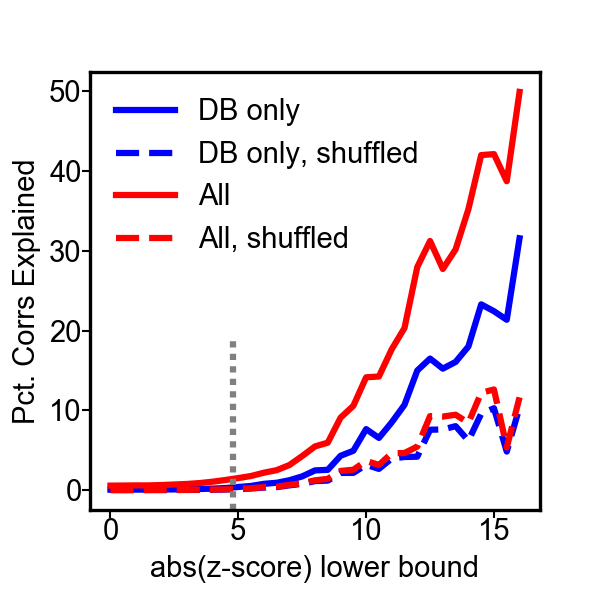

In [84]:
# Plot
def plot_pct_expl(plot_data, rand_type, bc_cutoff, by_cutoff, bh_cutoff):
    plt.figure(figsize=(2, 2), dpi=150)
    plt.plot(plot_data[('db', 'norand')][0],
             plot_data[('db', 'norand')][1],
             label='DB only', color='b', marker='')
    plt.plot(plot_data[('db', rand_type)][0],
             plot_data[('db', rand_type)][1],
             label='DB only, shuffled',
             color='b', linestyle='--', marker='')
    plt.plot(plot_data[('all', 'norand')][0],
             plot_data[('all', 'norand')][1],
             label='All', color='r', marker='')
    plt.plot(plot_data[('all', rand_type)][0],
             plot_data[('all', rand_type)][1],
             label='All, shuffled',
             color='r', linestyle='--', marker='')

    #plt.plot(all_x, all_y, label='All', marker='.')
    #plt.legend(loc='upper left', fontsize=fontsize, frameon=False)
    plt.xlabel('abs(z-score) lower bound')
    plt.ylabel('Pct. Corrs Explained')
    plt.legend(loc='upper left', fontsize=fontsize, frameon=False)
    ax = plt.gca()
    #plt.axvline(x=bc_cutoff, ymin=0, ymax=0.5, linestyle=(0, (1, 1)))
    plt.axvline(x=by_cutoff, ymin=0, ymax=0.4, linestyle=(0, (1, 1)), color='gray')
    #plt.axvline(x=bh_cutoff, ymin=0, ymax=0.5, linestyle=(0, (1, 1)))
    


    format_axis(ax)
    plt.subplots_adjust(left=0.15, bottom=0.15)
    plt.savefig(fig_path(f'pct_expl_corrs_db_vs_all_{rand_type}', 'pdf'))
    plt.savefig(fig_path(f'pct_expl_corrs_db_vs_all_{rand_type}', 'png'))

    
plot_pct_expl(plot_data, 'randxswap', bc_z_cutoff, by_z_cutoff, bh_z_cutoff)

<IPython.core.display.Javascript object>


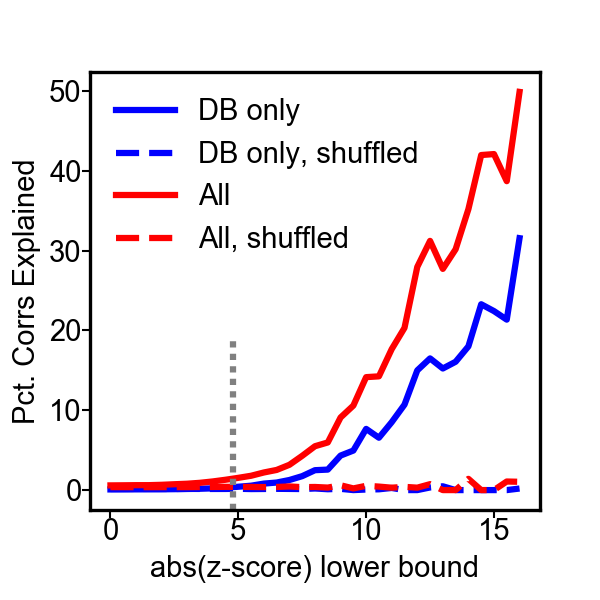

In [85]:
plot_pct_expl(plot_data, 'randlabels', bc_z_cutoff, by_z_cutoff, bh_z_cutoff)

In [68]:
import mplayer
p = mplayer.Player()
success_file = '/Users/johnbachman/Downloads/success.m4a'
p.loadfile(success_file)

Get the stats_df for the explainer and add a column to the explainer indicating whether the pair is in BioGrid or not:

In [86]:
z_cutoff = by_z_cutoff
sdf_list = []
edf_list = []
for (corpus_type, rand_type, lb, ub), expl in explainers.items():
    if corpus_type == 'all' and rand_type == 'norand':
        if ub is not None and ub < z_cutoff:
            continue
        elif lb >= z_cutoff:
            sdf_list.append(expl.stats_df)
            edf_list.append(expl.expl_df)
        else:
            filt_stats = expl.stats_df[expl.stats_df['z_score'] >= z_cutoff]
            filt_expl = expl.expl_df[expl.expl_df['z_score'] >= z_cutoff]
            sdf_list.append(filt_stats)
            edf_list.append(filt_expl)

In [87]:
# Concatenate all the dataframes
sdf = pd.concat(sdf_list, ignore_index=True).set_index('pair')

# Make a set of tuples for comparison to BioGrid
pair_tups = set()
for row in sdf.itertuples():
    pair_tups.add(tuple(sorted([row.agA, row.agB])))
in_bg_tups = pair_tups.intersection(bg_tuples)
in_bg_ix = [f'{t[0]}_{t[1]}' for t in in_bg_tups]

# Add Biogrid column to the dataframe
sdf['in_biogrid'] = False
sdf.loc[in_bg_ix, 'in_biogrid'] = True

# Join the expl_df to the stats_df
sdf_for_join = sdf.drop(['agA', 'agB', 'z_score'], axis=1)
edf = pd.concat(edf_list, ignore_index=True).join(sdf_for_join, on='pair')


Total number of correlations:

In [88]:
len(sdf)

487255

After filtering out the mito correlations:

In [89]:
n_sig_nonmito = len(sdf[sdf['apriori_explained'] == False])
n_sig_nonmito

385441

In [90]:
n_explainable = len(sdf[(sdf['apriori_explained'] == False) &
        ((sdf['reactome_paths'] == True) |
         (sdf['in_biogrid'] == True) |
         (sdf['explained'] == True))])
n_explainable

22168

In [91]:
sdf[(sdf['parent_connections'] == True) &
    (sdf['explained'] == False)]

,agA,agB,z_score,agA_ns,agA_id,agB_ns,agB_id,not_in_graph,explained,a_b,b_a,common_parent,apriori_explained,parent_connections,reactome_paths,in_biogrid
pair,,,,,,,,,,,,,,,,


In [92]:
n_explainable / n_sig_nonmito

0.05751334186036255

Pairs explained only by Reactome pathways:

In [93]:
len(sdf[(sdf['apriori_explained'] == False) &
        (sdf['reactome_paths'] == True) &
         (sdf['in_biogrid'] == False) &
         (sdf['explained'] == False)])

7089

...and pairs in BioGrid:

In [94]:
len(sdf[(sdf['reactome_paths'] == False) &
        (sdf['apriori_explained'] == False) &
        (sdf['in_biogrid'] == False)
       ])

368341

The number of these that we can explain is:

In [95]:
len(sdf[(sdf['reactome_paths'] == False) &
        (sdf['apriori_explained'] == False) &
        (sdf['in_biogrid'] == False) &
        (sdf['explained'] == True)])

5068

In [96]:
expl_sets = {}
for expl_type, expl_label in (('reactome_paths', 'Reactome pathways'),
                  ('in_biogrid', 'BioGrid interactions'),
                  ('explained', 'INDRA network')):
    expl_sets[expl_label] = set(sdf[(sdf['apriori_explained'] == False) &
                               (sdf[expl_type] == True)].index)

<IPython.core.display.Javascript object>


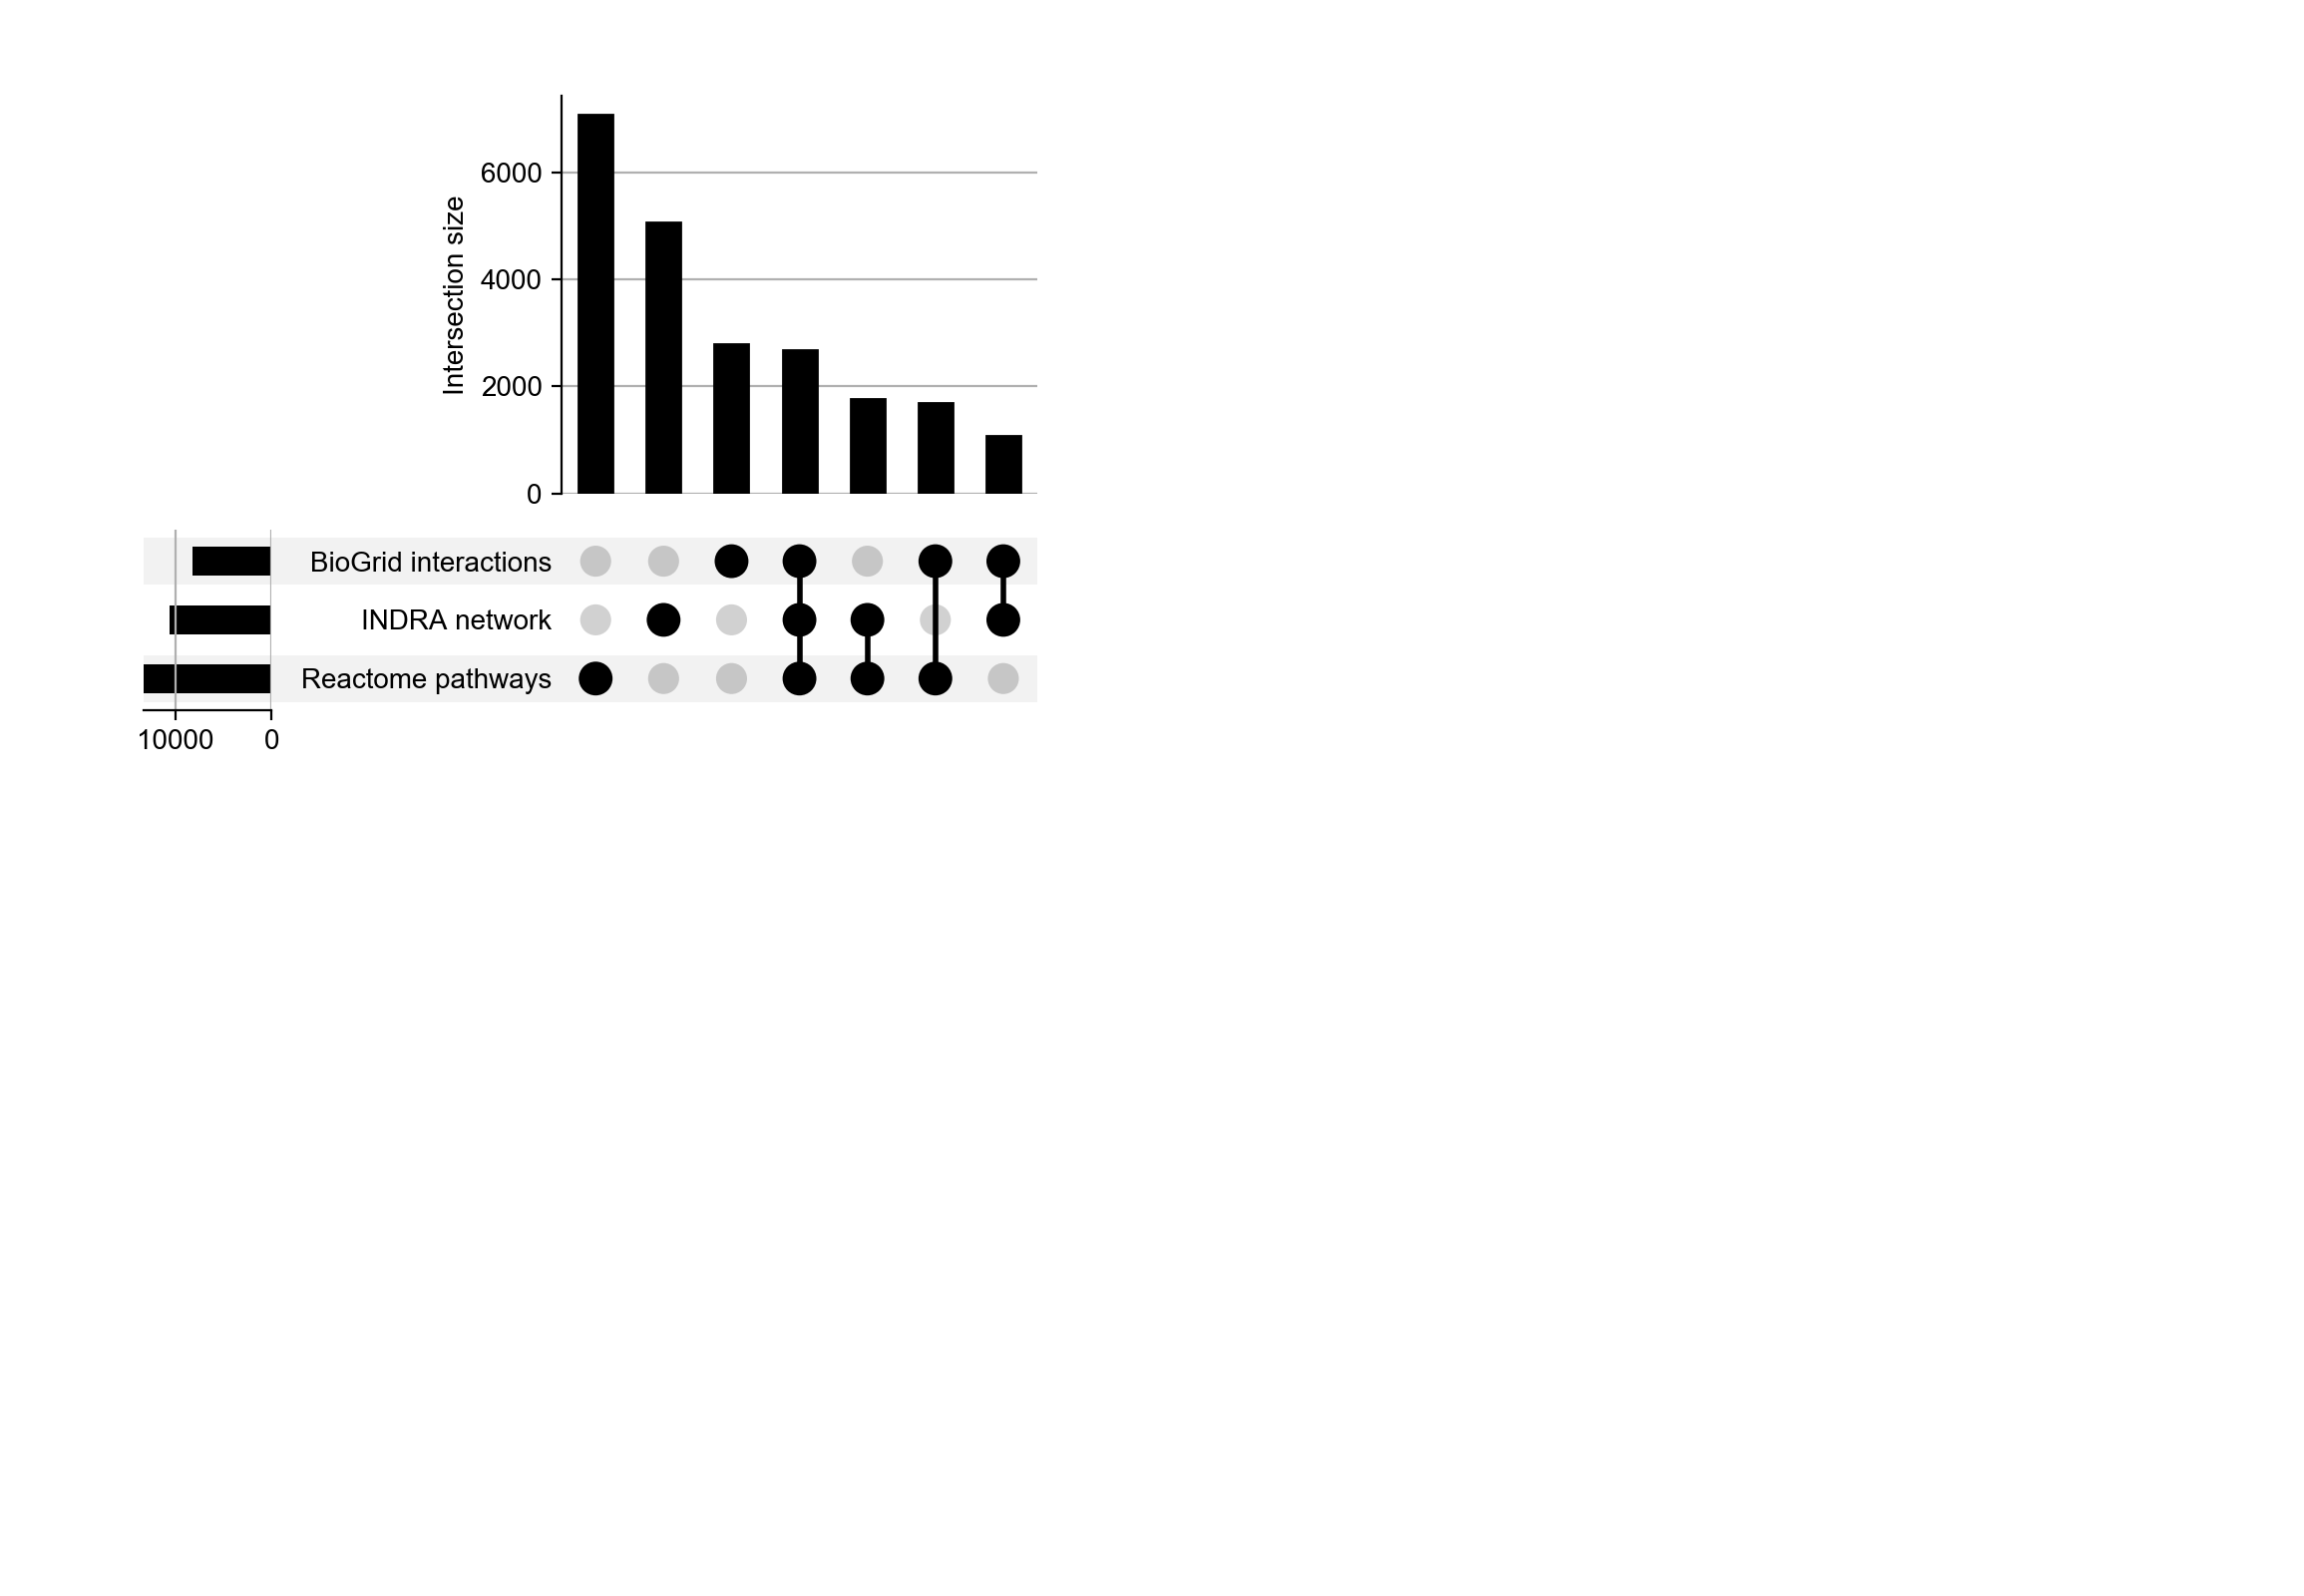

In [97]:
upset_df = upsetplot.from_contents(expl_sets)
upset_fig = plt.figure()
upsetplot.plot(upset_df, fig=upset_fig, sort_by='cardinality')
# Plot a linear scale version
#upset_fig.savefig(fig_path('overlap_upset_linear', 'pdf'))
# Plot a log scale version
#upset_fig.gca().set_yscale('log')
upset_fig.savefig(fig_path('expl_indra_rxm_bg', 'pdf'))

In [98]:
expl_indra_sets = {}
for expl_type, expl_label in (('a_b', 'Direct'),
                              ('b_a', 'Direct'),
                              ('common_parent', 'Family/Cplx'),
                              ('parent_connections', 'Parent Link')):
    if expl_type in ('a_b', 'b_a'):
        expl_indra_sets[expl_label] = set(sdf[(sdf['apriori_explained'] == False) &
                                              (sdf['reactome_paths'] == False) &
                                              (sdf['in_biogrid'] == False) &
                                              ((sdf['a_b'] == True) | (sdf['b_a'] == True))].index)        
    else:
        expl_indra_sets[expl_label] = set(sdf[(sdf['apriori_explained'] == False) &
                                              (sdf['reactome_paths'] == False) &
                                              (sdf['in_biogrid'] == False) &
                                              (sdf[expl_type] == True)].index)

<IPython.core.display.Javascript object>


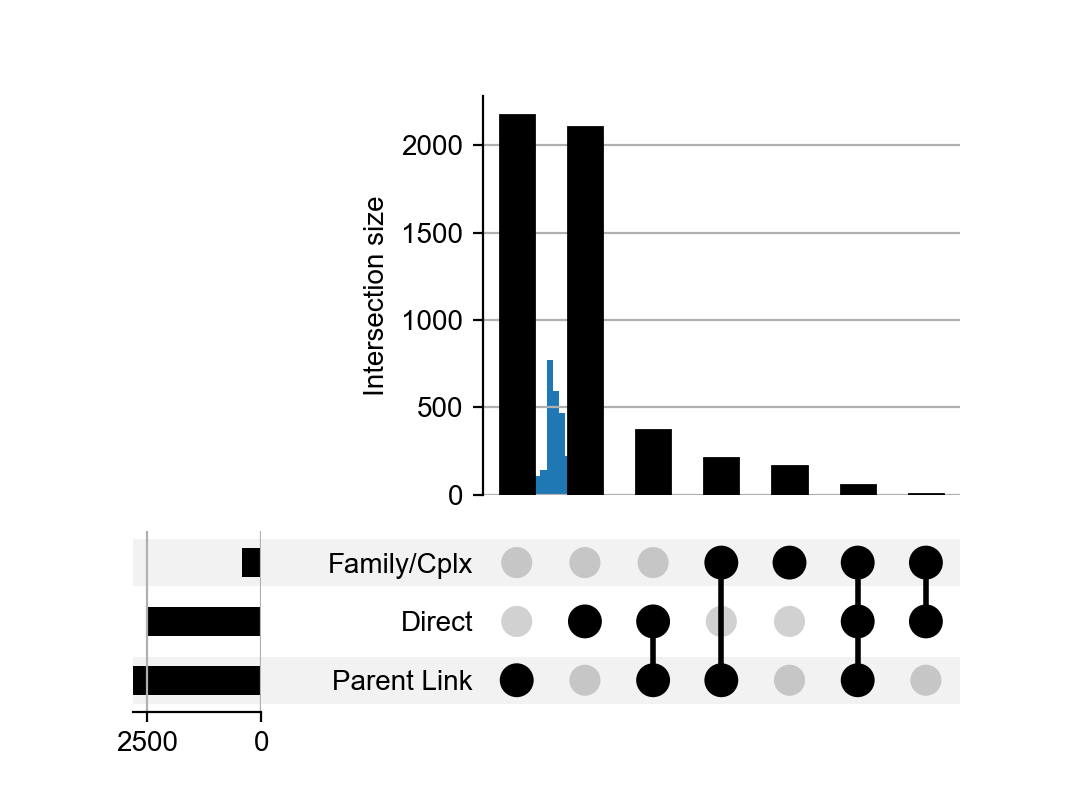

In [99]:
upset_df = upsetplot.from_contents(expl_indra_sets)
upset_fig = plt.figure()
upsetplot.plot(upset_df, fig=upset_fig, sort_by='cardinality')
upset_fig.savefig(fig_path('expl_indra_subtype', 'pdf'))

In [102]:
len(expl_indra_sets['Parent Link'])

2801

In [103]:
pc_only = set(sdf[(sdf['apriori_explained'] == False) &
        (sdf['reactome_paths'] == False) &
        (sdf['in_biogrid'] == False) &
        (sdf['a_b'] == False) &
        (sdf['b_a'] == False) &
        (sdf['common_parent'] == False) &
        (sdf['parent_connections'] == True)].index)

In [104]:
edf[edf.pair.isin(pc_only)][0:50]

,pair,agA,agB,z_score,expl_type,expl_data,agA_ns,agA_id,agB_ns,agB_id,not_in_graph,explained,a_b,b_a,common_parent,apriori_explained,parent_connections,reactome_paths,in_biogrid
2831,SYVN1_UBE2G2,SYVN1,UBE2G2,14.492168,parent_connections,{'SYVN1_op': {'SYVN1_UBE2': {'statements': [{'...,HGNC,20738,HGNC,12483,False,True,False,False,False,False,True,False,False
3897,MPRIP_ROCK2,MPRIP,ROCK2,-12.810335,parent_connections,{'MPRIP_op': {'MPRIP_ROCK': {'statements': [{'...,HGNC,30321,HGNC,10252,False,True,False,False,False,False,True,False,False
3991,NCKAP1_YES1,NCKAP1,YES1,12.922570,parent_connections,{'NCKAP1_op': {'NCKAP1_SRC': {'statements': [{...,HGNC,7666,HGNC,12841,False,True,False,False,False,False,True,False,False
4165,TLN1_YES1,TLN1,YES1,12.528886,parent_connections,{'TLN1_op': {'TLN1_SRC': {'statements': [{'stm...,HGNC,11845,HGNC,12841,False,True,False,False,False,False,True,False,False
4273,CCNK_PSMC1,CCNK,PSMC1,12.140980,parent_connections,{'sp_op': {'Cyclin_Proteasome': {'statements':...,HGNC,1596,HGNC,9547,False,True,False,False,False,False,True,False,False
4693,PAX8_PRKCI,PAX8,PRKCI,12.414380,parent_connections,{'PAX8_op': {'PKC_PAX8': {'statements': [{'stm...,HGNC,8622,HGNC,9404,False,True,False,False,False,False,True,False,False
4882,CCNI_TP53,CCNI,TP53,-11.888149,parent_connections,{'TP53_sp': {'Cyclin_TP53': {'statements': [{'...,HGNC,1595,HGNC,11998,False,True,False,False,False,False,True,False,False
5518,SMARCD1_TADA2B,SMARCD1,TADA2B,11.692346,parent_connections,{'TADA2B_sp': {'SWI_SNF_TADA2B': {'statements'...,HGNC,11106,HGNC,30781,False,True,False,False,False,False,True,False,False
5531,TP53_UBE2D3,TP53,UBE2D3,-11.917190,parent_connections,{'TP53_op': {'UBE2_TP53': {'statements': [{'st...,HGNC,11998,HGNC,12476,False,True,False,False,False,False,True,False,False
5756,DHH_VDR,DHH,VDR,11.145499,parent_connections,{'VDR_sp': {'Hedgehog_VDR': {'statements': [{'...,HGNC,2865,HGNC,12679,False,True,False,False,False,False,True,False,False


In [105]:
mprip_rock = edf.iloc[3955].expl_data

In [106]:
direct = set(sdf[(sdf['apriori_explained'] == False) &
        (sdf['reactome_paths'] == False) &
        (sdf['in_biogrid'] == False) &
        ((sdf['a_b'] == True) |
         (sdf['b_a'] == True)) &
        (sdf['common_parent'] == False) &
        (sdf['parent_connections'] == False)].index)

BRAF-MITF cherry-pick

In [107]:
braf_mitf_hashes = set([ed['stmt_hash'] for ed in edf.iloc[139].expl_data])
mitf_braf_hashes = set([ed['stmt_hash'] for ed in edf.iloc[140].expl_data])
braf_mitf_all_hashes = list(braf_mitf_hashes.union(mitf_braf_hashes))

In [108]:
len(braf_mitf_all_hashes)

10

In [109]:
braf_mitf_stmts = [s for s in tqdm(all_stmts) if s.get_hash() in braf_mitf_all_hashes]

100%|██████████| 814991/814991 [00:22<00:00, 37016.94it/s]


In [110]:
len([ev for stmt in braf_mitf_stmts for ev in stmt.evidence])

221

"More obscure" cherry-pick:

In [111]:
edf['abs_z_score'] = abs(edf['z_score'])

In [112]:
novel_direct = edf[edf.pair.isin(direct)].sort_values(by='abs_z_score', ascending=True)

In [ ]:
def max_belief(series):
    ix_list = []
    mb_list = []
    for ix, expl_data in series.iteritems():
        max_bel = max([d['belief'] for d in expl_data])
        mb_list.append(max_bel)
        ix_list.append(ix)
    return ix_list, mb_list

ix, mb = max_belief(novel_direct.expl_data)
novel_direct.loc[ix, 'max_belief'] = mb

In [ ]:
def reading_only(series):
    readers = set(['reach', 'sparser', 'medscan', 'rlimsp', 'trips'])
    ix_list = []
    ro_list = []
    for ix, expl_data in series.iteritems():
        all_sources = set()
        for expl_stmt in expl_data:
            all_sources |= set(expl_stmt['source_counts'].keys())
        is_ro = True if all_sources < readers else False
        ix_list.append(ix)
        ro_list.append(is_ro)
    return ix_list, ro_list

ix, ro = reading_only(novel_direct.expl_data)
novel_direct.loc[ix, 'reading_only'] = ro

In [ ]:
ndro = novel_direct[novel_direct['reading_only'] == True]

In [ ]:
ndro.sort_values(by='abs_z_score', ascending=False).sort_values(by='max_belief', ascending=True)[0:50]

In [ ]:
ndro.loc[5702].expl_data

In [ ]:
#venn_subplot = venn(expl_sets, fmt='{percentage:.2f}')
#venn_subplot.figure.savefig(fig_path('overlap_venn_pcts', 'pdf'))

Looking at explanations, add column for max belief for entries with direct explanations:

In [ ]:
edf['max_belief'] = 0
edf['reading_only'] = float('nan')

How many total unique correlations explained this way?

Set the max_belief column:

Add in a field for whether the explanations are from reading only:

The parent connections-only explanations:

In [ ]:
edf[edf.pair.isin(pc_only)].sort_values(by='max_belief', ascending=False)[0:50]

In [ ]:
edf[edf['pair'] == 'NCKAP1_YES1'].expl_data.values[0:100

In [ ]:
nov_dir_ro = novel_dir[novel_dir.reading_only == True][['pair', 'z_score', 'max_belief', 'expl_type', 'expl_data']]

In [ ]:
len(nov_dir_ro.pair.unique())

Get the subset of these explained by parent connections:

In [ ]:
novel_dir = novel[(novel['expl_type'] == 'a_b') |
                  (novel['expl_type'] == 'b_a')]

In [ ]:
nov_dir_ro.sort_values(by='z_score', ascending=False)[0:50]

In [ ]:
nov_dir_ro.loc[2108].expl_data

Open the files dumped by the script above to get the DepMapExplainer objects:

In [ ]:
dme_db.stats_df[dme_db.stats_df['explained'] == True]

In [ ]:
dme_all.stats_df[dme_all.stats_df['explained'] == True]

Plot max belief score vs. pair correlation

In [ ]:
dme_all.stats_df.shape

In [ ]:
zsc_all = dme_all.stats_df[dme_all.stats_df['explained'] == True].z_score.abs()
zsc_db = dme_db.stats_df[dme_db.stats_df['explained'] == True].z_score.abs()

In [ ]:
fig = plt.figure(figsize=(2, 2), dpi=150)
ax = plt.gca()
sns.histplot(zsc_all, stat='count', element='poly', color='blue', ax=ax, fill=False, label='All')
sns.histplot(zsc_db, stat='count', element='poly', color='red', ax=ax, fill=False, label='DB only')
plt.legend(loc='upper right', fontsize=7, frameon=False)
plt.title('Number of explained correlations', fontsize=7)
format_axis(ax)
plt.subplots_adjust(left=0.18)
plt.savefig(fig_path('num_expl_corrs_db_vs_all', 'pdf'))
#sns.displot(zsc_db, color='red')
#sns.distplot(zsc_db)

In [ ]:
dme_all_pair = dme_all.stats_df.set_index('pair').drop(['agA', 'agB', 'z_score'], axis=1)
dme_all_df = dme_all.expl_df.join(dme_all_pair, on='pair')

In [ ]:
counter = 0
expl_summary = []
for gb_key, gb_df in tqdm(dme_all.expl_df.groupby('pair')):
    all_beliefs = []
    ev_ct = 0
    num_stmts = 0
    stmt_types = set()
    only_cp = True
    for row in gb_df.itertuples():
        if row.expl_type in ('a_b', 'b_a'):
            num_stmts += len(row.expl_data)
            for stmt_info in row.expl_data:
                ev_ct += stmt_info['evidence_count']
                stmt_types.add(stmt_info['stmt_type'])
                stmt = stmts_by_hash[stmt_info['stmt_hash']]
                all_beliefs.append(stmt.belief)
                z_score = row.z_score
            only_cp = False
    if only_cp:
        continue
    max_belief = np.max(all_beliefs)
    avg_belief = np.mean(all_beliefs)
    pair_info = {'pair': gb_key,
                 'num_stmts': num_stmts,
                 'ev_ct': ev_ct,
                 'num_stmt_types': len(stmt_types),
                 'max_belief': np.max(all_beliefs),
                 'avg_belief': np.mean(all_beliefs),
                 'z_score': z_score,
                 'abs_z_score': abs(z_score),
                }
    expl_summary.append(pair_info)

In [ ]:
dme_all_df.columns

In [ ]:
dme_all_sum_df = pd.DataFrame.from_records(expl_summary, index='pair')

In [ ]:
fig = plt.figure(figsize=(2, 2), dpi=150)
sns.scatterplot(x='abs_z_score', y='ev_ct', data=dme_all_sum_df, s=1.5)
ax = plt.gca()
ax.set_yscale('log')
plt.subplots_adjust(left=0.15, bottom=0.15)
format_axis(ax)

In [ ]:
dme_all_sum_df.corr()


In [ ]:
dasd = dme_all_sum_df

In [ ]:
dasd[dasd['max_belief'] < 0.25].sort_values('abs_z_score', ascending=False)

In [ ]:
dme_all

In [ ]:
plt.gca()

In [ ]:
pos_types = set(['Activation', 'IncreaseAmount'])
neg_types = set(['Inhibition', 'DecreaseAmount'])

mitocarta = pd.read_excel('../../depmap_analysis/notebooks/data/Human.MitoCarta3.0.xls', sheet_name=1)
mitogenes = list(mitocarta.Symbol.values)

def get_expl_stats(dme):
    # Iterate over explanations for pair
    stats = dme.stats_df.set_index('pair')
    expl_summary = []
    expl_hashes = {}
    for gb_key, gb_df in tqdm(dme.expl_df.groupby('pair')):
        # Skip mitochondrial correlations
        agA, agB = gb_key.split('_')
        if agA in mitogenes or agB in mitogenes:
            continue
        pair_hashes = set()
        for row in gb_df.itertuples():
            for stmt_info in row.expl_data:
                pair_hashes.add(stmt_info['stmt_hash'])
        expl_hashes[gb_key] = pair_hashes
        corr = stats.loc[gb_key].z_score
        stmts = [stmts_by_hash[h] for h in pair_hashes]
        stmt_types = set([s.__class__.__name__ for s in stmts])
        # Check only positive types
        if not stmt_types.difference(pos_types):
            sign = 'positive'
        # Check only negative types
        elif not stmt_types.difference(neg_types):
            sign = 'negative'
        else:
            sign = 'mixed'
        expl_summary.append((gb_key, corr, len(pair_hashes), list(pair_hashes), sign, stmts))
    return expl_summary

In [ ]:
expl_db = get_expl_stats(dme_db)

In [ ]:
expl_all = get_expl_stats(dme_all)

In [ ]:
pairs, z_scores, num_stmts, hashes, sign, stmts = zip(*expl_all)

In [ ]:
len(expl_db)

In [ ]:
len(expl_all)

In [ ]:
expl = [e for e in expl_all if e[2] >200]

In [ ]:
[stmts_by_hash[h] for h in expl[0][3]]

In [ ]:
def rand_jitter(arr, jitter=0.01):
    stdev = jitter * (max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

plt.figure()
pos = [e for e in expl_all if e[4] == 'positive']
neg = [e for e in expl_all if e[4] == 'negative']
mixed = [e for e in expl_all if e[4] == 'mixed']

points = [(mixed, 'gray'), (pos, 'red'), (neg, 'blue')]
for data, color in points:
    plt.plot([t[1] for t in data],
             rand_jitter([t[2] for t in data], jitter=0.1),
             linestyle='', marker='.', markersize=3, color=color, alpha=0.2)
plt.ylim(0, 5)

In [ ]:
contra = [expl for expl in expl_all if (expl[1] < 0 and expl[4] == 'positive') or
                                       (expl[1] > 0 and expl[4] == 'negative')]
contra.sort(key=lambda x: abs(x[1]), reverse=True)

In [ ]:
len(contra)

In [ ]:
list(zip(range(len(contra)), contra))

In [ ]:
contra[9]

In [ ]:
contra[9][-1][0].evidence

In [ ]:
top = ac.filter_top_level(kge_stmts)
not_top = [s for s in kge_stmts if s not in top]

In [ ]:
samp = random.sample(stmts_y, 20)
kge_samp, y_samp = list(zip(*samp))

In [ ]:
small_stmts_y = [(s, y) for s, y in zip(kge_samp, y_samp) if len(s.evidence) <= 10]

In [ ]:
def total_ev(stmt):
    return sum([len(s.evidence) for s in ([stmt] + stmt.supports + stmt.supported_by)])

In [ ]:
for ix, (s, y) in enumerate(small_stmts_y):
    print(ix, len(s.evidence), total_ev(s), s)

In [ ]:
exclude = [ 3, 10, 11, 14, 15, 23, 24, 27, 33, 38, 49, 59, 61, 63, 64, 70]

In [ ]:
small_stmts_y_filt = [s for ix, s in enumerate(small_stmts_y) if ix not in exclude]

In [ ]:
small_stmts, small_y = zip(*small_stmts_y_filt)

In [ ]:
top = ac.filter_top_level(small_stmts)
not_top = [s for s in small_stmts if s not in top][5:10]

In [ ]:
subsamp = random.sample(top, 5)

In [ ]:
final_samp_y = [(s, y) for s, y in small_stmts_y if s in not_top or s in subsamp]

In [ ]:
len(final_samp_y)

In [ ]:
small_stmts, small_y = zip(*final_samp_y)

In [ ]:
import json
from indra.statements import stmts_to_json, stmts_from_json

with open('/Users/johnbachman/Desktop/test_stmts_cur_samp.pkl', 'wb') as f:
    pickle.dump((small_stmts, small_y), f)
    
with open('/Users/johnbachman/Desktop/test_stmts_cur_samp.json', 'w') as f:
    json.dump(stmts_to_json(list(small_stmts)), f)


In [ ]:
ev_ctr = [len(s.evidence) for s in small_stmts]

In [ ]:
from indra.statements import stmts_to_json, stmts_from_json

with open('/Users/johnbachman/Desktop/test_stmts_cur_samp.json', 'r') as f:
    stmt_json = json.load(f)
    foo = stmts_from_json(stmt_json)

In [ ]:
top = ac.filter_top_level(foo)

In [ ]:
not_top = [s for s in foo if s not in top]

In [ ]:
not_top[0].supports

In [ ]:
arr1 = np.array([1, 2])
arr2 = np.array([1, 3])
np.all(np.greater_equal(arr2, arr1))